### Required activity 25.3: Portfolio project on optimising a model for real-life data

This project will be built with aim of predicting stock prices using Long Short Term Memory (LSTM). 

### Part 1. Finding a dataset

1. What format is the data in? Dates and numeric

2. Is the data clean? Yes, data downloaded from Yahoo! are cleaned.

3. How large is the dataset? Sizable data since 1980.

4. How will you split your data into train, validate and test sets? 60%, 20%, 20%

In [1]:
# Testing
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

For simplicity sake, we will be using just Tesla stock.

In [2]:
# 1. Fetch Historical Stock Prices
data = yf.download('TSLA', start='2022-01-01')
data = data[['Close']]

[*********************100%%**********************]  1 of 1 completed


### Part 2. Exploratory Data Analysis (EDA)
1. Explore, clean and pre-process 
2. Dimension reduction & feature engineering

In [3]:
nasdaq = yf.Ticker("^IXIC")
sp500 = yf.Ticker("^GSPC")

nasdaq_price = nasdaq.history(period=None)
sp500_price = sp500.history(period=None)

nasdaq_price = nasdaq_price.iloc[-len(data):,:]
sp500_price = sp500_price.iloc[-len(data):,:]
data.tail()

Close
Date                  
2023-10-09  259.670013
2023-10-10  263.619995
2023-10-11  262.989990
2023-10-12  258.869995
2023-10-13  251.119995

In [4]:
print(f'Total records are {data.shape[0]}. \nNull check \n{data.isnull().count()}')

Total records are 448. 
Null check 
Close    448
dtype: int64


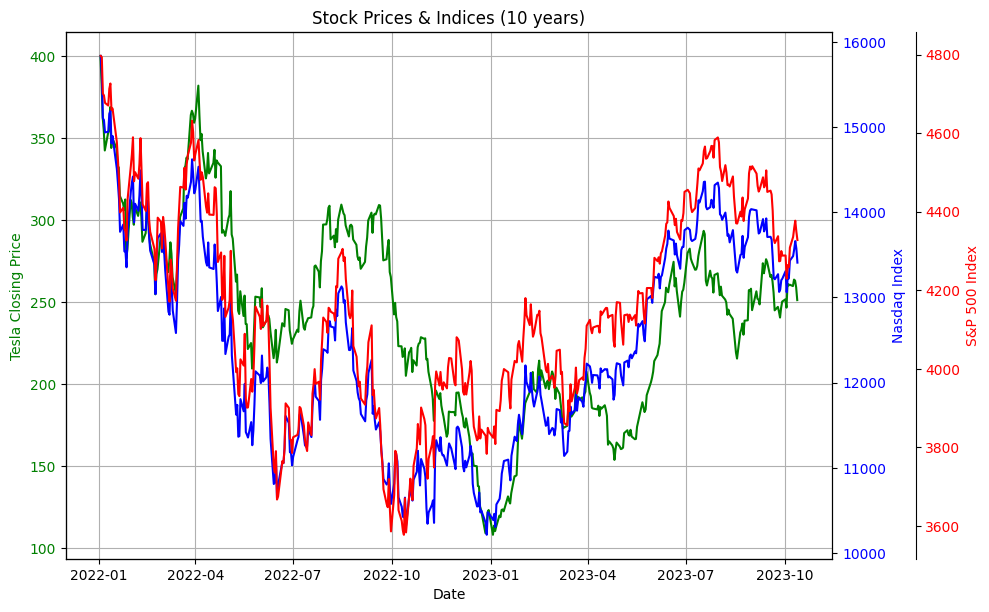

In [5]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(data['Close'], label='Tesla Closing Price', color='g')
ax1.set_xlabel('Date')
ax1.set_ylabel('Tesla Closing Price', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(nasdaq_price['Close'], label='Nasdaq', color='b')
ax2.set_ylabel('Nasdaq Index', color='b')
ax2.tick_params(axis='y', labelcolor='b')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(sp500_price['Close'], label='S&P 500', color='r')
ax3.set_ylabel('S&P 500 Index', color='r')
ax3.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Stock Prices & Indices (10 years)')
plt.show()

Other technical indicators and metrics that can help with prediction. 

1. Moving Average Convergence Divergence (MACD) - 
2. Relative Strength Index (RSI) - _Result of stock price_
3. On-Balance Volume (OBV) - _Perhaps doesn't align with short term strategy_
4. Chaikin Money Flow(CMF) - _Perhaps doesn't align with short term strategy_
5. Fibonacci Retracements
6. News Sentiment Analysis
7. and more...

A few consideration for the algorithm are.
1. Not to short a equity (or till model are in higher confidence) to limit potential losses.
2. RSI below 30 should trigger a higher aggressive technical
3. Crossover of MACD line should trigger a higher aggressive technical. Recommended to wait for 3-4 days to confirm __NOT__ a false positive
4. Fibonacci Retracements should support a slightly higher aggressive technical on each level. Most commonly used ratios include 23.6%, 38.2%, 50%, 61.8%, and 78.6

These pointers are what humans can observe. Using deep learning algorithms (RNN-LSTM), more pattern could potentially be uncovered.

In [6]:
#MACD with traditional setting (26/12/9). The signal line is a nine-period EMA of the MACD line.
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    data = data.copy()
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    
    # MACD line
    data.loc[:, 'MACD'] = short_ema - long_ema
    # Signal Line
    data.loc[:, 'Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    return data

data = compute_macd(data)
data.head()

Close      MACD  Signal_Line
Date                                         
2022-01-03  399.926666  0.000000     0.000000
2022-01-04  383.196655 -1.334588    -0.266918
2022-01-05  362.706665 -3.999525    -1.013439
2022-01-06  354.899994 -6.664615    -2.143674
2022-01-07  342.320007 -9.680230    -3.650985

In [7]:
#RSI with Exponential Weighted Function(ewm) which give weights to values.
def compute_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.ewm(min_periods=window, adjust=False, alpha=1/window).mean()
    avg_loss = loss.ewm(min_periods=window, adjust=False, alpha=1/window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

data['RSI'] = compute_rsi(data['Close'], 14)
data.head() # Notice the first 13 rows RSI are NaN due to calculation window

Close      MACD  Signal_Line  RSI
Date                                              
2022-01-03  399.926666  0.000000     0.000000  NaN
2022-01-04  383.196655 -1.334588    -0.266918  NaN
2022-01-05  362.706665 -3.999525    -1.013439  NaN
2022-01-06  354.899994 -6.664615    -2.143674  NaN
2022-01-07  342.320007 -9.680230    -3.650985  NaN

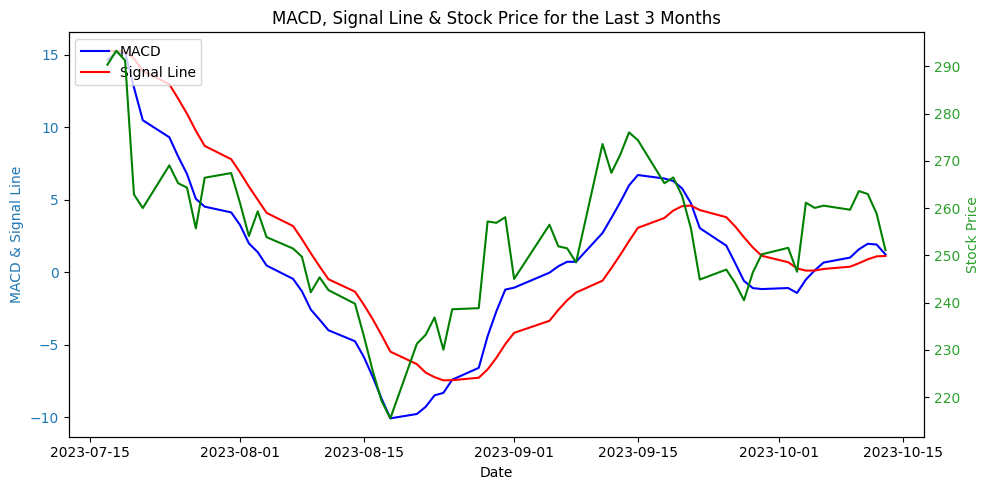

In [8]:
# 3 months period plot
# Plotting MACD and stock price
end_date = data.index[-1]  # Get the last date
start_date = end_date - timedelta(days=90)  # approx. 3 months

filtered_data = data[start_date:end_date]

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Date')
ax1.set_ylabel('MACD & Signal Line', color='tab:blue')
ax1.plot(filtered_data.index, filtered_data['MACD'], label='MACD', color='blue')
ax1.plot(filtered_data.index, filtered_data['Signal_Line'], label='Signal Line', color='red')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
ax2.set_ylabel('Stock Price', color='tab:green')  
ax2.plot(filtered_data.index, filtered_data['Close'], label='Stock Price', color='green')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('MACD, Signal Line & Stock Price for the Last 3 Months')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
fig.tight_layout()  
plt.show()

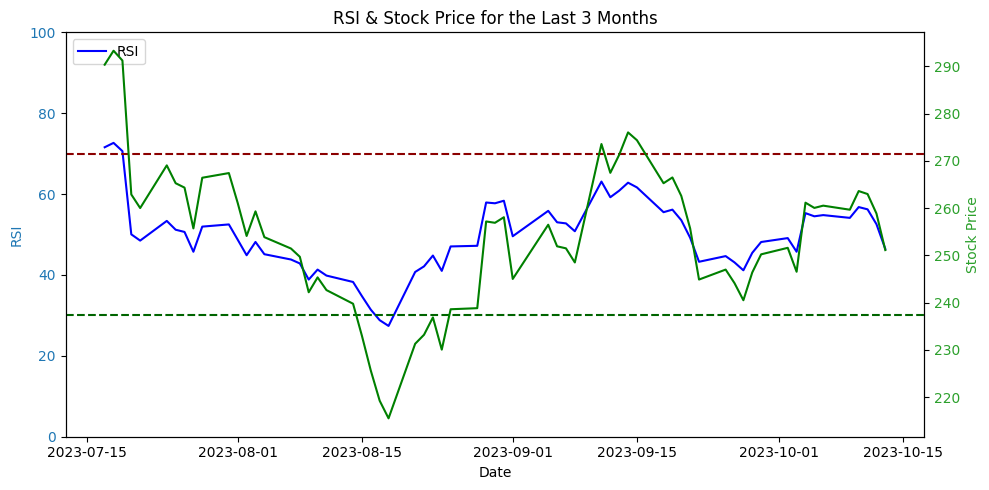

In [9]:
# Plotting RSI and stock price
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Date')
ax1.set_ylabel('RSI', color='tab:blue')
ax1.plot(filtered_data.index, filtered_data['RSI'], label='RSI', color='blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 100)
ax1.legend(loc='upper left')
ax1.axhline(y=70, color='darkred', linestyle='--')  # Overbought level
ax1.axhline(y=30, color='darkgreen', linestyle='--')  # Oversold level

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Stock Price', color='tab:green')  # we already handled the x-label with ax1
ax2.plot(filtered_data.index, filtered_data['Close'], label='Stock Price', color='green')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('RSI & Stock Price for the Last 3 Months')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
fig.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

In [10]:
print(f'Total records are {data.shape[0]}. \nNull check \n{data.isnull().sum()}')

Total records are 448. 
Null check 
Close           0
MACD            0
Signal_Line     0
RSI            13
dtype: int64


In [11]:
correlation_matrix = data.corr()
correlation_matrix

Close      MACD  Signal_Line       RSI
Close        1.000000  0.266149     0.283852  0.311441
MACD         0.266149  1.000000     0.952973  0.850514
Signal_Line  0.283852  0.952973     1.000000  0.700858
RSI          0.311441  0.850514     0.700858  1.000000

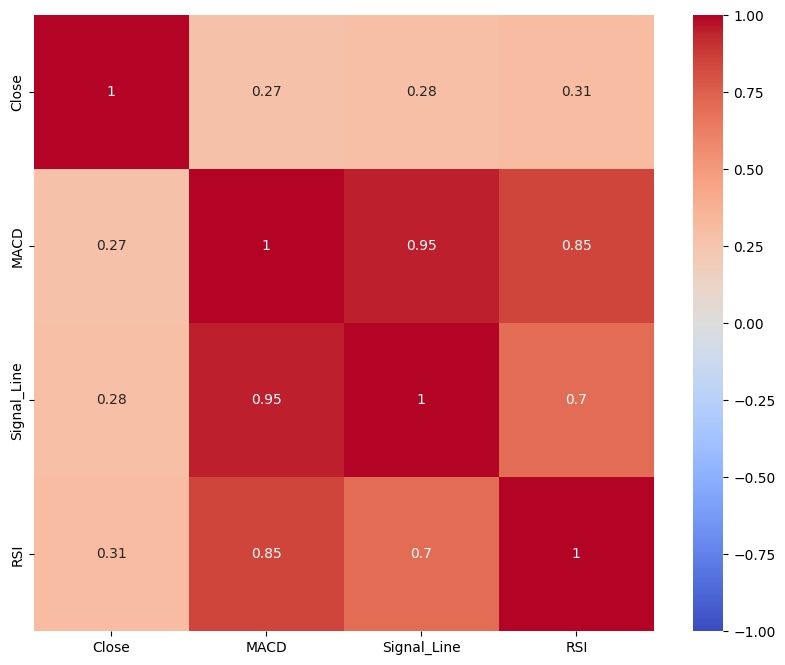

In [12]:
# Using Seaborn to plot a heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

We can note from the seaborn plot that MACD, Signal Line and RSI are all good features to be used to predict 'Close' price. For a simple approach, we will be using just the 'Closing' price for LSTM. 

### Part 3. ML techniques and data partition
Recurrent Neural Networks (RNNs) are designed to handle sequences of variable lengths, making them particularly suitable for tasks like predicting future values in a sequence. They maintain an internal state that can capture information about previous elements in the sequence, allowing them to remember important parts and potentially forget less crucial details over time.


However, traditional RNNs suffer from challenges related to the vanishing and exploding gradient problems, especially when processing long sequences. These issues hinder RNN’s ability to learn from distant past information in the sequence.


To address this, __Long Short-Term Memory (LSTM)__ networks were introduced. LSTMs are a special kind of RNN that can learn and remember over long sequences and are not as susceptible to the vanishing gradient problem as standard RNNs. This makes them more efficient at capturing long-term dependencies in sequence data.

Allocation of data for training are
1. Train: 80%
2. Test: Last 5 days will be used for testing.
3. Validation: Takes the rest

Project is a regression problem, hence we will be testing out performance metrics.
1. Mean Square Error (MSE)

In [13]:
data = data[['Close']]
# data

In [14]:
# 2. Preprocess the Data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data['Close'].values.reshape(-1, 1))#.values.reshape(-1, 1))

# Convert data to PyTorch tensors and create in/out sequence data
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

train_window = 5
inout_seq = create_inout_sequences(data_normalized, train_window)
inout_seq = [(torch.FloatTensor(seq), torch.FloatTensor(label)) for seq, label in inout_seq]

# Split data into train, validate, and test sets
total_length = len(inout_seq)
test_length = 5
remaining_length = total_length - test_length

train_length = int(0.9 * remaining_length)
valid_length = remaining_length - train_length

train_dataset = inout_seq[:train_length]
valid_dataset = inout_seq[train_length:train_length+valid_length]
test_dataset = inout_seq[-test_length:]

Epoch 0/30 - Training loss: 0.0262, Validation loss: 0.0141
Epoch 10/30 - Training loss: 0.0458, Validation loss: 0.0459
Epoch 20/30 - Training loss: 0.0340, Validation loss: 0.0199


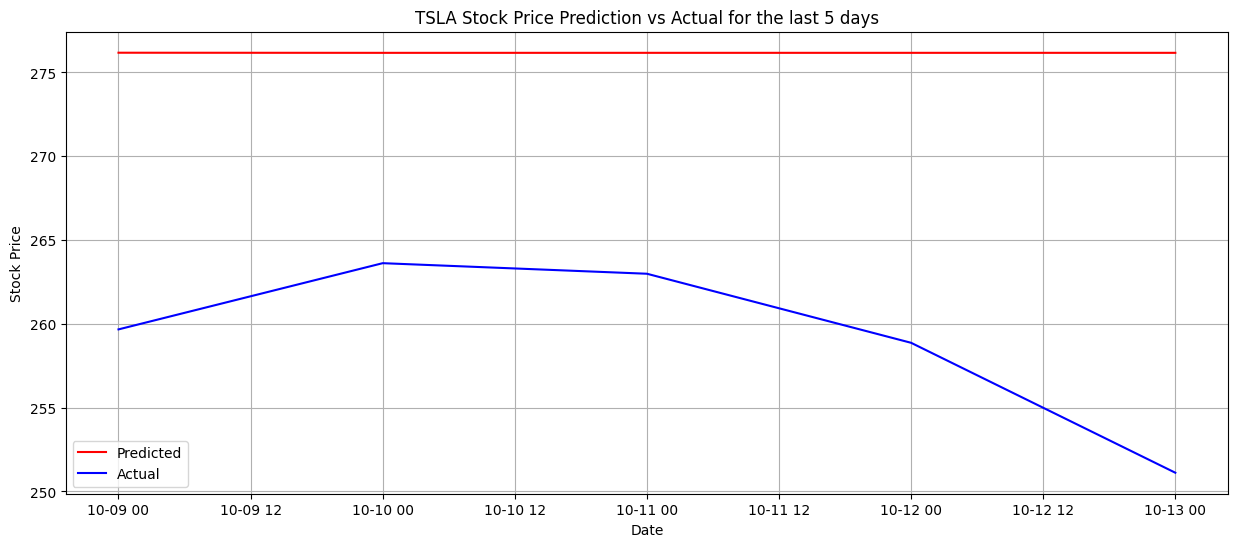

[[276.17426192]
 [276.16712159]
 [276.16791303]
 [276.16786954]
 [276.16792173]]


In [15]:
# 3. Build LSTM Model - Pytorch
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out
    
    
def main(train_window, train_dataset, valid_dataset, test_dataset, bo) :
    input_dim = 1
    hidden_dim = int(bo[0])
    num_layers = int(bo[1])
    output_dim = 1

    dropout = float(bo[2]) #0.01
    learning_rate = float(bo[3]) #0.01
    epochs = int(bo[4])
    
    model = LSTM(input_dim, hidden_dim, num_layers, dropout, output_dim)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for seq, labels in train_dataset:
            optimizer.zero_grad()
            y_pred = model(seq.view(1, train_window, -1))
            loss = criterion(y_pred, labels)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()
        avg_train_loss = np.mean(train_losses)
        
        # Validation
        model.eval()
        valid_losses = []
        for seq, labels in valid_dataset:
            with torch.no_grad():
                y_pred = model(seq.view(1, train_window, -1))
                loss = criterion(y_pred, labels)
                valid_losses.append(loss.item())
        avg_valid_loss = np.mean(valid_losses)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs} - Training loss: {avg_train_loss:.4f}, Validation loss: {avg_valid_loss:.4f}')

    # Testing for the last 5 days
    test_inputs = data_normalized[-test_length:].tolist()
    model.eval()
    for _ in range(test_length):  # Predicting for next 5 days
        seq = torch.FloatTensor(test_inputs[-train_window:]).view(1, train_window, -1)
        with torch.no_grad():
            test_inputs.append([model(seq).item()])

    actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))
    dates = data.index[-test_length:]
    plt.figure(figsize=(15, 6))
    plt.plot(dates, actual_predictions, label='Predicted', color='red')
    plt.plot(dates, scaler.inverse_transform(data_normalized[-5:]), label='Actual', color='blue')
    plt.title("TSLA Stock Price Prediction vs Actual for the last 5 days")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return(actual_predictions)
    
if __name__ == '__main__':
    bo = [64, 2, 0.3, 0.01, 30]     # hidden_dim, num_layers, dropout, learning_rate, epoch
    actual_predictions = main(train_window, train_dataset, valid_dataset, test_dataset, bo) 
    print(actual_predictions)

In [16]:
actual_predictions, data.tail(len(actual_predictions))
abs_different = np.sum(abs(actual_predictions-data.tail(len(actual_predictions))))
print(f'Sum of 5 windows differents from predicted with actual : {abs_different.values}')

Sum of 5 windows differents from predicted with actual : [84.5750988]


### Part 3. Hyperparameter Optimization

From the plot above, we can observe that the prediction is pretty bad. Options is to try to tune the parameters to see if plots can get closer to the actual test. 

From the high validation loss, we can conclude that the the model is overfitting.

Bayesian Optimization

In [17]:
from statistics import NormalDist
from scipy.stats import norm
from sklearn.decomposition import KernelPCA, PCA

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF 

In [18]:
X = np.array(bo)
Y = np.array(abs_different) # val_loss # Validation loss
X = X.reshape(1, -1)  
Y = Y.reshape(-1, 1)  
print(X.shape,Y.shape)
X,Y

(1, 5) (1, 1)


(array([[6.4e+01, 2.0e+00, 3.0e-01, 1.0e-02, 3.0e+01]]), array([[84.5750988]]))

A combination of 3 acquistion functions and picking the highest values for the nexy query point. The aim of this BO is to seek a global minima

In [19]:
#PI
def probability_improvement(eta): 
    #For bo hidden_dim, num_layers, dropout, learning_rate
    query_range_hiddenunit = np.linspace(64, 512, 3)  
    query_range_layers = np.linspace(2, 3, 2)  
    query_range_dropout = np.linspace(0.2, 0.5, 4)    
    query_range_lr = np.linspace(0.0001, 0.1, 4)    
    query_range_epoch = np.linspace(30, 100, 8)
    
    # Construct meshgrid using individual feature ranges
    grid = np.meshgrid(query_range_hiddenunit, query_range_layers, 
                       query_range_dropout, query_range_lr, query_range_epoch)
    query_points = np.vstack(list(map(np.ravel, grid))).T

    mean, std = bogp.predict(query_points, return_std=True)
    best_observed = np.min(df_y) #.max(df_y) 
    
    pi = []
    for k in range(len(query_points)):
        pi.append(1 - NormalDist(mu = mean[k], sigma = std[k]).cdf(best_observed - eta))
        
    pi = np.array(pi)
    next_query_point = query_points[np.argmin(pi)] #[np.argmax(pi)]
    
    return query_points, pi 

#UCB
def upper_confidence_bound(beta): 
    #For bo hidden_dim, num_layers, dropout, learning_rate
    query_range_hiddenunit = np.linspace(64, 512, 3)  
    query_range_layers = np.linspace(2, 3, 2)  
    query_range_dropout = np.linspace(0.2, 0.5, 4)    
    query_range_lr = np.linspace(0.001, 0.1, 4)    
    query_range_epoch = np.linspace(30, 100, 8)
    
    # Construct meshgrid using individual feature ranges
    grid = np.meshgrid(query_range_hiddenunit, query_range_layers, 
                       query_range_dropout, query_range_lr, query_range_epoch)
    query_points = np.vstack(list(map(np.ravel, grid))).T

    mean, std = bogp.predict(query_points, return_std=True)
    ucb = mean - (beta * std)
    
    next_query_point = query_points[np.argmin(ucb)] # [np.argmax(ucb)]
    
    return query_points, ucb 

#EI
def expected_improvement(xi): 
    #For bo hidden_dim, num_layers, dropout, learning_rate
    query_range_hiddenunit = np.linspace(64, 512, 3)  
    query_range_layers = np.linspace(2, 3, 2)  
    query_range_dropout = np.linspace(0.2, 0.5, 4)    
    query_range_lr = np.linspace(0.0001, 0.1, 4)    
    query_range_epoch = np.linspace(30, 100, 8)
    
    # Construct meshgrid using individual feature ranges
    grid = np.meshgrid(query_range_hiddenunit, query_range_layers, 
                       query_range_dropout, query_range_lr,query_range_epoch)
    query_points = np.vstack(list(map(np.ravel, grid))).T
    
    f_best = np.min(df_y)
    mean, std = bogp.predict(query_points, return_std=True)
    
    z = (f_best - mean - xi) / std #    z = (mean - f_best - xi) / std
    ei = (f_best - mean - xi) * norm.cdf(z) - std * norm.pdf(z)# ei = (mean - f_best - xi) * norm.cdf(z) + std * norm.pdf(z)
    ei[std == 0.0] = 0.0  # Set EI to 0 where std is 0 to avoid division by zero.

    next_query_point = query_points[np.argmax(ei)] # This is correct

    return query_points, ei 

In [20]:
# stack new query and observation for every loop
def update_surrogate_model(new_X, new_y):
    if len(X) == 0 and len(Y) == 0:
        # If X and Y are empty, just return the new_X and new_y
        return new_X, new_y

    # Stack them vertically
    df_X = np.vstack([X, new_X])
    df_y = np.vstack([Y, new_y])
    return df_X, df_y

# Picking the highest acquisition function value among UCB, EI and PI.
def choose_next_query_point(next_query_point_ucb, af_ucb, next_query_point_ei, af_ei, next_query_point_pi, af_pi):
    
    # Find the index of the element with the highest acquisition function value for each method
    min_ucb_index = np.argmin(af_ucb)
    min_pi_index = np.argmin(af_pi)
    max_ei_index = np.argmax(af_ei)

    # Get the corresponding query points with the highest acquisition function values
    next_query_point_min_ucb = next_query_point_ucb[min_ucb_index]
    next_query_point_max_ei = next_query_point_ei[max_ei_index]
    next_query_point_min_pi = next_query_point_pi[min_pi_index]


    # Compare the acquisition function values and choose the highest
    if af_ucb[min_ucb_index] <= af_ei[max_ei_index] and af_ucb[min_ucb_index] <= af_pi[min_pi_index]:
        return next_query_point_min_ucb, 'UCB'
    
    elif af_ei[max_ei_index] >= af_ucb[min_ucb_index] and af_ei[max_ei_index] >= af_pi[min_pi_index]:
        return next_query_point_max_ei, 'Expected Improvement'
    
    else:
        return next_query_point_min_pi, 'Probability of Improvement'


Next suggested query point by UCB: 64, 2, 0.2, 0.001, 40
[[6.4e+01 2.0e+00 3.0e-01 1.0e-02 3.0e+01]] [[84.5750988]]
Epoch 0/40 - Training loss: 0.0510, Validation loss: 0.0090
Epoch 10/40 - Training loss: 0.0136, Validation loss: 0.0044
Epoch 20/40 - Training loss: 0.0087, Validation loss: 0.0039
Epoch 30/40 - Training loss: 0.0080, Validation loss: 0.0037


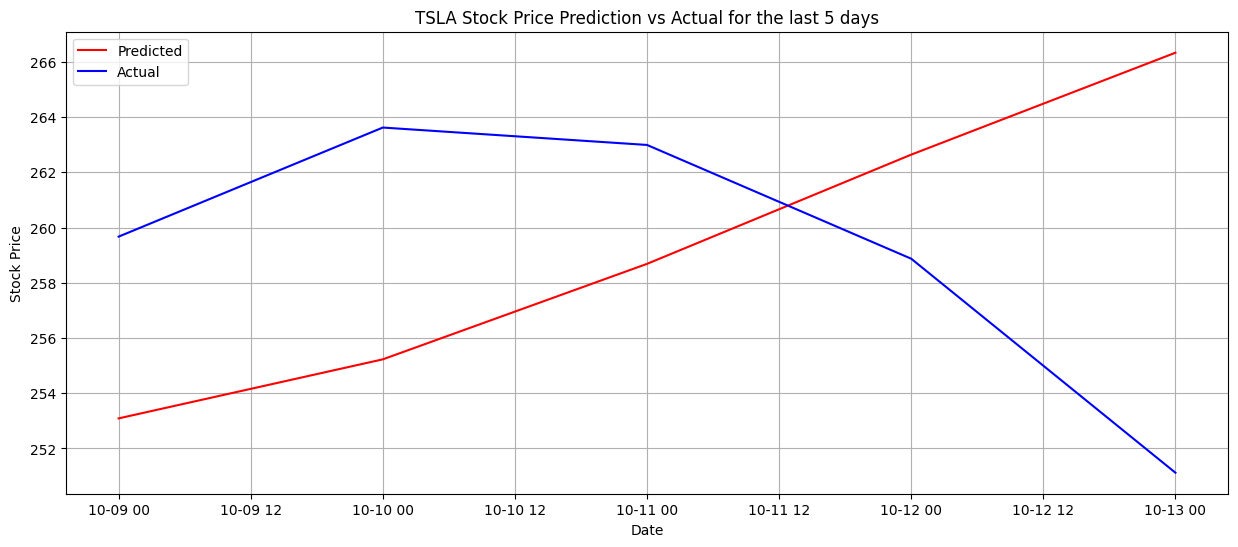

BO is [[6.4e+01 2.0e+00 2.0e-01 1.0e-03 4.0e+01]], with loss of [38.26199058]
Next suggested query point by UCB: 64, 2, 0.2, 0.001, 100
[[6.4e+01 2.0e+00 3.0e-01 1.0e-02 3.0e+01]
 [6.4e+01 2.0e+00 2.0e-01 1.0e-03 4.0e+01]] [[84.5750988 ]
 [38.26199058]]
Epoch 0/100 - Training loss: 0.0532, Validation loss: 0.0129
Epoch 10/100 - Training loss: 0.0142, Validation loss: 0.0044
Epoch 20/100 - Training loss: 0.0091, Validation loss: 0.0039
Epoch 30/100 - Training loss: 0.0087, Validation loss: 0.0034
Epoch 40/100 - Training loss: 0.0076, Validation loss: 0.0032
Epoch 50/100 - Training loss: 0.0072, Validation loss: 0.0033
Epoch 60/100 - Training loss: 0.0063, Validation loss: 0.0033
Epoch 70/100 - Training loss: 0.0067, Validation loss: 0.0031
Epoch 80/100 - Training loss: 0.0064, Validation loss: 0.0032
Epoch 90/100 - Training loss: 0.0061, Validation loss: 0.0029


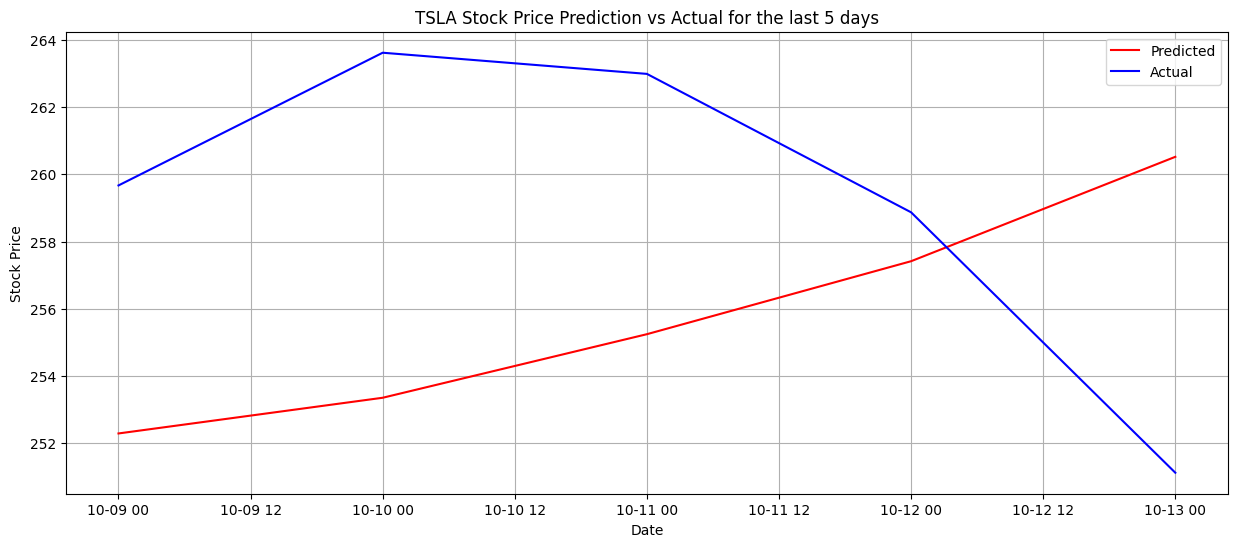

BO is [[6.4e+01 2.0e+00 2.0e-01 1.0e-03 1.0e+02]], with loss of [36.25373605]
Next suggested query point by UCB: 64, 2, 0.2, 0.001, 50
[[6.4e+01 2.0e+00 3.0e-01 1.0e-02 3.0e+01]
 [6.4e+01 2.0e+00 2.0e-01 1.0e-03 4.0e+01]
 [6.4e+01 2.0e+00 2.0e-01 1.0e-03 1.0e+02]] [[84.5750988 ]
 [38.26199058]
 [36.25373605]]
Epoch 0/50 - Training loss: 0.0557, Validation loss: 0.0087
Epoch 10/50 - Training loss: 0.0139, Validation loss: 0.0040
Epoch 20/50 - Training loss: 0.0095, Validation loss: 0.0037
Epoch 30/50 - Training loss: 0.0075, Validation loss: 0.0035
Epoch 40/50 - Training loss: 0.0072, Validation loss: 0.0036


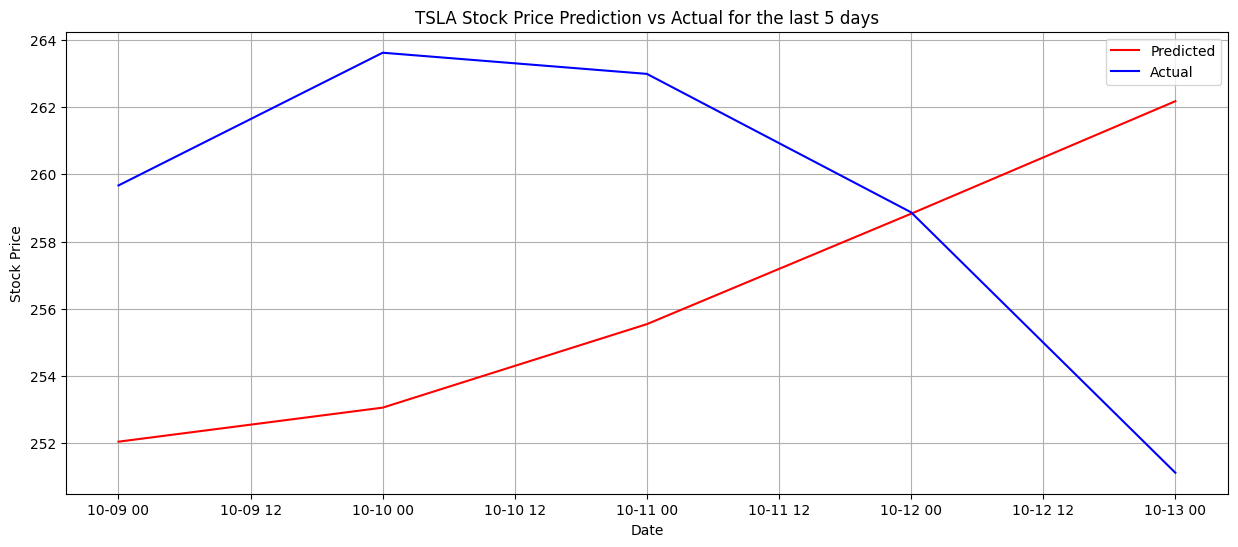

BO is [[6.4e+01 2.0e+00 2.0e-01 1.0e-03 5.0e+01]], with loss of [36.73447111]
Next suggested query point by UCB: 64, 2, 0.2, 0.001, 70
[[6.4e+01 2.0e+00 3.0e-01 1.0e-02 3.0e+01]
 [6.4e+01 2.0e+00 2.0e-01 1.0e-03 4.0e+01]
 [6.4e+01 2.0e+00 2.0e-01 1.0e-03 1.0e+02]
 [6.4e+01 2.0e+00 2.0e-01 1.0e-03 5.0e+01]] [[84.5750988 ]
 [38.26199058]
 [36.25373605]
 [36.73447111]]
Epoch 0/70 - Training loss: 0.0506, Validation loss: 0.0085
Epoch 10/70 - Training loss: 0.0149, Validation loss: 0.0048
Epoch 20/70 - Training loss: 0.0098, Validation loss: 0.0038
Epoch 30/70 - Training loss: 0.0079, Validation loss: 0.0038
Epoch 40/70 - Training loss: 0.0073, Validation loss: 0.0033
Epoch 50/70 - Training loss: 0.0066, Validation loss: 0.0032
Epoch 60/70 - Training loss: 0.0064, Validation loss: 0.0031


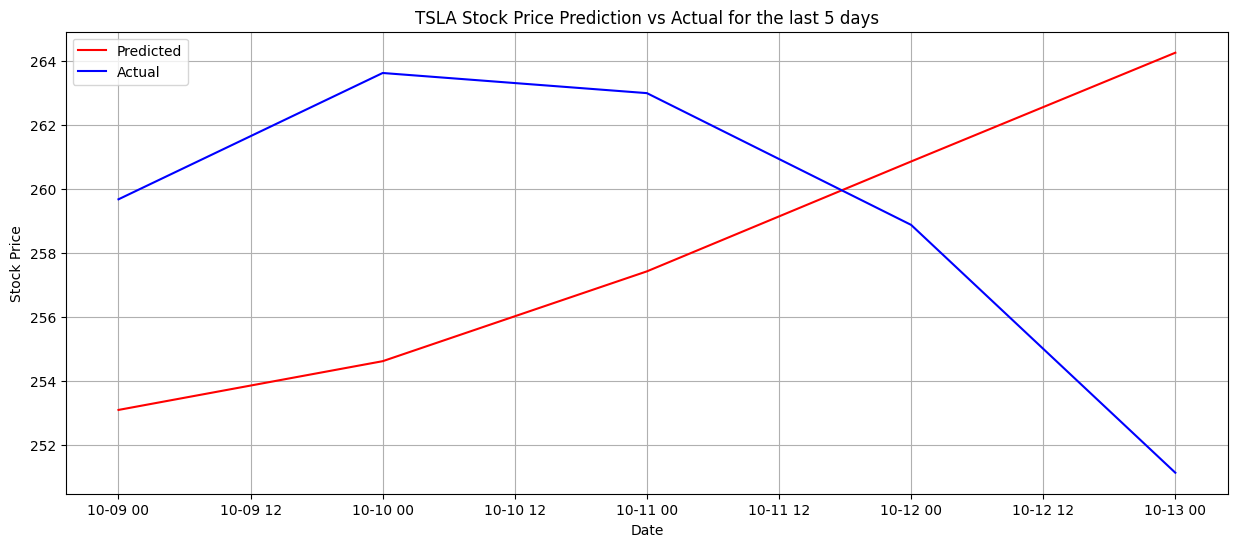

BO is [[6.4e+01 2.0e+00 2.0e-01 1.0e-03 7.0e+01]], with loss of [36.28810263]
Next suggested query point by UCB: 288, 2, 0.2, 0.001, 30
[[6.4e+01 2.0e+00 3.0e-01 1.0e-02 3.0e+01]
 [6.4e+01 2.0e+00 2.0e-01 1.0e-03 4.0e+01]
 [6.4e+01 2.0e+00 2.0e-01 1.0e-03 1.0e+02]
 [6.4e+01 2.0e+00 2.0e-01 1.0e-03 5.0e+01]
 [6.4e+01 2.0e+00 2.0e-01 1.0e-03 7.0e+01]] [[84.5750988 ]
 [38.26199058]
 [36.25373605]
 [36.73447111]
 [36.28810263]]
Epoch 0/30 - Training loss: 0.0328, Validation loss: 0.0230
Epoch 10/30 - Training loss: 0.0779, Validation loss: 0.0246
Epoch 20/30 - Training loss: 0.0496, Validation loss: 0.0304


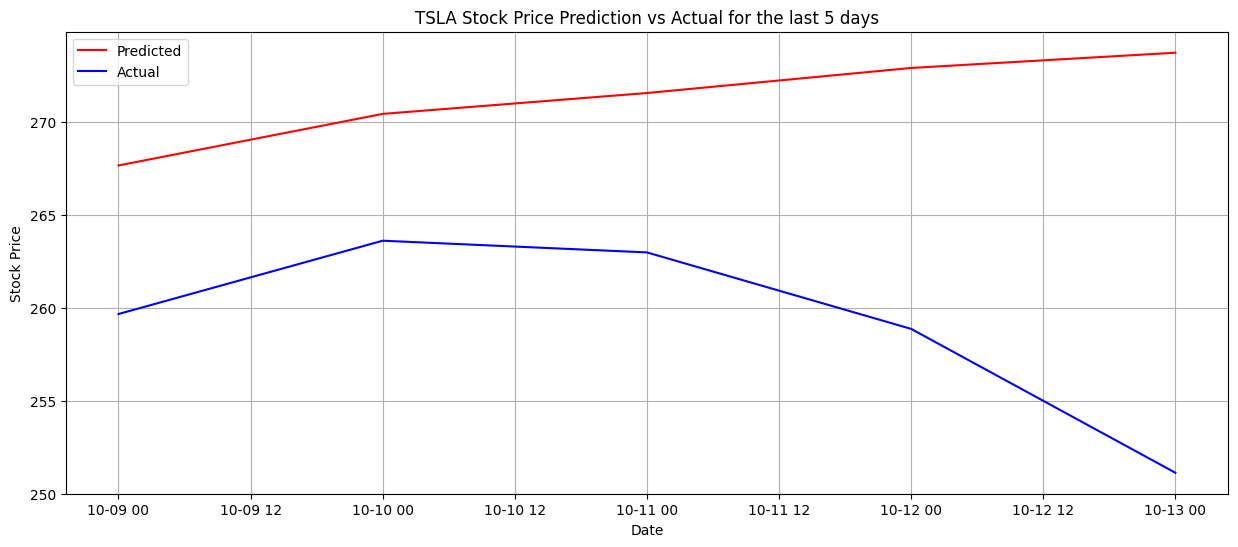

BO is [[2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]], with loss of [60.1109608]
Next suggested query point by UCB: 64, 2, 0.2, 0.001, 60
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]] [[84.5750988 ]
 [38.26199058]
 [36.25373605]
 [36.73447111]
 [36.28810263]
 [60.1109608 ]]
Epoch 0/60 - Training loss: 0.0516, Validation loss: 0.0088
Epoch 10/60 - Training loss: 0.0137, Validation loss: 0.0037
Epoch 20/60 - Training loss: 0.0089, Validation loss: 0.0038
Epoch 30/60 - Training loss: 0.0078, Validation loss: 0.0034
Epoch 40/60 - Training loss: 0.0079, Validation loss: 0.0032
Epoch 50/60 - Training loss: 0.0074, Validation loss: 0.0032


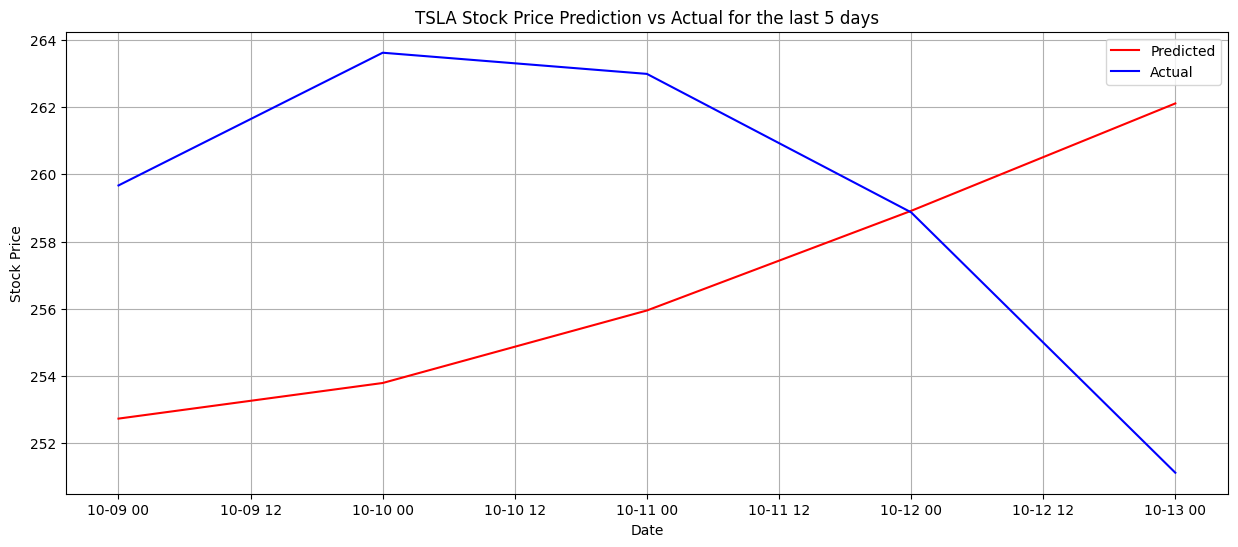

BO is [[6.4e+01 2.0e+00 2.0e-01 1.0e-03 6.0e+01]], with loss of [34.84457113]
Next suggested query point by UCB: 288, 2, 0.2, 0.001, 100
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]] [[84.5750988 ]
 [38.26199058]
 [36.25373605]
 [36.73447111]
 [36.28810263]
 [60.1109608 ]
 [34.84457113]]
Epoch 0/100 - Training loss: 0.0328, Validation loss: 0.0231
Epoch 10/100 - Training loss: 0.0363, Validation loss: 0.0328
Epoch 20/100 - Training loss: 0.0371, Validation loss: 0.0218
Epoch 30/100 - Training loss: 0.0303, Validation loss: 0.0223
Epoch 40/100 - Training loss: 0.0489, Validation loss: 0.0512
Epoch 50/100 - Training loss: 0.0505, Validation loss: 0.0546
Epoch 60/100 - Training loss: 0.0497, Validation 

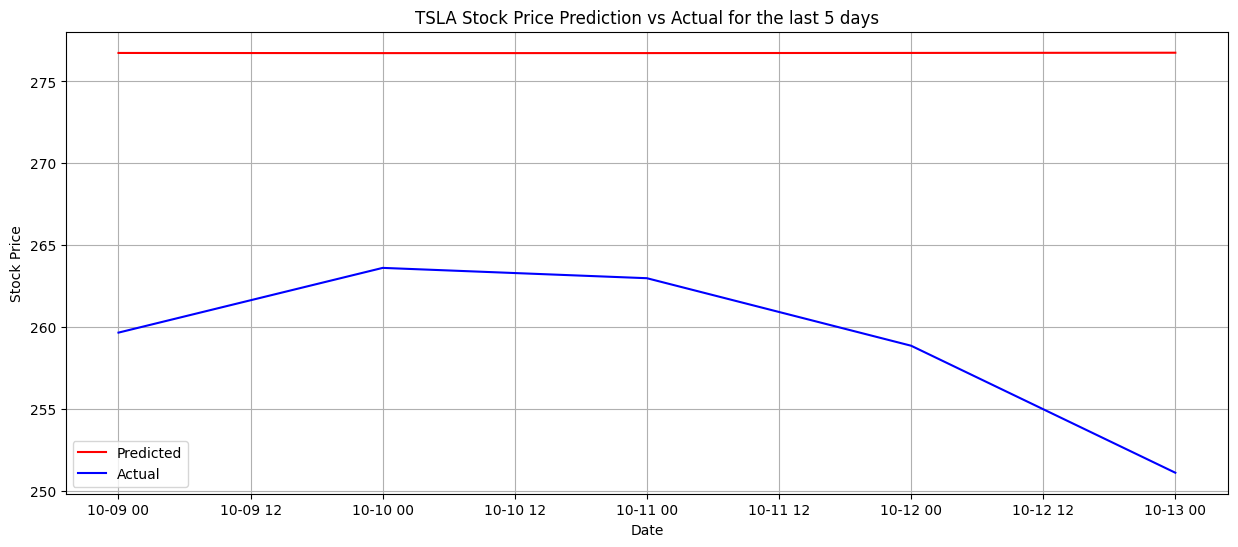

BO is [[2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]], with loss of [87.40827233]
Next suggested query point by UCB: 512, 2, 0.2, 0.001, 30
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]] [[84.5750988 ]
 [38.26199058]
 [36.25373605]
 [36.73447111]
 [36.28810263]
 [60.1109608 ]
 [34.84457113]
 [87.40827233]]
Epoch 0/30 - Training loss: 0.0333, Validation loss: 0.0189
Epoch 10/30 - Training loss: 0.0274, Validation loss: 0.0196
Epoch 20/30 - Training loss: 0.0139, Validation loss: 0.0092


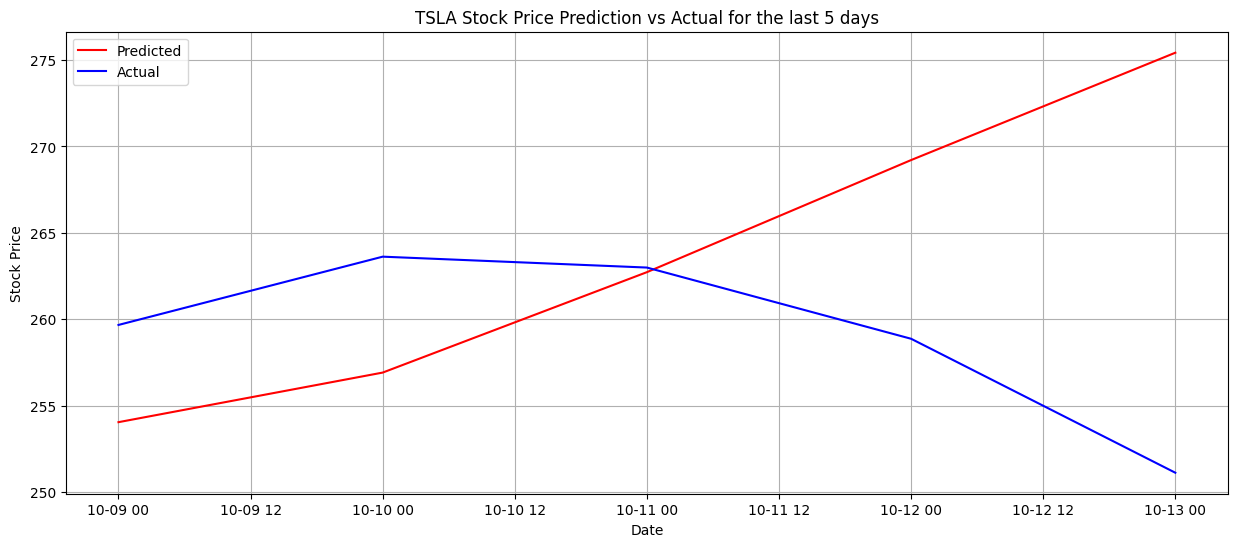

BO is [[5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]], with loss of [47.23610726]
Next suggested query point by UCB: 64, 2, 0.2, 0.001, 80
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]] [[84.5750988 ]
 [38.26199058]
 [36.25373605]
 [36.73447111]
 [36.28810263]
 [60.1109608 ]
 [34.84457113]
 [87.40827233]
 [47.23610726]]
Epoch 0/80 - Training loss: 0.0499, Validation loss: 0.0117
Epoch 10/80 - Training loss: 0.0150, Validation loss: 0.0048
Epoch 20/80 - Training loss: 0.0090, Validation loss: 0.0041
Epoch 30/80 - Training loss: 0.0082, Validation loss: 0.0036
Epoch 40/80 - Training loss: 0.0078, Validation 

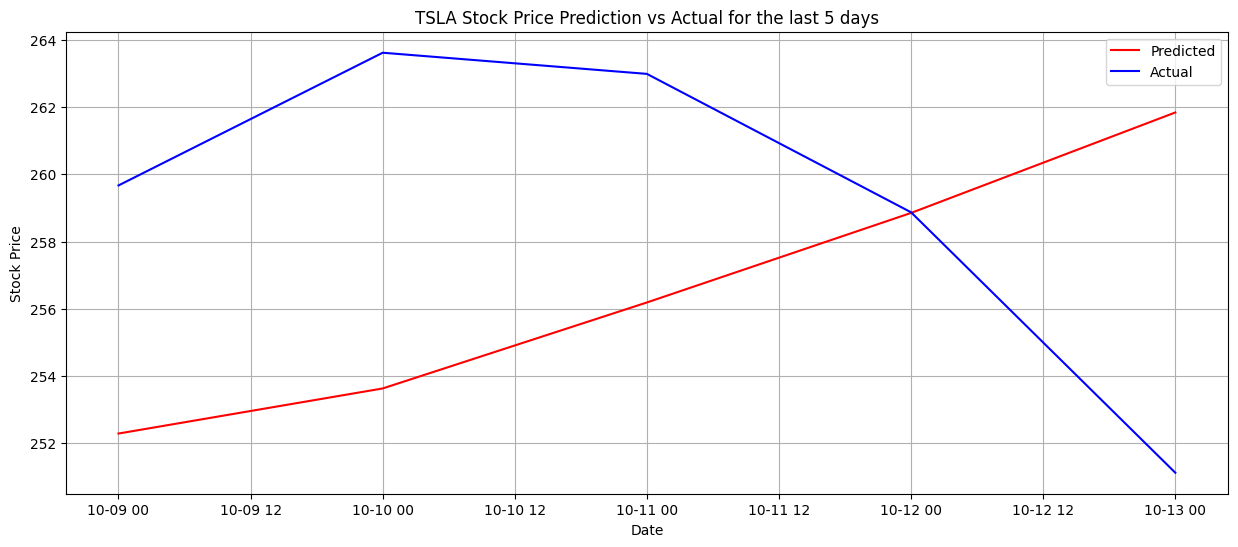

BO is [[6.4e+01 2.0e+00 2.0e-01 1.0e-03 8.0e+01]], with loss of [34.91845424]
Next suggested query point by UCB: 64, 2, 0.2, 0.001, 90
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]] [[84.5750988 ]
 [38.26199058]
 [36.25373605]
 [36.73447111]
 [36.28810263]
 [60.1109608 ]
 [34.84457113]
 [87.40827233]
 [47.23610726]
 [34.91845424]]
Epoch 0/90 - Training loss: 0.0507, Validation loss: 0.0156
Epoch 10/90 - Training loss: 0.0159, Validation loss: 0.0053
Epoch 20/90 - Training loss: 0.0095, Validation loss: 0.0042
Epoch 30/90 - Training loss: 0.0082, Validation los

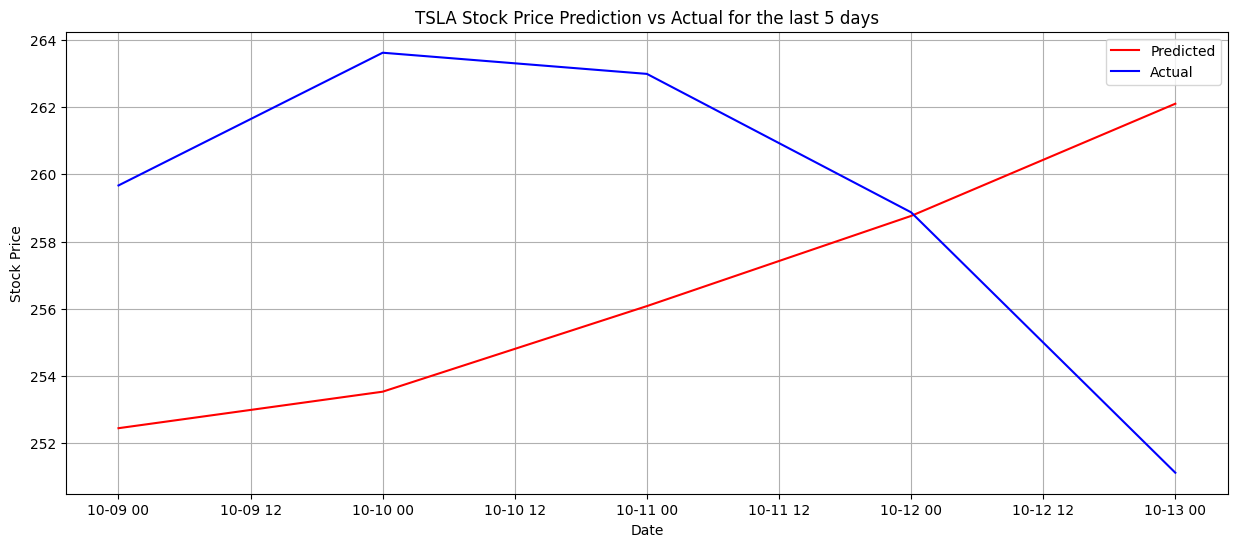

BO is [[6.4e+01 2.0e+00 2.0e-01 1.0e-03 9.0e+01]], with loss of [35.31284573]
Next suggested query point by UCB: 288, 2, 0.2, 0.001, 40
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]] [[84.5750988 ]
 [38.26199058]
 [36.25373605]
 [36.73447111]
 [36.28810263]
 [60.1109608 ]
 [34.84457113]
 [87.40827233]
 [47.23610726]
 [34.91845424]
 [35.31284573]]
Epoch 0/40 - Training loss: 0.0327, Validation loss: 0.0262
Epoch 10/40 - Training loss: 0.0497, Validation loss: 0.0143
Epoch 20/40 - Training loss: 0.0135, Validation 

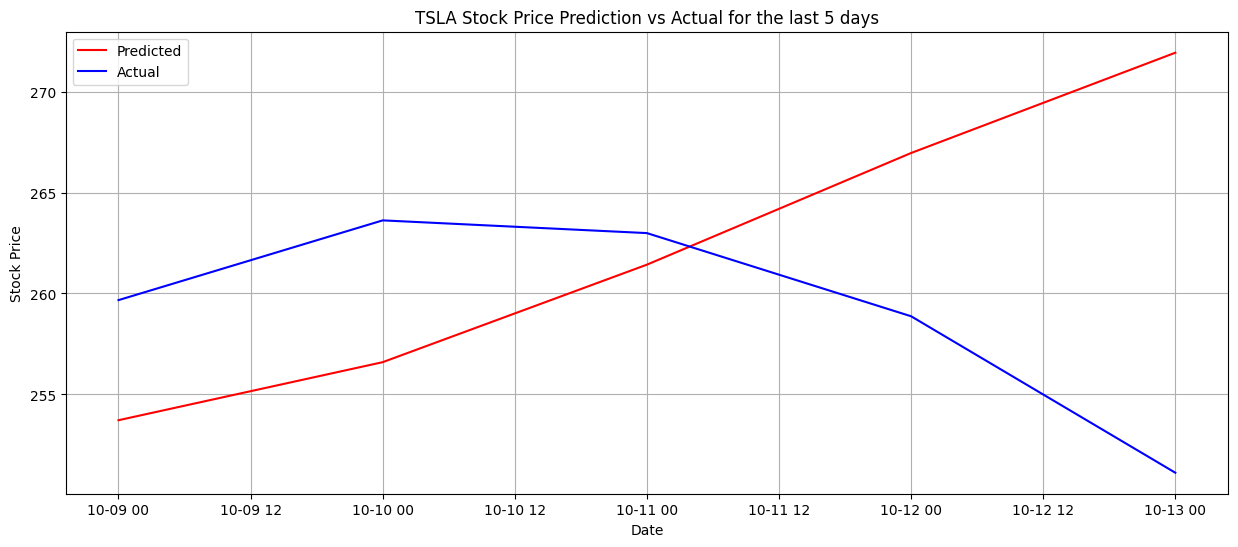

BO is [[2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]], with loss of [43.42869938]
Next suggested query point by UCB: 288, 2, 0.2, 0.001, 50
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]] [[84.5750988 ]
 [38.26199058]
 [36.25373605]
 [36.73447111]
 [36.28810263]
 [60.1109608 ]
 [34.84457113]
 [87.40827233]
 [47.23610726]
 [34.91845424]
 [35.31284573]
 [43.42869938]]
Epoch 0/50 - Training loss: 0.0324, Validation loss: 0.0187
Epoch 10/50 - Training loss: 0.0746, Vali

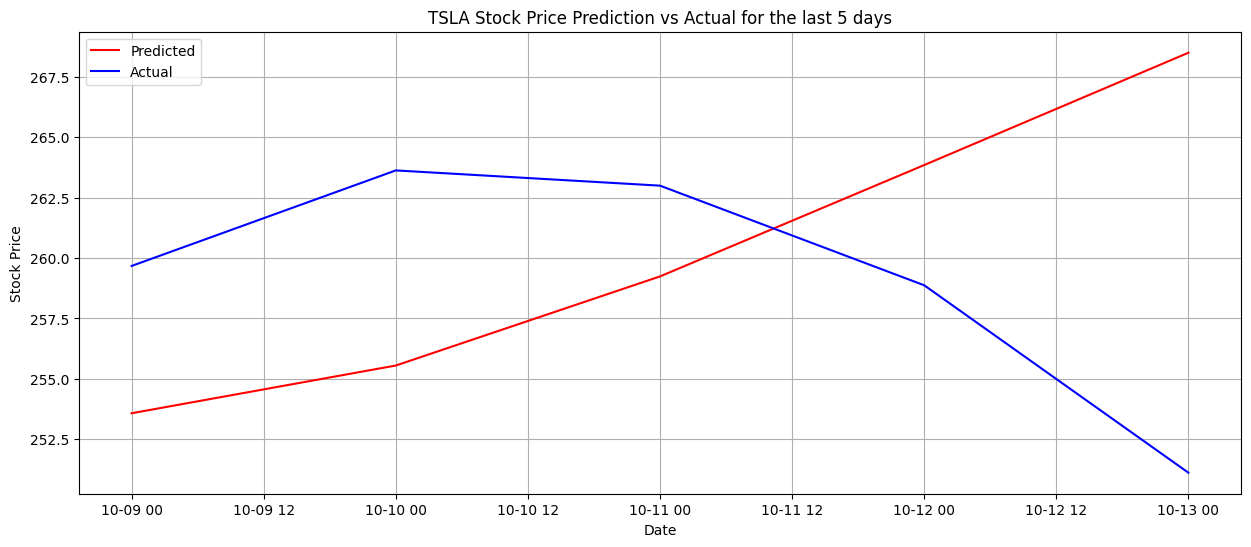

BO is [[2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]], with loss of [40.25002872]
Next suggested query point by UCB: 512, 3, 0.2, 0.001, 100
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]] [[84.5750988 ]
 [38.26199058]
 [36.25373605]
 [36.73447111]
 [36.28810263]
 [60.1109608 ]
 [34.84457113]
 [87.40827233]
 [47.23610726]
 [34.91845424]
 [35.31284573]
 [43.42869938]
 [40.25002872]]
Epoch 0/100 - Training loss: 0.0344, 

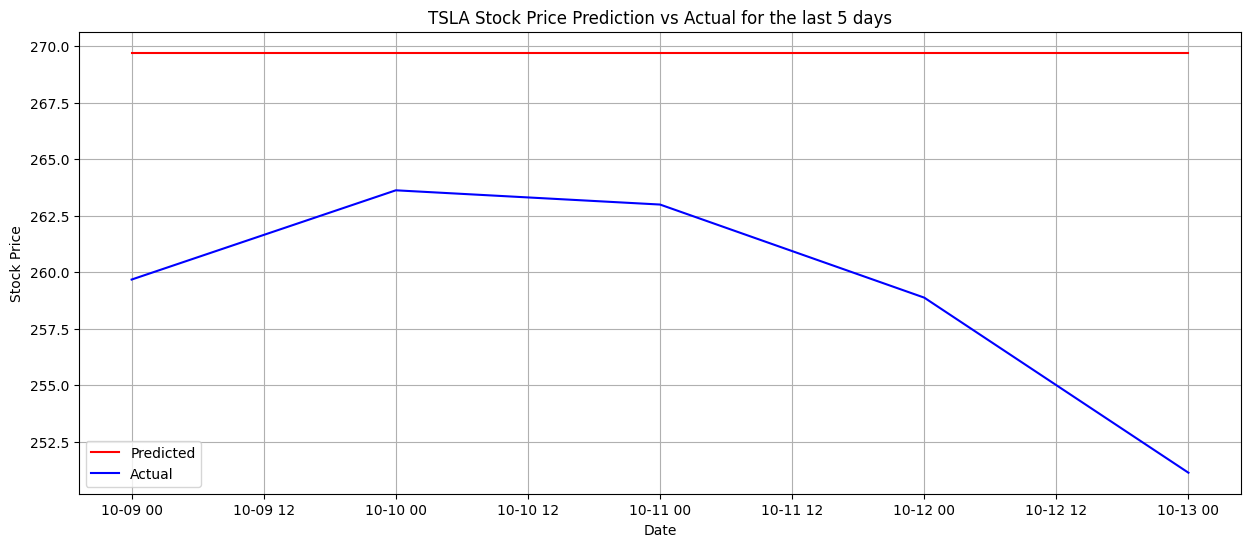

BO is [[5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]], with loss of [52.27895883]
Next suggested query point by UCB: 512, 3, 0.5, 0.100, 60
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]] [[84.5750988 ]
 [38.26199058]
 [36.25373605]
 [36.73447111]
 [36.28810263]
 [60.1109608 ]
 [34.84457113]
 [87.40827233]
 [47.23610726]
 [34.91845424]
 [35.31284573]
 [43.42869938]
 [40.2

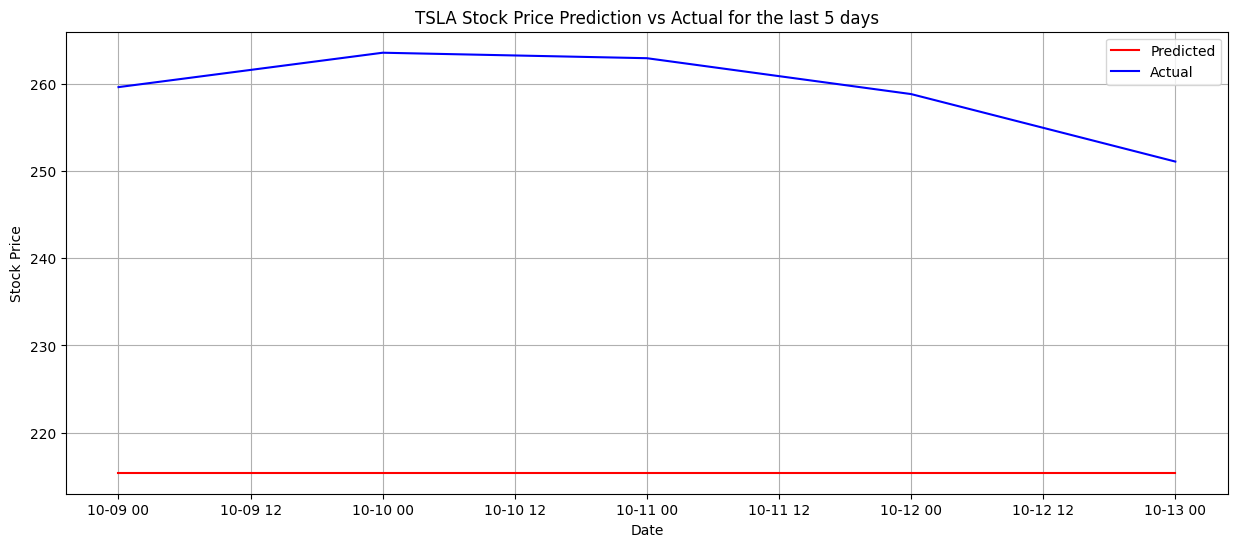

BO is [[5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]], with loss of [219.36584647]
Next suggested query point by Expected Improvement: 288, 3, 0.5, 0.100, 70
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]] [[ 84.5750988 ]
 [ 38.26199058]
 [ 36.25373605]
 [ 36.73447111]
 [ 36.28810263]
 [ 60.1109608 ]
 [ 34.84457113]
 [ 87.40

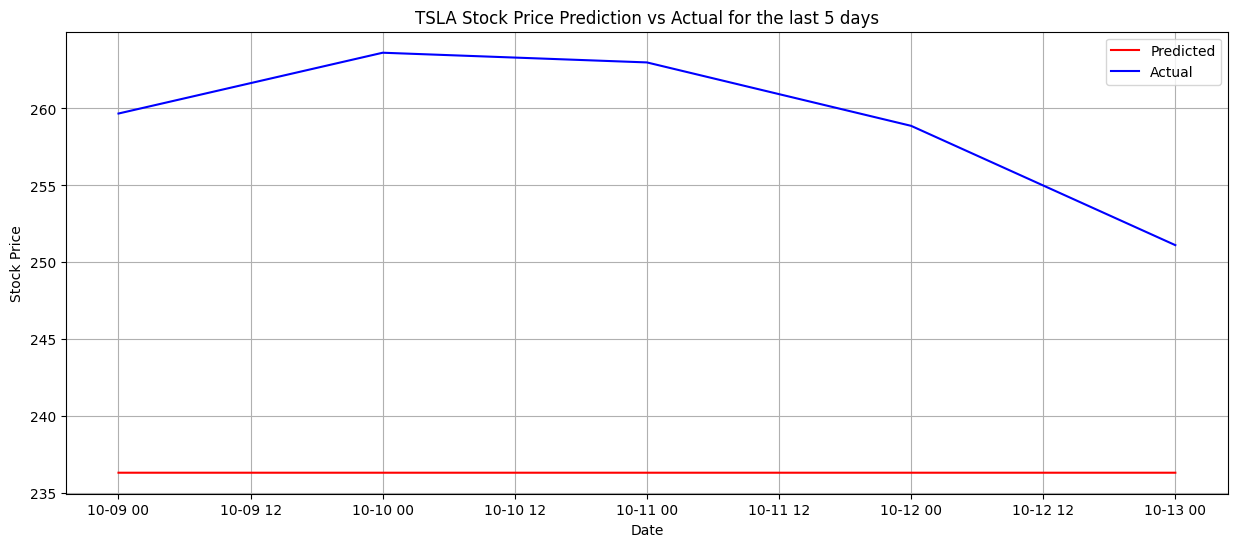

BO is [[2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]], with loss of [114.5892282]
Next suggested query point by Probability of Improvement: 512, 2, 0.2, 0.000, 80
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]] [[ 84.5750988 ]
 [ 38.26199058]
 [ 36.25373605]
 [ 36.73447111]
 [ 

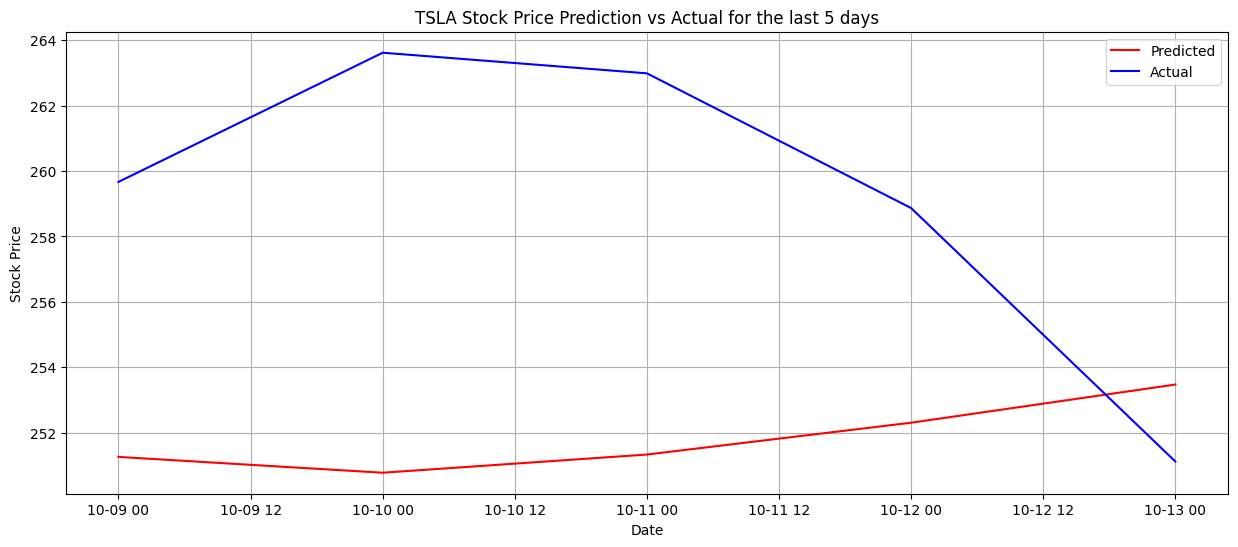

BO is [[5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]], with loss of [41.82903574]
Next suggested query point by UCB: 288, 2, 0.2, 0.001, 60
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]] [[ 84.5750988 ]
 [ 38.26199058]
 [ 36.2537

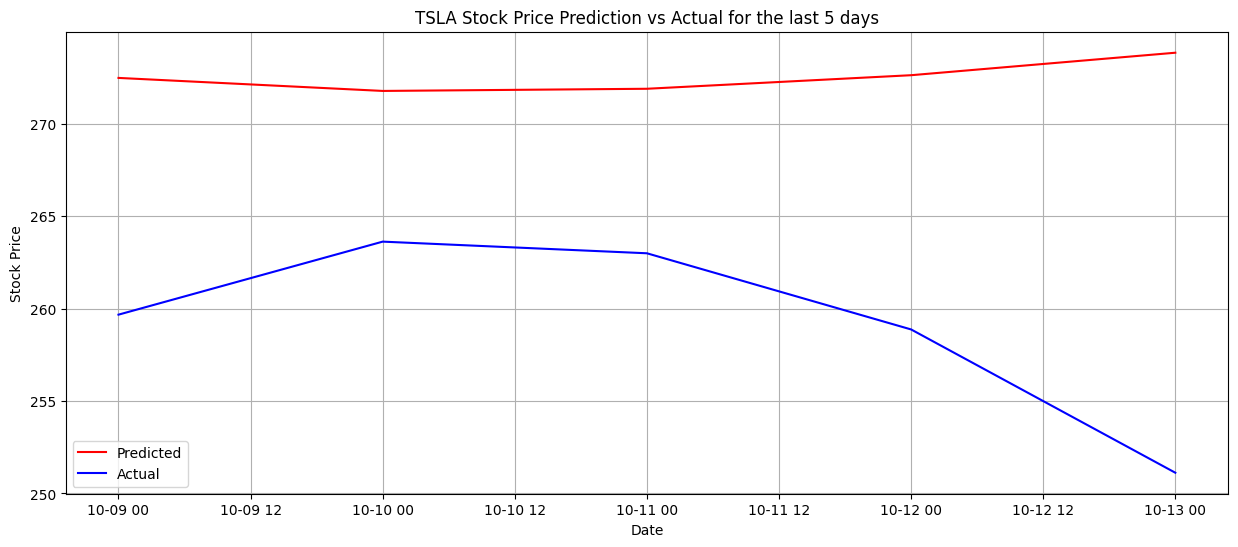

BO is [[2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]], with loss of [66.3261065]
Next suggested query point by UCB: 288, 2, 0.2, 0.001, 80
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+

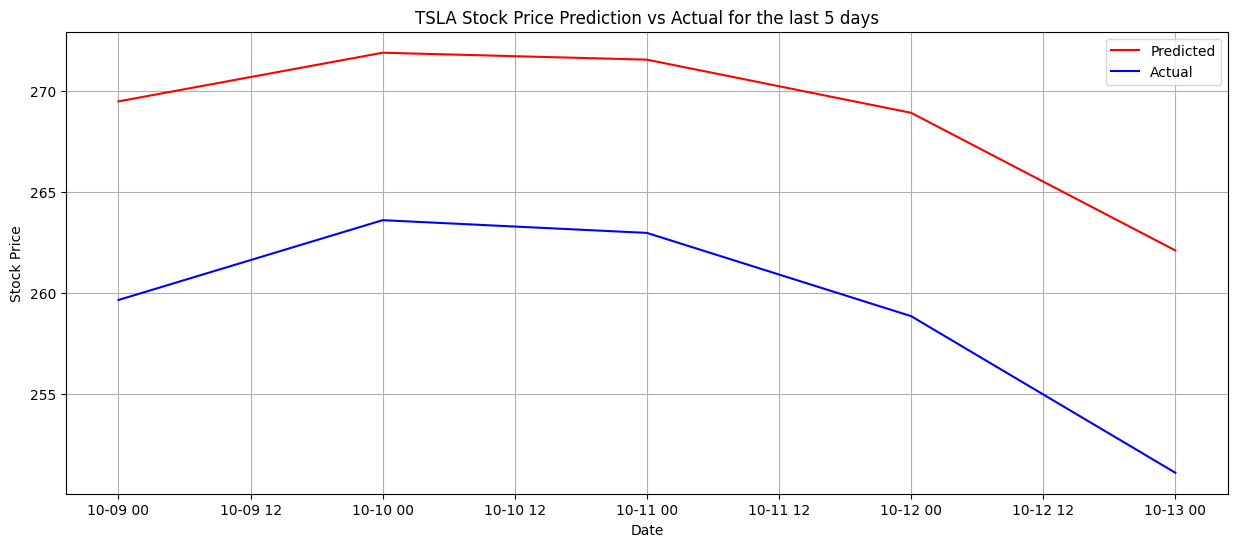

BO is [[2.88e+02 2.00e+00 2.00e-01 1.00e-03 8.00e+01]], with loss of [47.76066325]
Next suggested query point by UCB: 288, 2, 0.2, 0.001, 90
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e

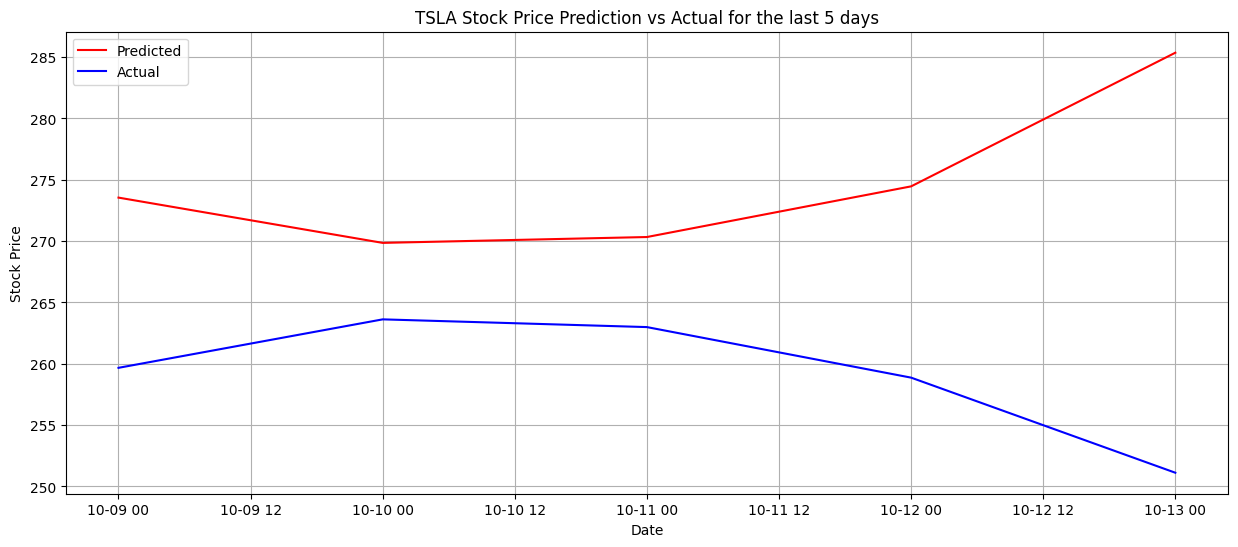

BO is [[2.88e+02 2.00e+00 2.00e-01 1.00e-03 9.00e+01]], with loss of [77.26930693]
Next suggested query point by UCB: 512, 2, 0.2, 0.001, 40
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e

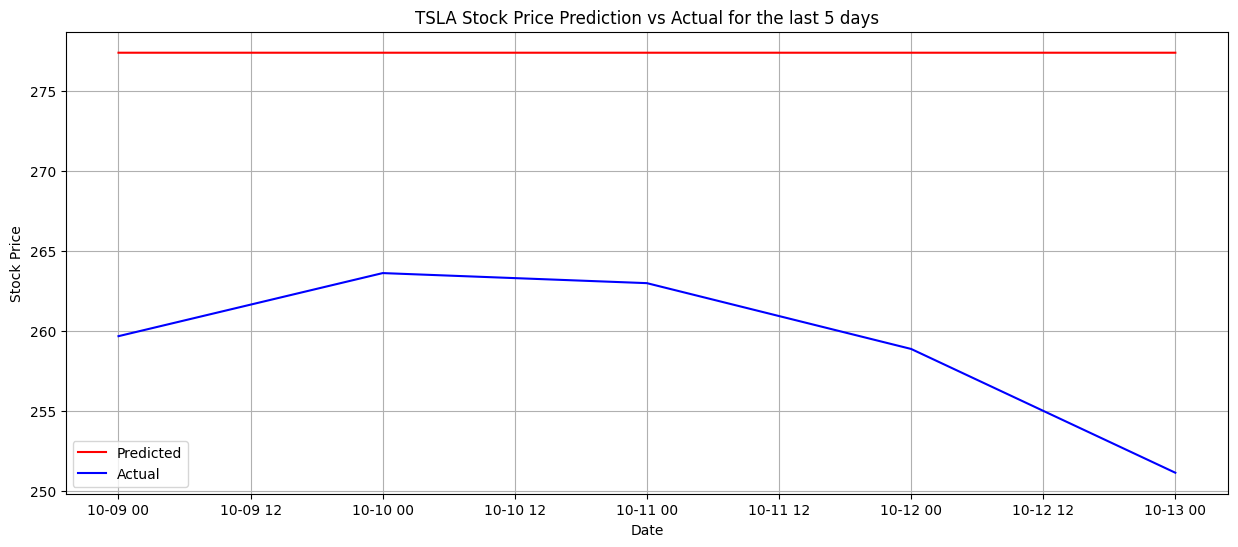

BO is [[5.12e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]], with loss of [90.81942985]
Next suggested query point by UCB: 512, 2, 0.2, 0.001, 50
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e

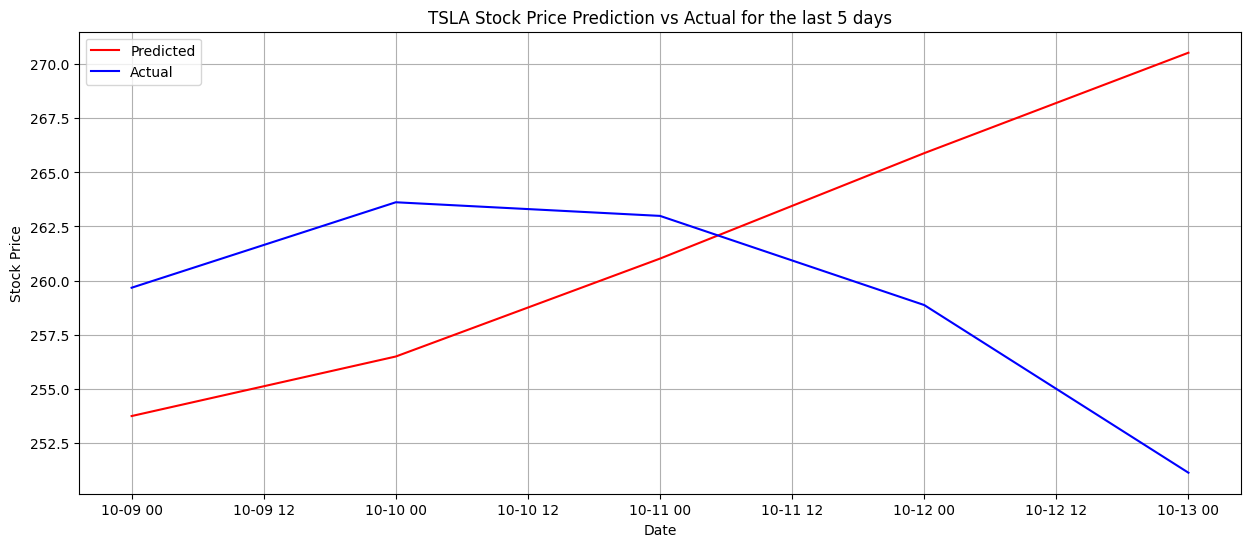

BO is [[5.12e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]], with loss of [41.46351616]
Next suggested query point by UCB: 512, 2, 0.5, 0.100, 90
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e

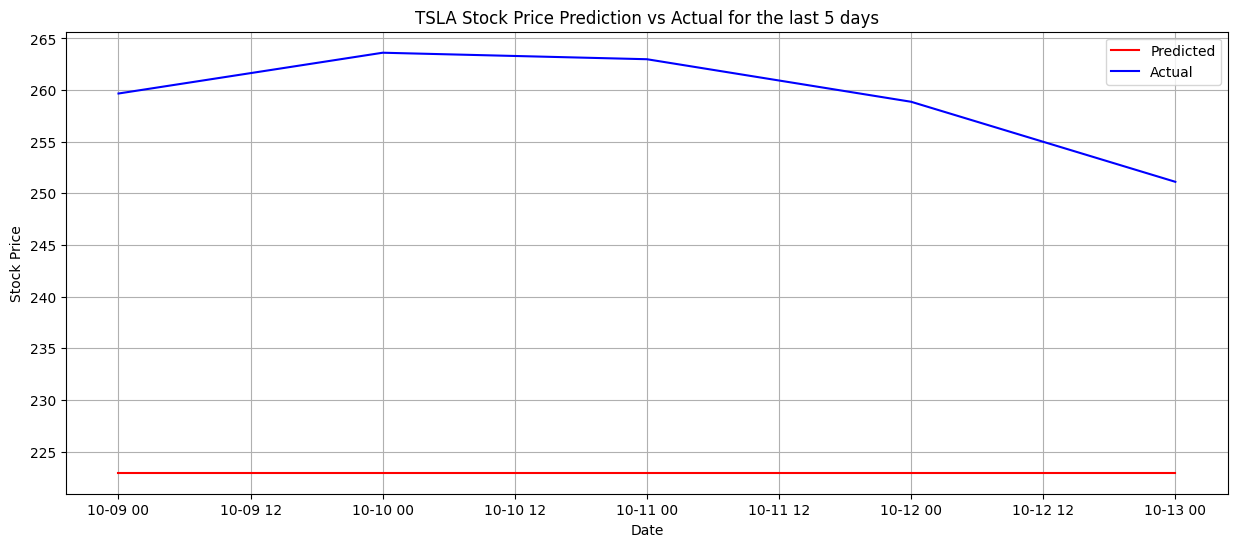

BO is [[5.12e+02 2.00e+00 5.00e-01 1.00e-01 9.00e+01]], with loss of [181.53384223]
Next suggested query point by Probability of Improvement: 64, 3, 0.5, 0.100, 60
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 

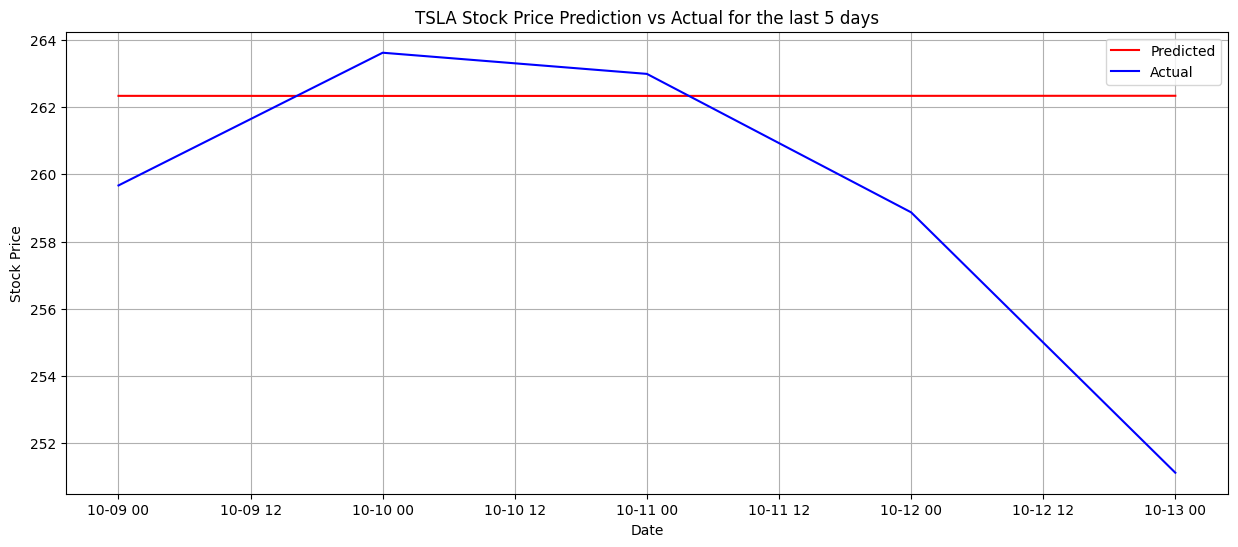

BO is [[64.   3.   0.5  0.1 60. ]], with loss of [19.29305176]
Next suggested query point by Probability of Improvement: 64, 2, 0.2, 0.000, 30
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.0

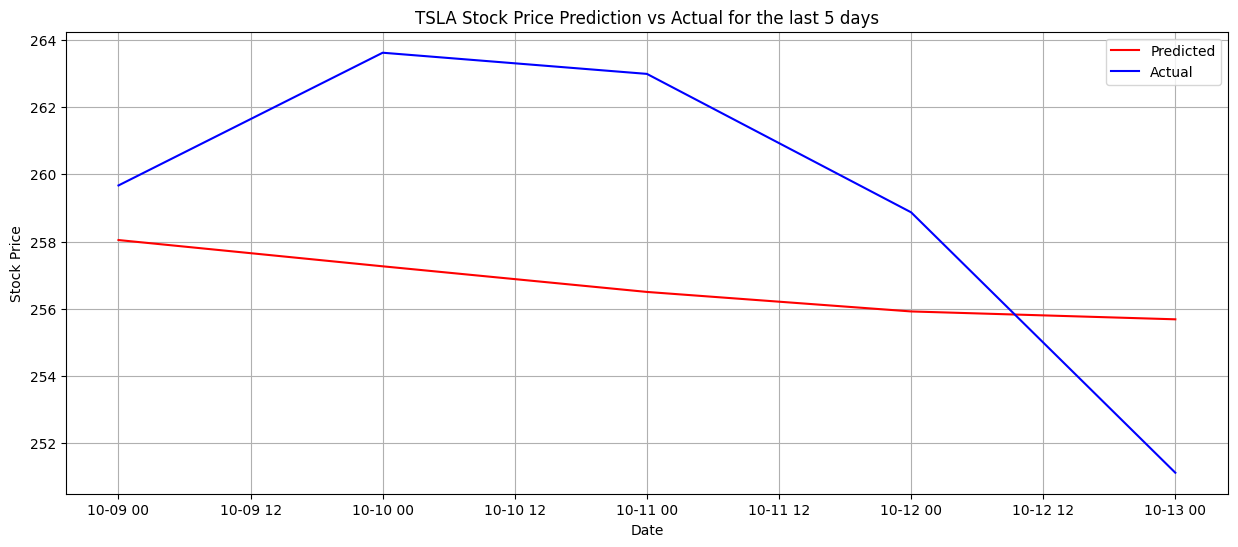

BO is [[6.4e+01 2.0e+00 2.0e-01 1.0e-04 3.0e+01]], with loss of [21.98702053]
Next suggested query point by UCB: 64, 2, 0.2, 0.001, 30
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 

C:\Users\keith\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 0/30 - Training loss: 0.0527, Validation loss: 0.0091
Epoch 10/30 - Training loss: 0.0130, Validation loss: 0.0041
Epoch 20/30 - Training loss: 0.0094, Validation loss: 0.0038


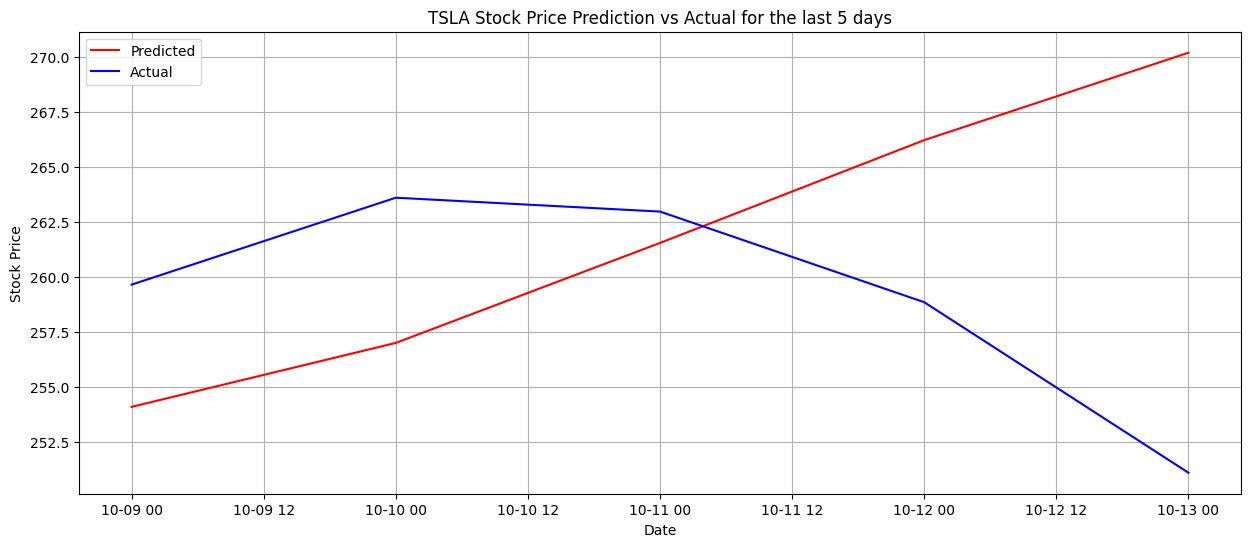

BO is [[6.4e+01 2.0e+00 2.0e-01 1.0e-03 3.0e+01]], with loss of [40.0387215]
Next suggested query point by UCB: 64, 2, 0.2, 0.034, 30
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [

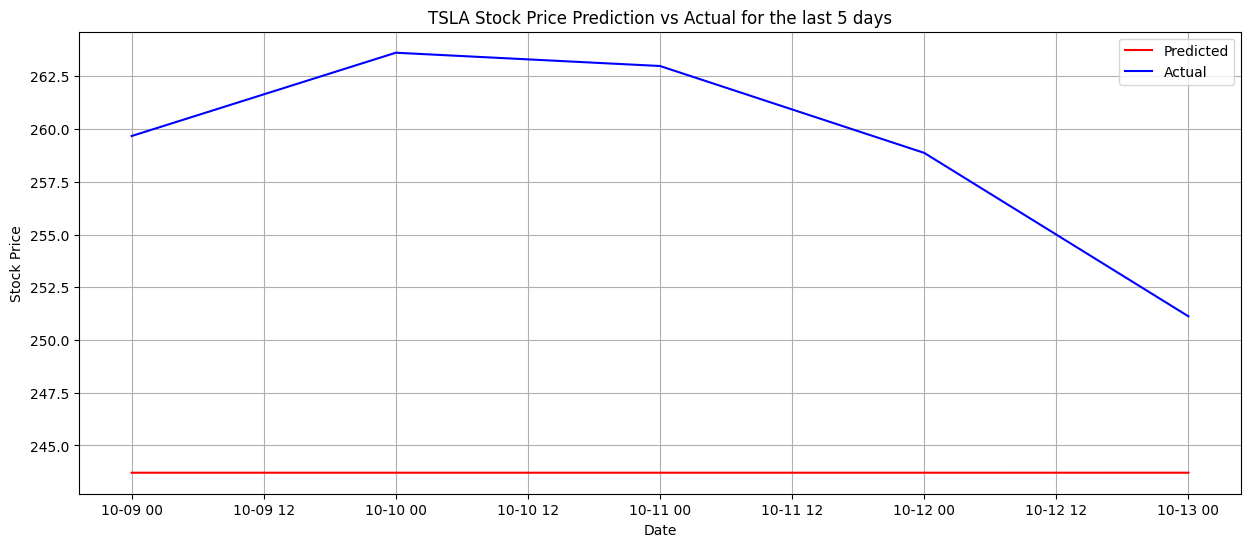

BO is [[6.4e+01 2.0e+00 2.0e-01 3.4e-02 3.0e+01]], with loss of [77.74818165]
Next suggested query point by UCB: 64, 2, 0.2, 0.034, 40
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 

C:\Users\keith\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 0/40 - Training loss: 0.0276, Validation loss: 0.0143
Epoch 10/40 - Training loss: 0.0435, Validation loss: 0.0341
Epoch 20/40 - Training loss: 0.0436, Validation loss: 0.0346
Epoch 30/40 - Training loss: 0.0290, Validation loss: 0.0164


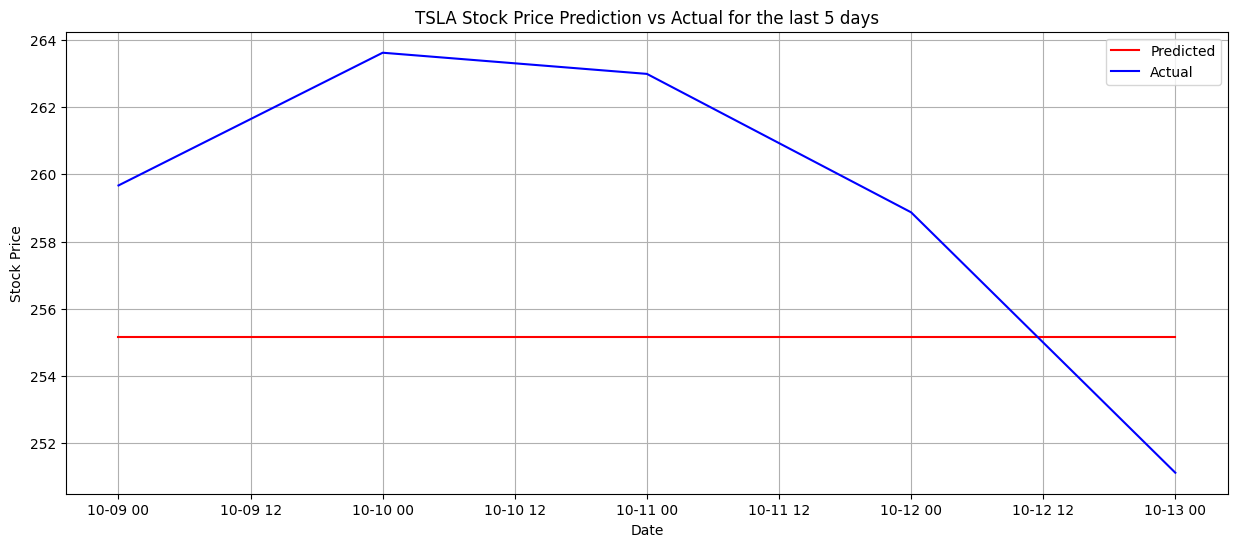

BO is [[6.4e+01 2.0e+00 2.0e-01 3.4e-02 4.0e+01]], with loss of [28.57576755]
Next suggested query point by UCB: 64, 2, 0.2, 0.034, 50
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 

C:\Users\keith\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 0/50 - Training loss: 0.0291, Validation loss: 0.0171
Epoch 10/50 - Training loss: 0.0234, Validation loss: 0.0172
Epoch 20/50 - Training loss: 0.0276, Validation loss: 0.0127
Epoch 30/50 - Training loss: 0.0278, Validation loss: 0.0121
Epoch 40/50 - Training loss: 0.0264, Validation loss: 0.0123


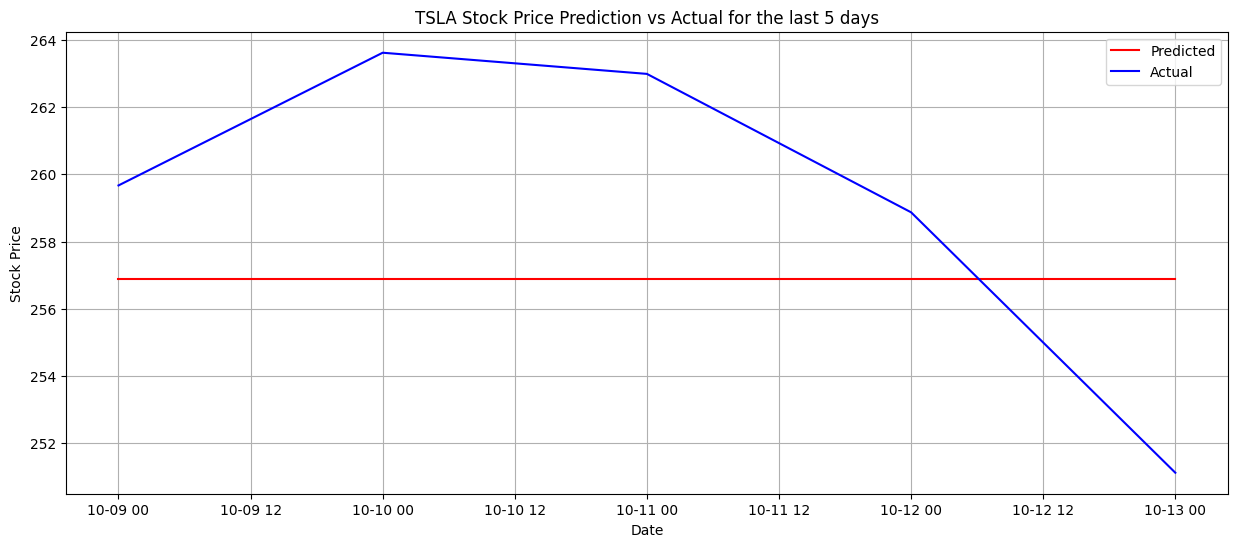

BO is [[6.4e+01 2.0e+00 2.0e-01 3.4e-02 5.0e+01]], with loss of [23.3327655]
Next suggested query point by UCB: 64, 2, 0.2, 0.034, 60
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [

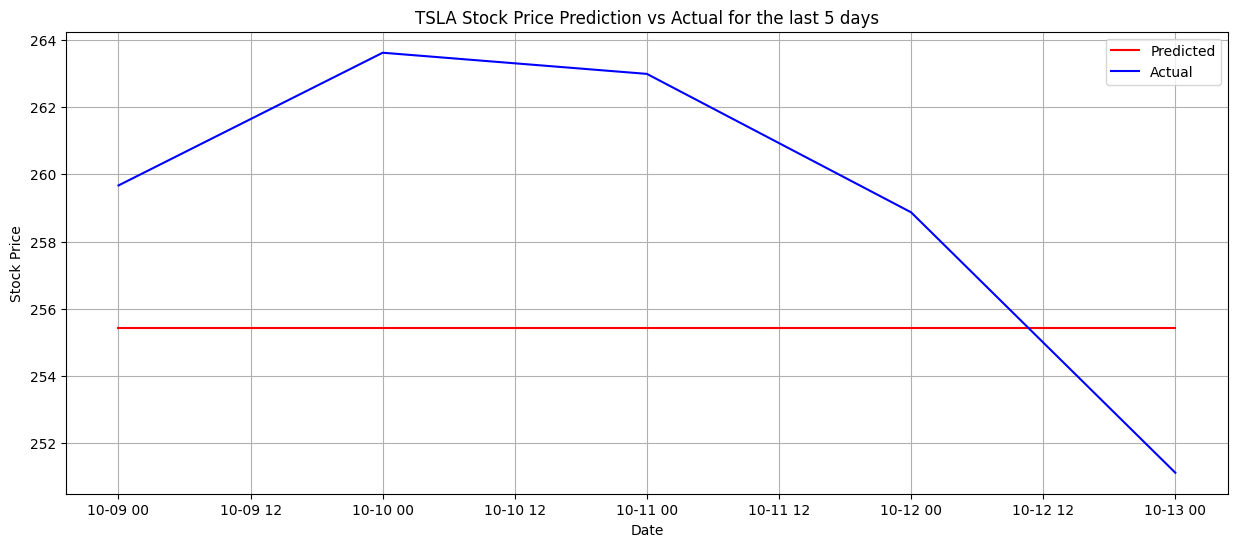

BO is [[6.4e+01 2.0e+00 2.0e-01 3.4e-02 6.0e+01]], with loss of [27.76106555]
Next suggested query point by UCB: 64, 2, 0.2, 0.034, 70
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 

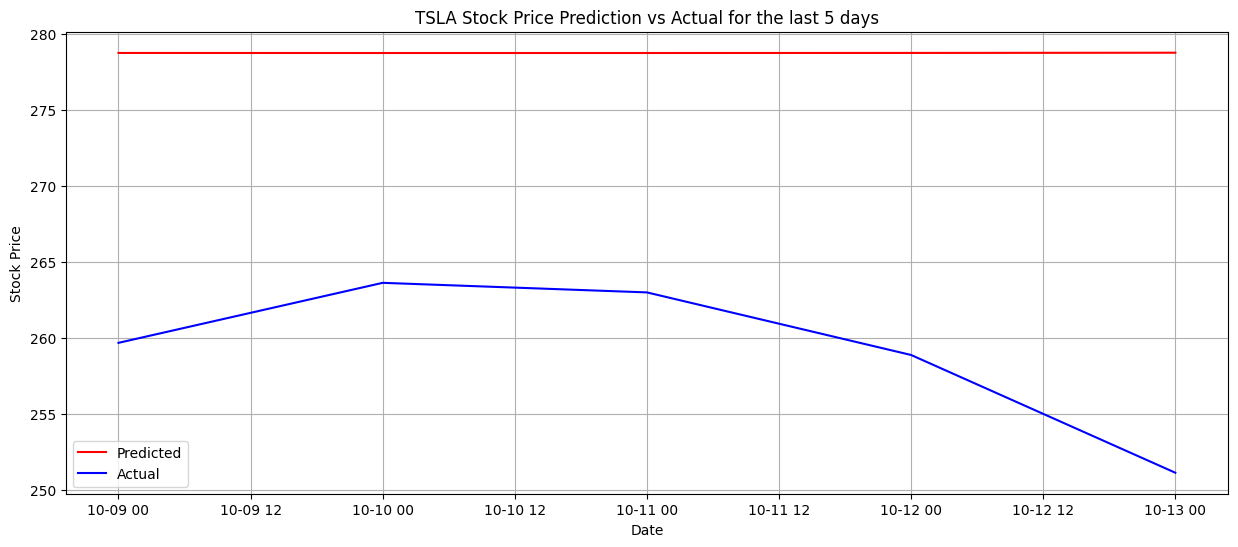

BO is [[6.4e+01 2.0e+00 2.0e-01 3.4e-02 7.0e+01]], with loss of [97.49827732]
Next suggested query point by UCB: 64, 2, 0.2, 0.034, 80
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 

C:\Users\keith\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 0/80 - Training loss: 0.0258, Validation loss: 0.0218
Epoch 10/80 - Training loss: 0.0436, Validation loss: 0.0345
Epoch 20/80 - Training loss: 0.0437, Validation loss: 0.0346
Epoch 30/80 - Training loss: 0.0291, Validation loss: 0.0165
Epoch 40/80 - Training loss: 0.0284, Validation loss: 0.0165
Epoch 50/80 - Training loss: 0.0291, Validation loss: 0.0165
Epoch 60/80 - Training loss: 0.0323, Validation loss: 0.0094
Epoch 70/80 - Training loss: 0.0291, Validation loss: 0.0130


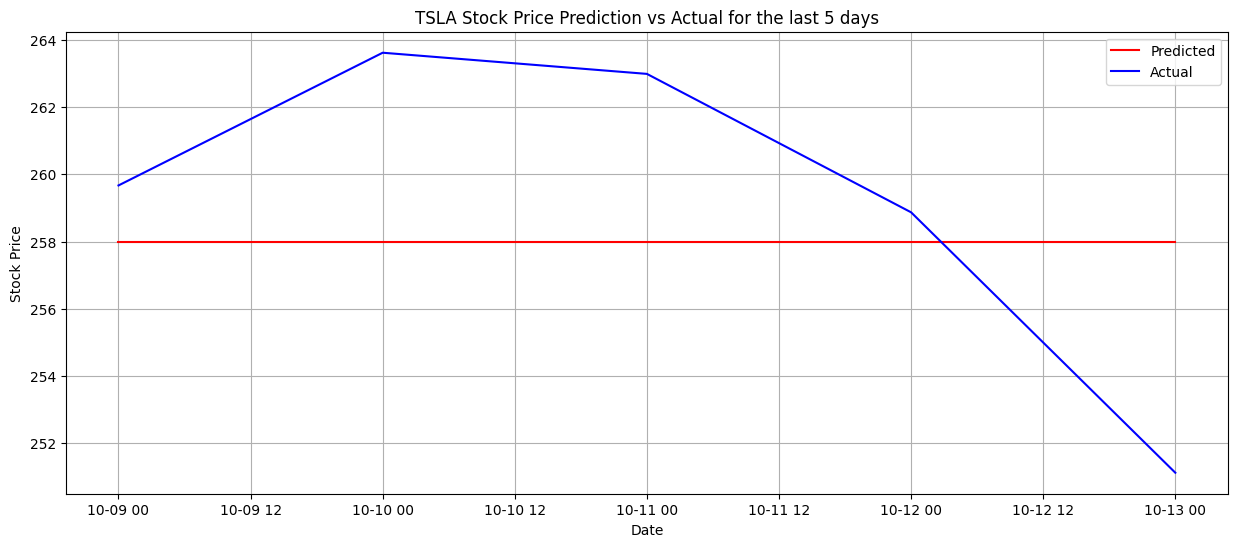

BO is [[6.4e+01 2.0e+00 2.0e-01 3.4e-02 8.0e+01]], with loss of [20.02601464]
Next suggested query point by UCB: 64, 2, 0.2, 0.034, 90
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 

C:\Users\keith\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 0/90 - Training loss: 0.0247, Validation loss: 0.0116
Epoch 10/90 - Training loss: 0.0295, Validation loss: 0.0108
Epoch 20/90 - Training loss: 0.0294, Validation loss: 0.0112
Epoch 30/90 - Training loss: 0.0294, Validation loss: 0.0117
Epoch 40/90 - Training loss: 0.0294, Validation loss: 0.0117
Epoch 50/90 - Training loss: 0.0297, Validation loss: 0.0111
Epoch 60/90 - Training loss: 0.0294, Validation loss: 0.0112
Epoch 70/90 - Training loss: 0.0294, Validation loss: 0.0112
Epoch 80/90 - Training loss: 0.0299, Validation loss: 0.0179


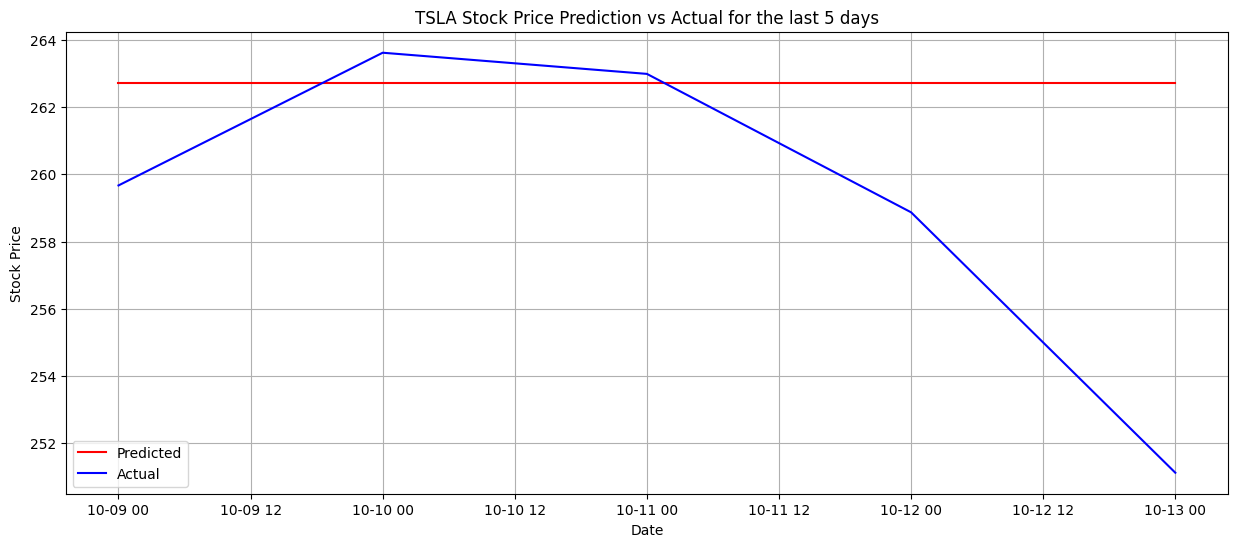

BO is [[6.4e+01 2.0e+00 2.0e-01 3.4e-02 9.0e+01]], with loss of [19.66871484]
Next suggested query point by UCB: 64, 2, 0.2, 0.034, 100
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]


C:\Users\keith\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 0/100 - Training loss: 0.0315, Validation loss: 0.0288
Epoch 10/100 - Training loss: 0.0429, Validation loss: 0.0323
Epoch 20/100 - Training loss: 0.0299, Validation loss: 0.0179
Epoch 30/100 - Training loss: 0.0307, Validation loss: 0.0160
Epoch 40/100 - Training loss: 0.0435, Validation loss: 0.0342
Epoch 50/100 - Training loss: 0.0291, Validation loss: 0.0165
Epoch 60/100 - Training loss: 0.0291, Validation loss: 0.0165
Epoch 70/100 - Training loss: 0.0291, Validation loss: 0.0165
Epoch 80/100 - Training loss: 0.0291, Validation loss: 0.0165
Epoch 90/100 - Training loss: 0.0291, Validation loss: 0.0165


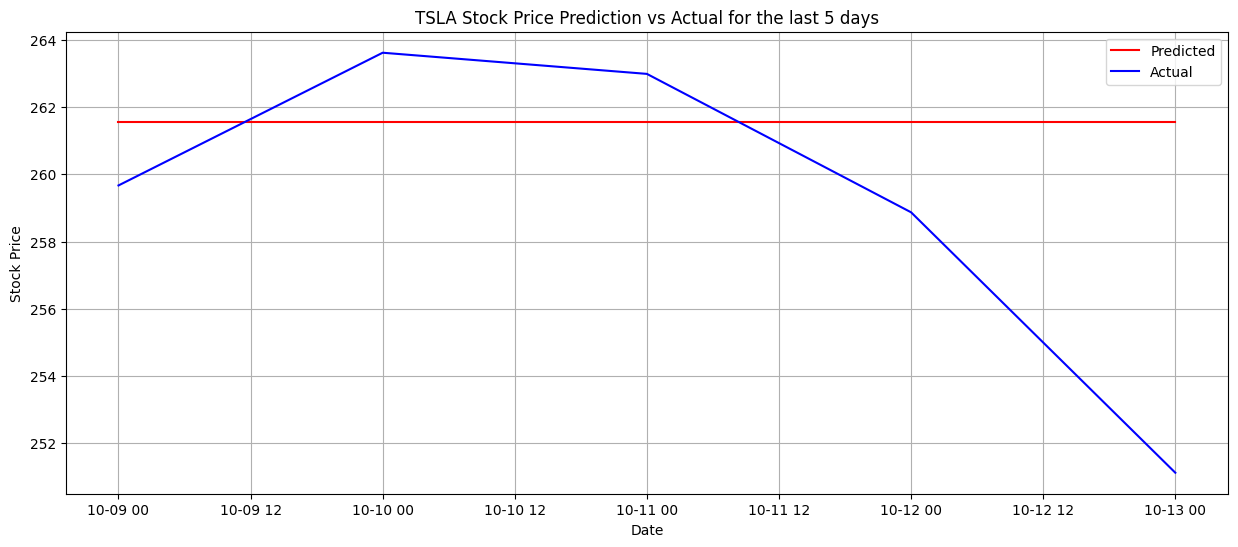

BO is [[6.4e+01 2.0e+00 2.0e-01 3.4e-02 1.0e+02]], with loss of [18.5032322]
Next suggested query point by UCB: 64, 2, 0.2, 0.067, 30
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [

C:\Users\keith\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 0/30 - Training loss: 0.0429, Validation loss: 0.0229
Epoch 10/30 - Training loss: 0.0291, Validation loss: 0.0166
Epoch 20/30 - Training loss: 0.0267, Validation loss: 0.0128


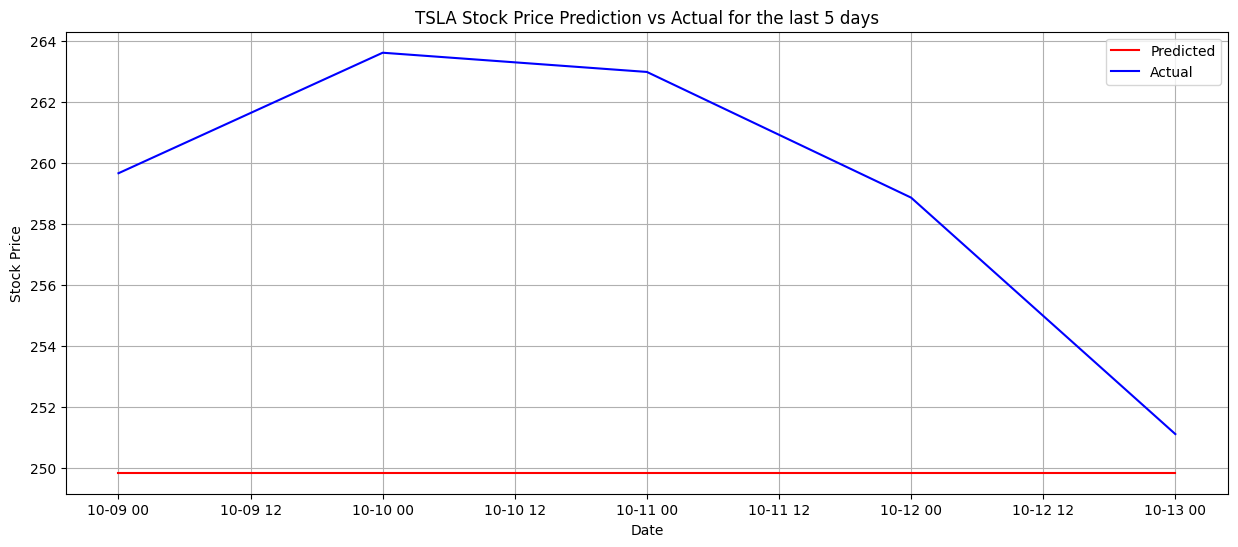

BO is [[64.     2.     0.2    0.067 30.   ]], with loss of [47.00542858]
Next suggested query point by UCB: 64, 2, 0.2, 0.067, 40
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88

C:\Users\keith\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 0/40 - Training loss: 0.0430, Validation loss: 0.0122
Epoch 10/40 - Training loss: 0.0291, Validation loss: 0.0167
Epoch 20/40 - Training loss: 0.0298, Validation loss: 0.0104
Epoch 30/40 - Training loss: 0.0298, Validation loss: 0.0100


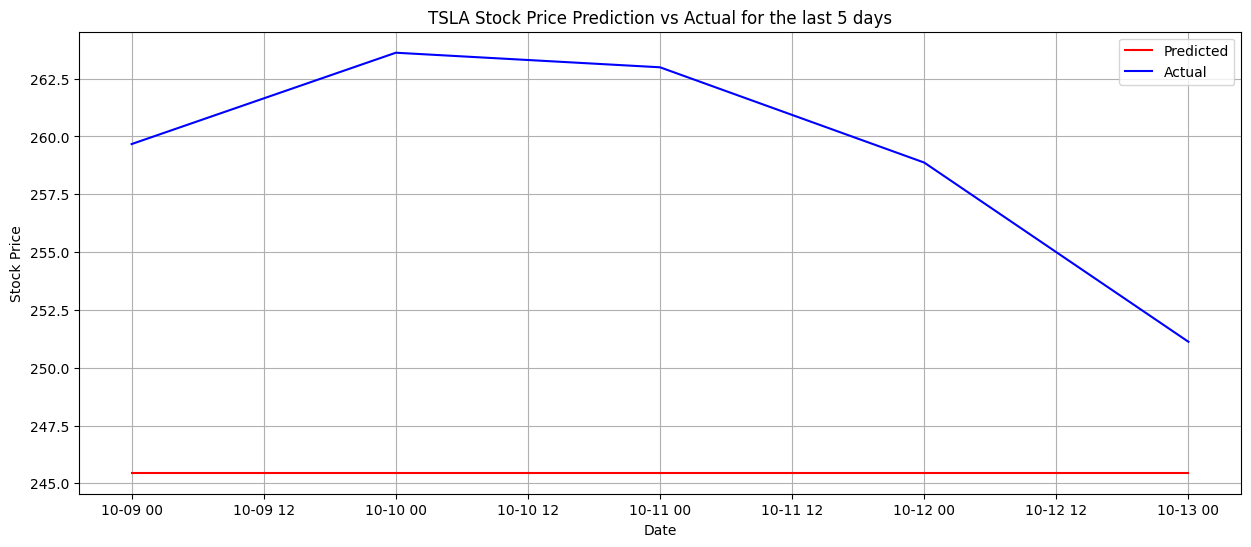

BO is [[64.     2.     0.2    0.067 40.   ]], with loss of [68.97890058]
Next suggested query point by UCB: 64, 2, 0.2, 0.067, 50
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88

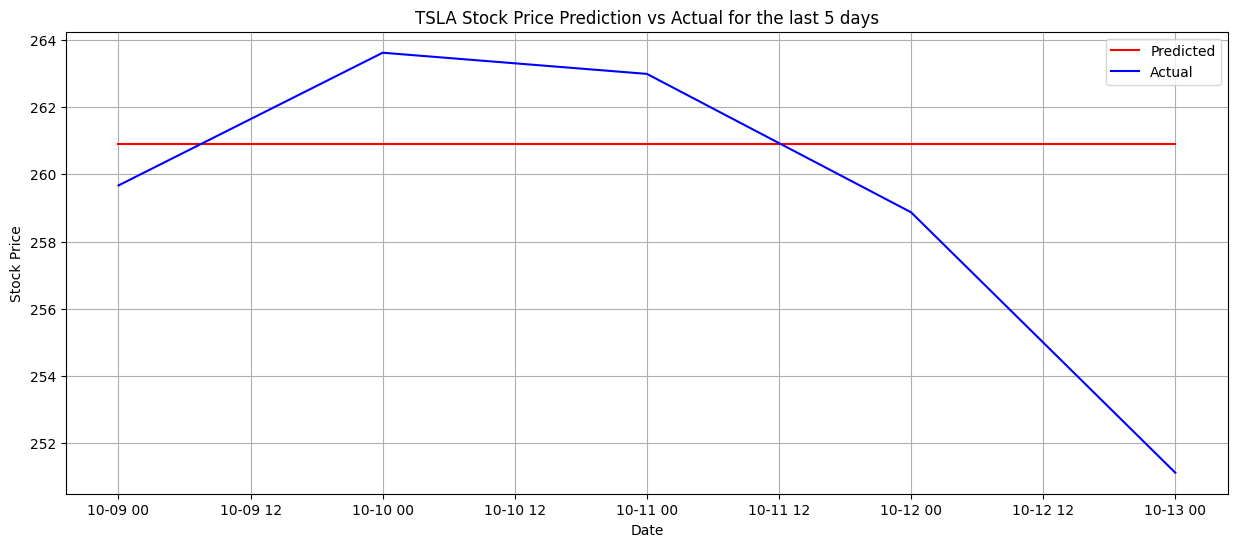

BO is [[64.     2.     0.2    0.067 50.   ]], with loss of [17.85333177]
Next suggested query point by UCB: 64, 2, 0.2, 0.067, 60
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88

C:\Users\keith\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 0/60 - Training loss: 0.0974, Validation loss: 0.0120
Epoch 10/60 - Training loss: 0.0224, Validation loss: 0.0313
Epoch 20/60 - Training loss: 0.0225, Validation loss: 0.0320
Epoch 30/60 - Training loss: 0.0225, Validation loss: 0.0321
Epoch 40/60 - Training loss: 0.0225, Validation loss: 0.0321
Epoch 50/60 - Training loss: 0.0225, Validation loss: 0.0321


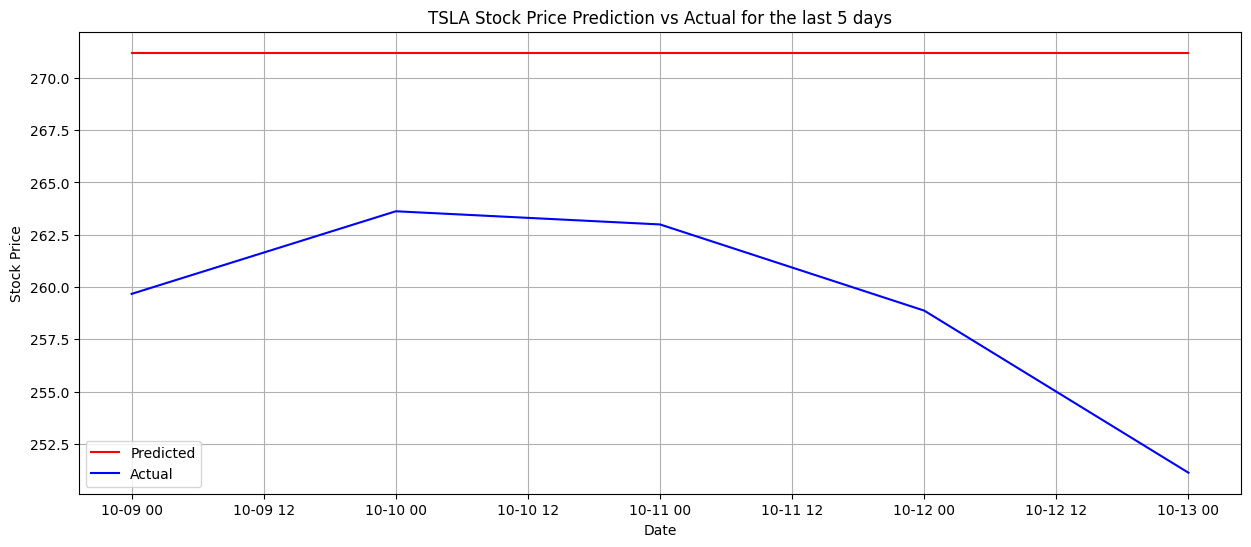

BO is [[64.     2.     0.2    0.067 60.   ]], with loss of [59.72920974]
Next suggested query point by UCB: 64, 2, 0.2, 0.067, 70
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88

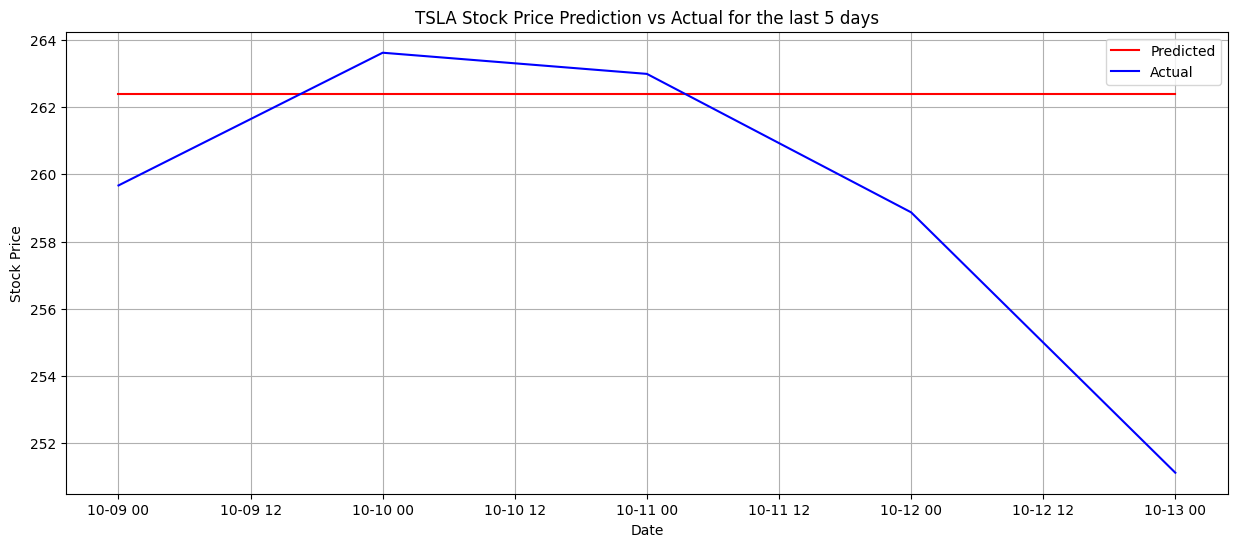

BO is [[6.4e+01 2.0e+00 2.0e-01 6.7e-02 7.0e+01]], with loss of [19.32767062]
Next suggested query point by UCB: 64, 2, 0.2, 0.067, 80
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 

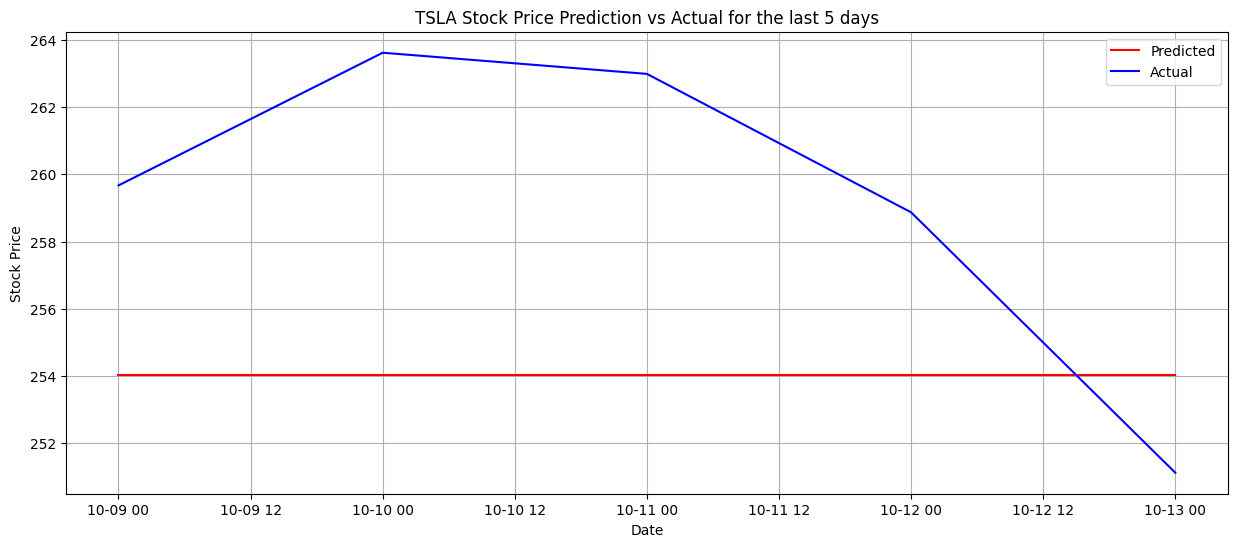

BO is [[6.4e+01 2.0e+00 2.0e-01 6.7e-02 8.0e+01]], with loss of [31.93395749]
Next suggested query point by UCB: 64, 2, 0.2, 0.067, 90
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 

C:\Users\keith\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 0/90 - Training loss: 0.0484, Validation loss: 0.0174
Epoch 10/90 - Training loss: 0.0208, Validation loss: 0.0160
Epoch 20/90 - Training loss: 0.0208, Validation loss: 0.0162
Epoch 30/90 - Training loss: 0.0272, Validation loss: 0.0489
Epoch 40/90 - Training loss: 0.0225, Validation loss: 0.0320
Epoch 50/90 - Training loss: 0.0226, Validation loss: 0.0322
Epoch 60/90 - Training loss: 0.0225, Validation loss: 0.0320
Epoch 70/90 - Training loss: 0.0225, Validation loss: 0.0321
Epoch 80/90 - Training loss: 0.0225, Validation loss: 0.0321


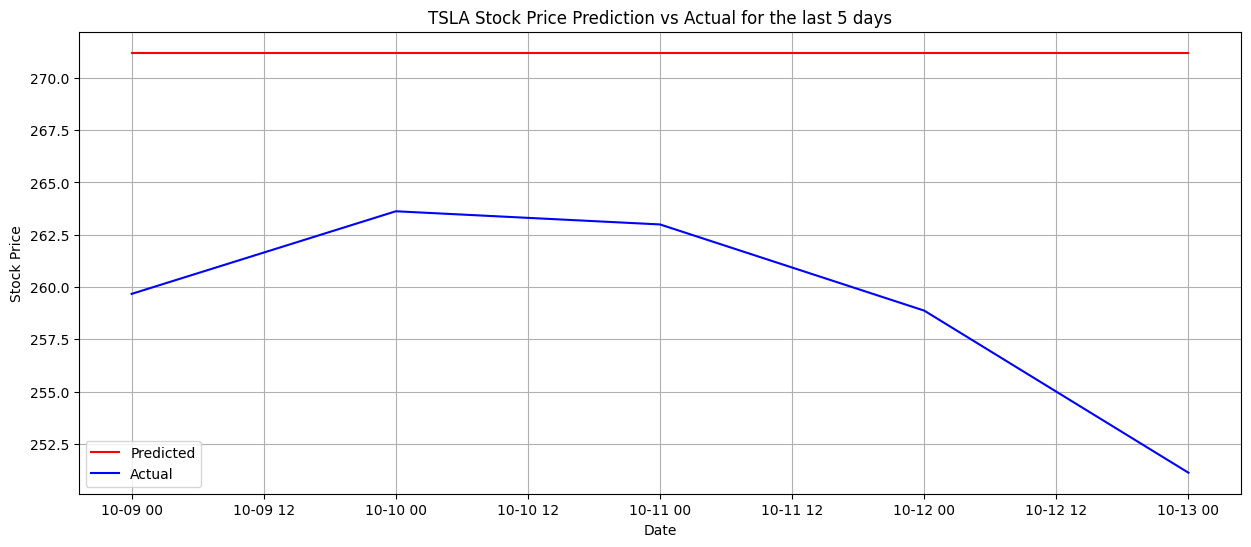

BO is [[6.4e+01 2.0e+00 2.0e-01 6.7e-02 9.0e+01]], with loss of [59.72953589]
Next suggested query point by UCB: 64, 2, 0.2, 0.067, 100
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]


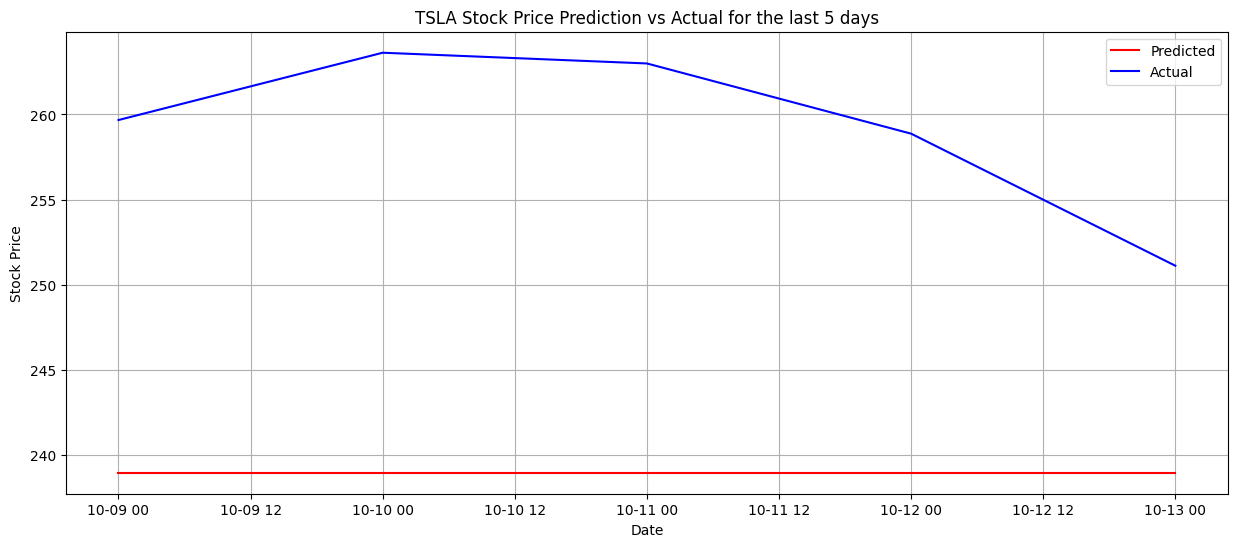

BO is [[6.4e+01 2.0e+00 2.0e-01 6.7e-02 1.0e+02]], with loss of [101.41036218]
Next suggested query point by UCB: 64, 2, 0.2, 0.100, 30
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]


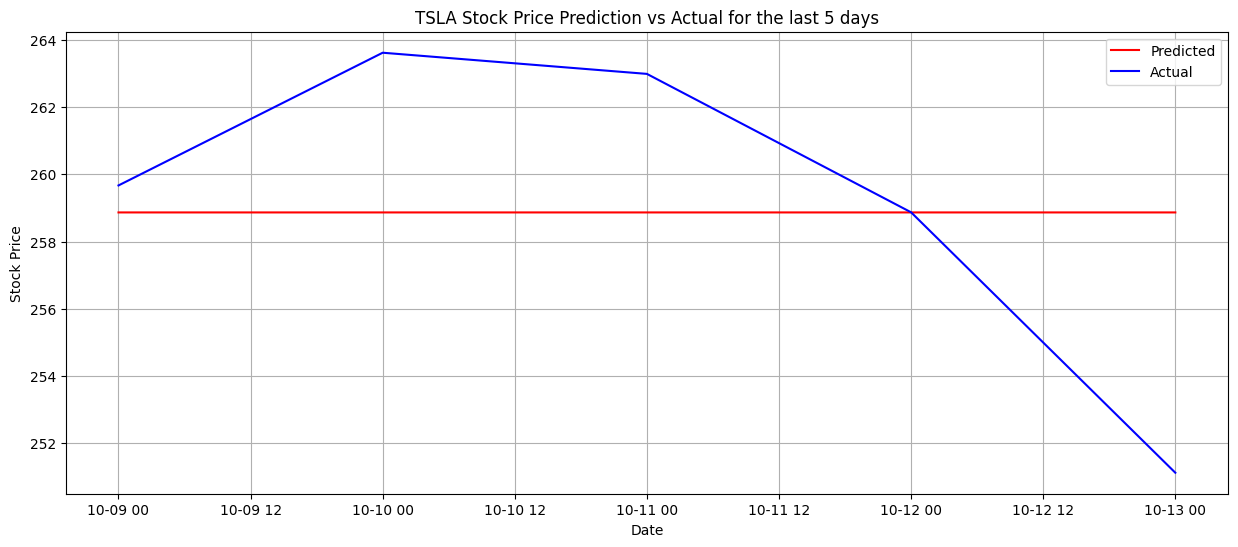

BO is [[64.   2.   0.2  0.1 30. ]], with loss of [17.42966349]
Next suggested query point by UCB: 64, 2, 0.2, 0.100, 40
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e

C:\Users\keith\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 0/40 - Training loss: 0.0985, Validation loss: 0.0129
Epoch 10/40 - Training loss: 0.0255, Validation loss: 0.0174
Epoch 20/40 - Training loss: 0.0408, Validation loss: 0.0517
Epoch 30/40 - Training loss: 0.0366, Validation loss: 0.0218


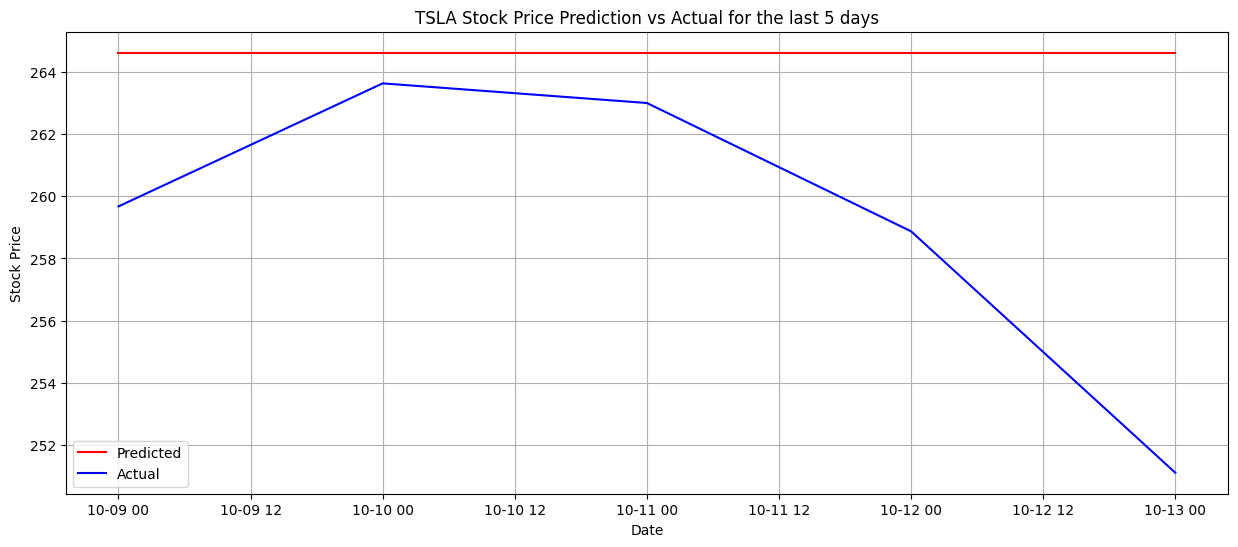

BO is [[64.   2.   0.2  0.1 40. ]], with loss of [26.75038993]
Next suggested query point by UCB: 64, 2, 0.2, 0.100, 50
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e

C:\Users\keith\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 0/50 - Training loss: 0.1384, Validation loss: 0.0117
Epoch 10/50 - Training loss: 0.0225, Validation loss: 0.0323
Epoch 20/50 - Training loss: 0.0227, Validation loss: 0.0327
Epoch 30/50 - Training loss: 0.0227, Validation loss: 0.0327
Epoch 40/50 - Training loss: 0.0227, Validation loss: 0.0327


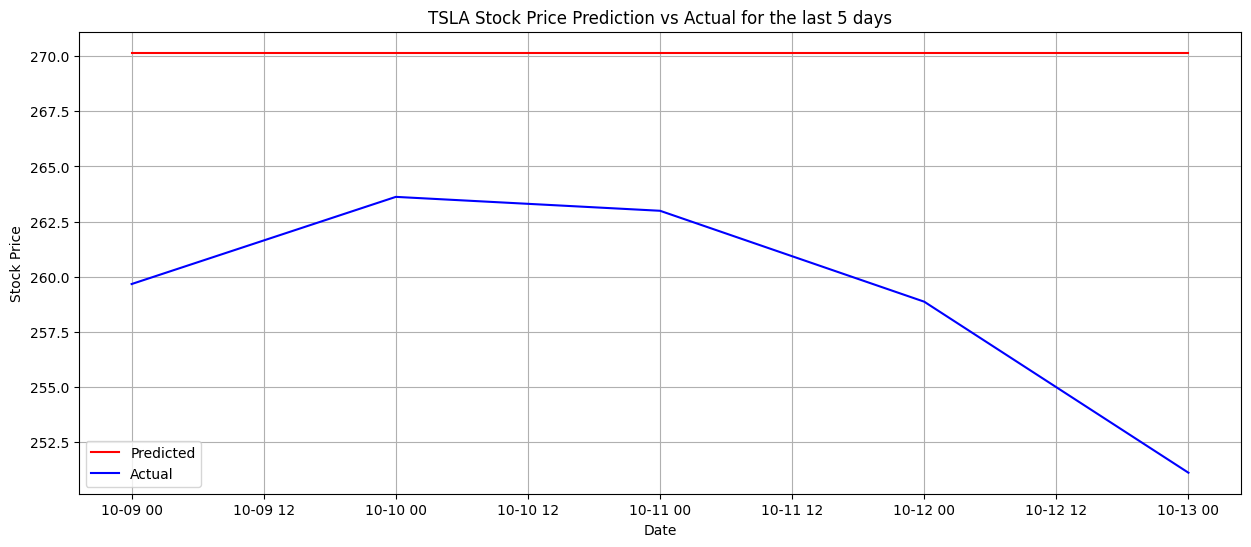

BO is [[64.   2.   0.2  0.1 50. ]], with loss of [54.49025403]
Next suggested query point by UCB: 64, 2, 0.2, 0.100, 60
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e

C:\Users\keith\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 0/60 - Training loss: 0.0961, Validation loss: 0.0262
Epoch 10/60 - Training loss: 0.0328, Validation loss: 0.0209
Epoch 20/60 - Training loss: 0.0339, Validation loss: 0.0241
Epoch 30/60 - Training loss: 0.0308, Validation loss: 0.0197
Epoch 40/60 - Training loss: 0.0226, Validation loss: 0.0185
Epoch 50/60 - Training loss: 0.0297, Validation loss: 0.0188


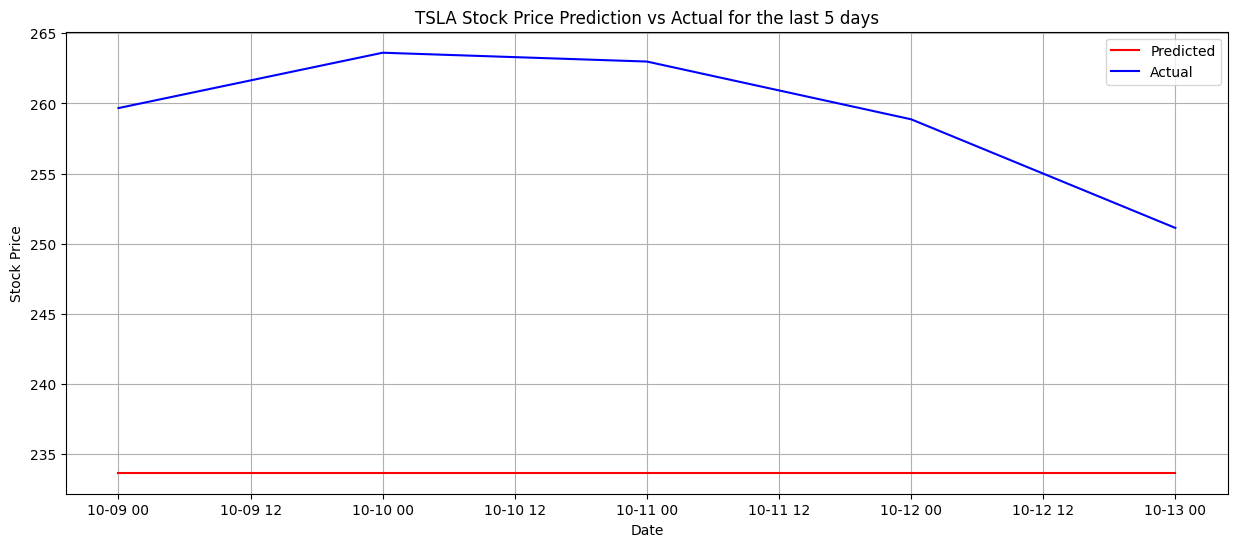

BO is [[64.   2.   0.2  0.1 60. ]], with loss of [128.01620435]
Next suggested query point by UCB: 64, 2, 0.2, 0.100, 70
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00

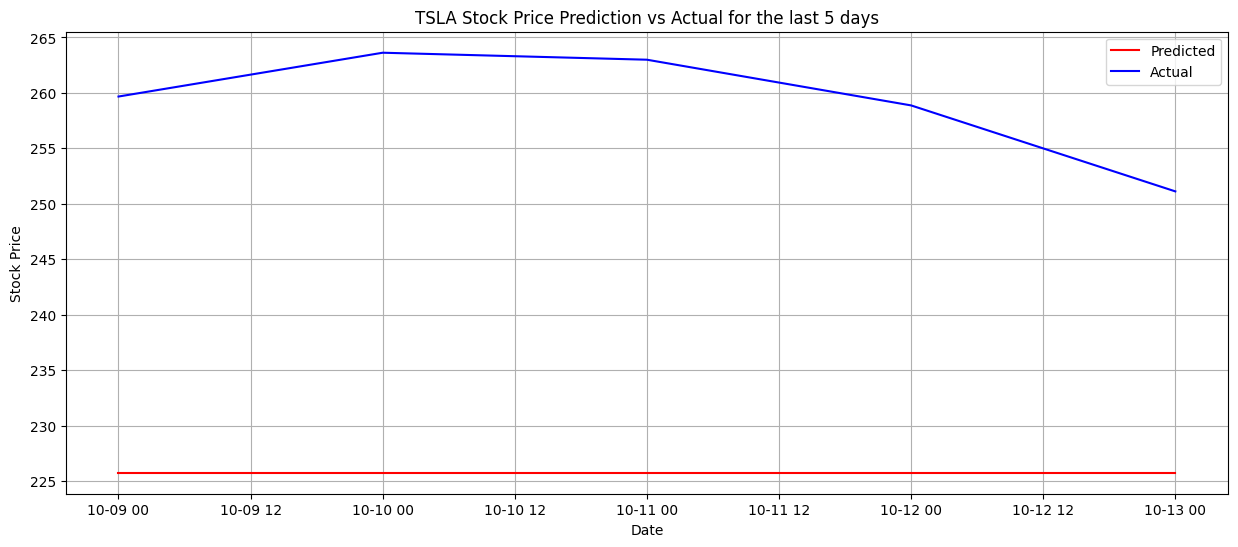

BO is [[64.   2.   0.2  0.1 70. ]], with loss of [167.4890493]
Next suggested query point by UCB: 64, 2, 0.2, 0.100, 80
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e

C:\Users\keith\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 0/80 - Training loss: 0.0894, Validation loss: 0.0094
Epoch 10/80 - Training loss: 0.0292, Validation loss: 0.0094
Epoch 20/80 - Training loss: 0.0262, Validation loss: 0.0137
Epoch 30/80 - Training loss: 0.0255, Validation loss: 0.0138
Epoch 40/80 - Training loss: 0.0419, Validation loss: 0.0488
Epoch 50/80 - Training loss: 0.0319, Validation loss: 0.0160
Epoch 60/80 - Training loss: 0.0319, Validation loss: 0.0160
Epoch 70/80 - Training loss: 0.0319, Validation loss: 0.0159


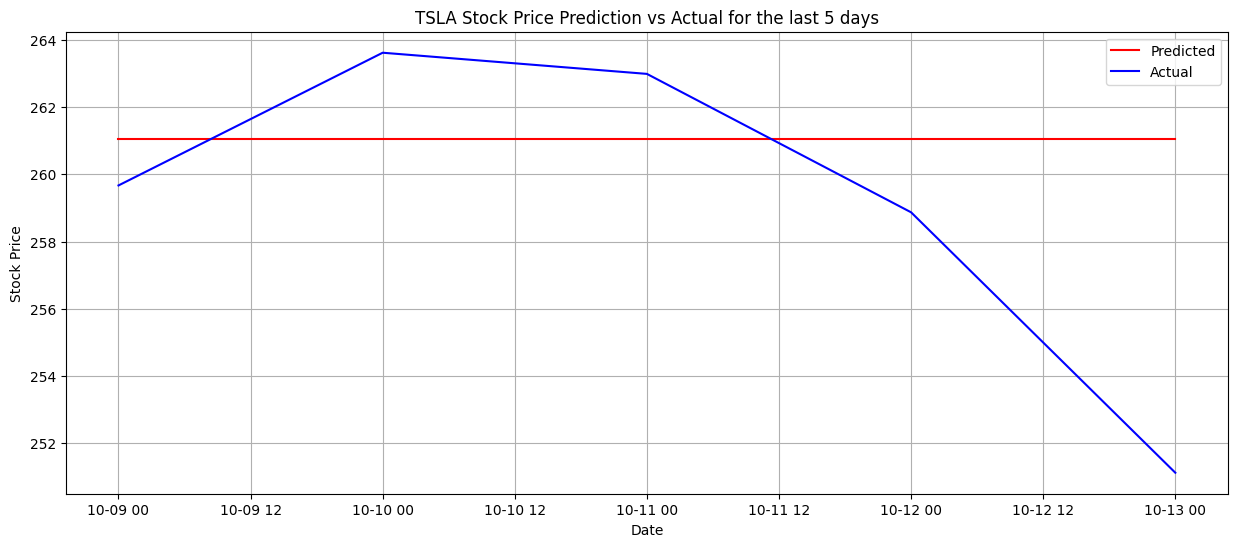

BO is [[64.   2.   0.2  0.1 80. ]], with loss of [18.01676791]
Next suggested query point by UCB: 64, 2, 0.2, 0.100, 90
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e

C:\Users\keith\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 0/90 - Training loss: 0.0667, Validation loss: 0.0250
Epoch 10/90 - Training loss: 0.0255, Validation loss: 0.0485
Epoch 20/90 - Training loss: 0.0255, Validation loss: 0.0485
Epoch 30/90 - Training loss: 0.0356, Validation loss: 0.0241
Epoch 40/90 - Training loss: 0.0338, Validation loss: 0.0196
Epoch 50/90 - Training loss: 0.0334, Validation loss: 0.0189
Epoch 60/90 - Training loss: 0.0321, Validation loss: 0.0194
Epoch 70/90 - Training loss: 0.0338, Validation loss: 0.0205
Epoch 80/90 - Training loss: 0.0338, Validation loss: 0.0205


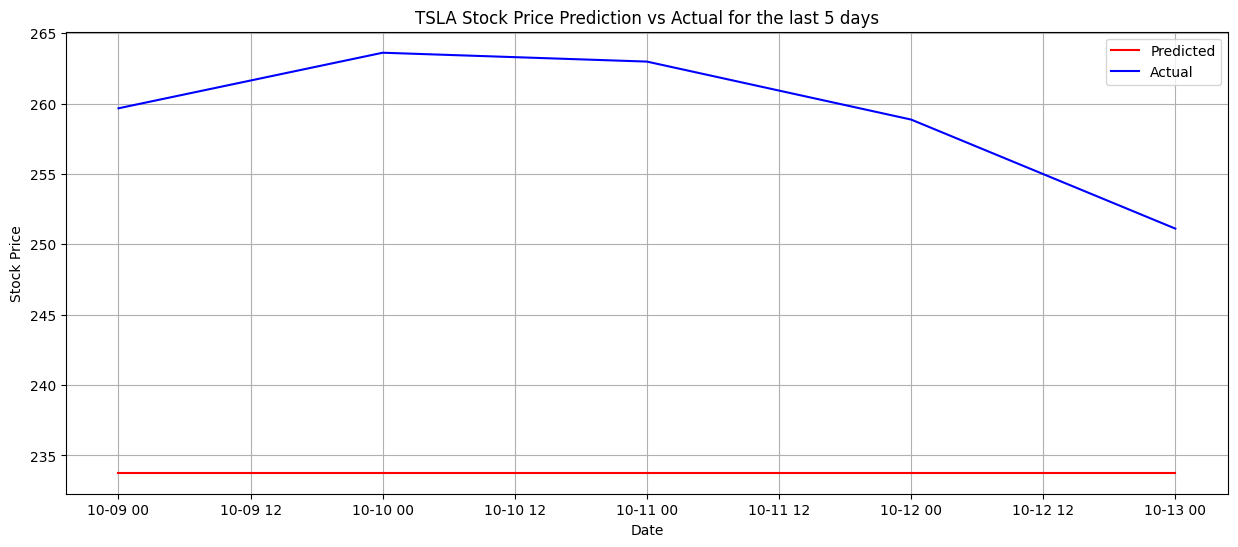

BO is [[64.   2.   0.2  0.1 90. ]], with loss of [127.4139728]
Next suggested query point by UCB: 64, 2, 0.2, 0.100, 100
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00

C:\Users\keith\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 0/100 - Training loss: 0.0734, Validation loss: 0.0342
Epoch 10/100 - Training loss: 0.0286, Validation loss: 0.0107
Epoch 20/100 - Training loss: 0.0318, Validation loss: 0.0131
Epoch 30/100 - Training loss: 0.0281, Validation loss: 0.0123
Epoch 40/100 - Training loss: 0.0287, Validation loss: 0.0106
Epoch 50/100 - Training loss: 0.0287, Validation loss: 0.0106
Epoch 60/100 - Training loss: 0.0287, Validation loss: 0.0106
Epoch 70/100 - Training loss: 0.0287, Validation loss: 0.0106
Epoch 80/100 - Training loss: 0.0287, Validation loss: 0.0106
Epoch 90/100 - Training loss: 0.0287, Validation loss: 0.0106


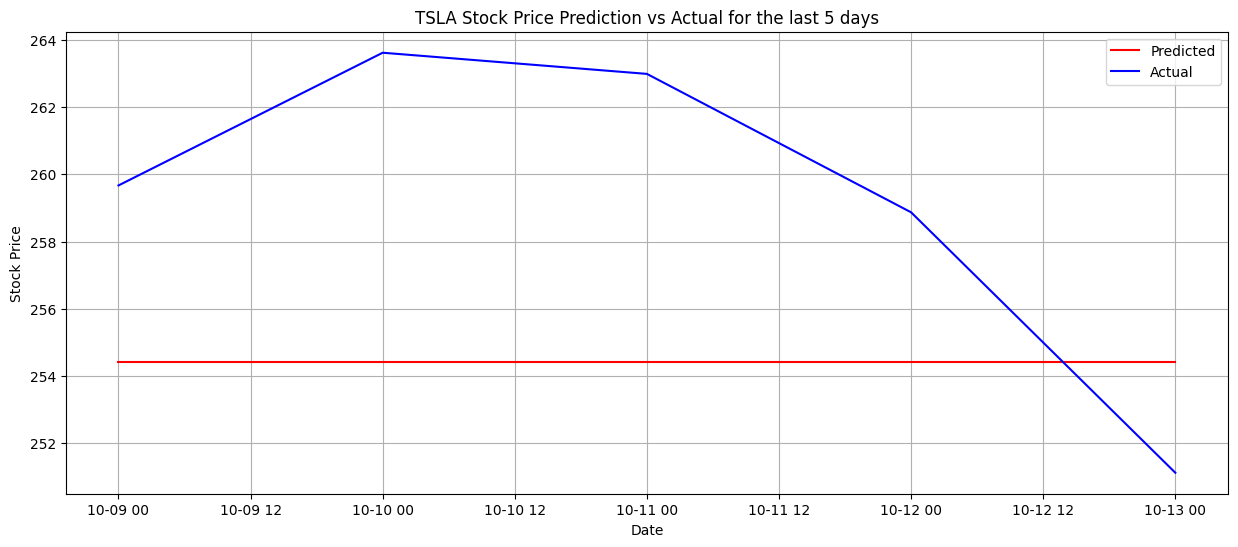

BO is [[ 64.    2.    0.2   0.1 100. ]], with loss of [30.74728433]
Next suggested query point by UCB: 64, 2, 0.3, 0.001, 30
[[6.40e+01 2.00e+00 3.00e-01 1.00e-02 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 7.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-03 3.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 8.00e+01]
 [6.40e+01 2.00e+00 2.00e-01 1.00e-03 9.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 4.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 5.00e+01]
 [5.12e+02 3.00e+00 2.00e-01 1.00e-03 1.00e+02]
 [5.12e+02 3.00e+00 5.00e-01 1.00e-01 6.00e+01]
 [2.88e+02 3.00e+00 5.00e-01 1.00e-01 7.00e+01]
 [5.12e+02 2.00e+00 2.00e-01 1.00e-04 8.00e+01]
 [2.88e+02 2.00e+00 2.00e-01 1.00e-03 6.00e+01]
 [2.88e+02 

C:\Users\keith\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 0/30 - Training loss: 0.0503, Validation loss: 0.0085
Epoch 10/30 - Training loss: 0.0145, Validation loss: 0.0039
Epoch 20/30 - Training loss: 0.0093, Validation loss: 0.0035


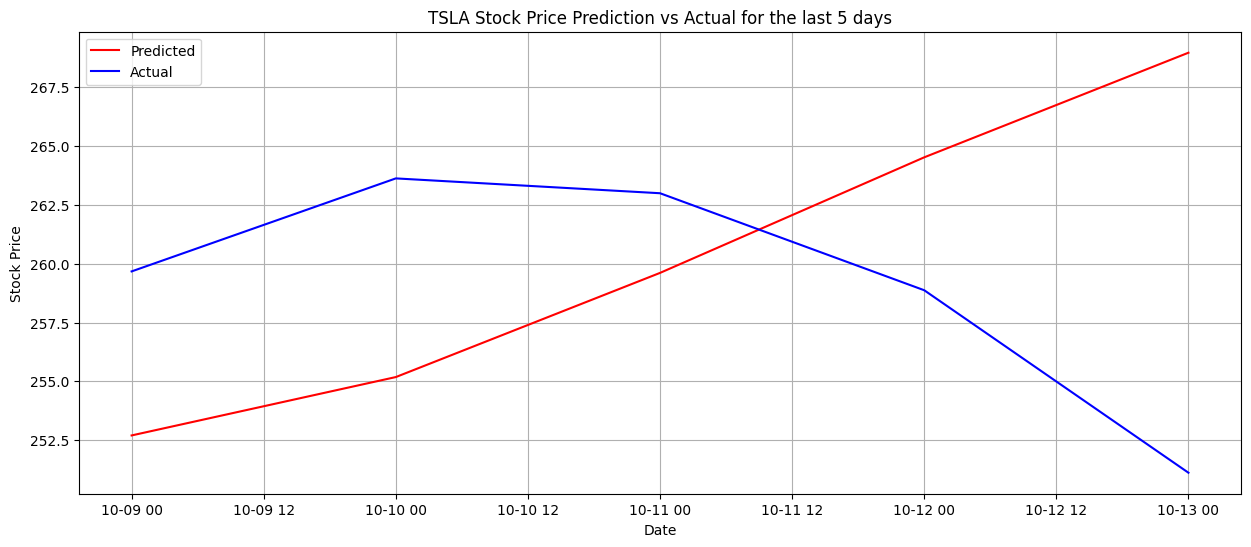

BO is [[6.4e+01 2.0e+00 3.0e-01 1.0e-03 3.0e+01]], with loss of [42.26970261]


In [21]:
query = np.empty((0, len(X[0])))  # Assuming X is a 2D array
obs = np.empty((0, 1))  # 1D column vector

noise_assumption = 1e-10
rbf_lengthscale = 0.1
beta = 1.96        # UCB exploration parameter. beta increases, exploration increases.
eta = 0.05         # PI exploration parameter. 0.1 for explore, 0.01 for exploitiation
xi = 0.1          # EI exploration parameter. 0.1  for balance, 0.01 for exploitiation

# Fit the Gaussian Process Regression model
kernel = RBF(length_scale=rbf_lengthscale*len(X.T))
bogp = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption, n_restarts_optimizer=5)

breakcount = 0

while breakcount < 20 :
    # Update the surrogate model with the new observation
    df_X, df_y = update_surrogate_model(query, obs)
    X = df_X
    Y = df_y
    
    # Fit the surrogate model with the given dataset
    bogp.fit(df_X, df_y)

    # # Get the next suggested query point
    next_query_point_ucb, af_ucb = upper_confidence_bound(beta)
    next_query_point_pi, af_pi = probability_improvement(eta)
    next_query_point_ei, af_ei = expected_improvement(xi)

    # # Comparing 3 aq. function and choose the highest.
    next_query_point, chosen_af = choose_next_query_point(next_query_point_ucb, af_ucb, next_query_point_ei, af_ei, next_query_point_pi, af_pi)

    print(f'Next suggested query point by {chosen_af}: '
          f'{np.round(next_query_point[0], 0):.0f}, '
          f'{np.round(next_query_point[1], 0):.0f}, '
          f'{np.round(next_query_point[2], 1):.1f}, '
          f'{np.round(next_query_point[3], 3):.3f}, '
          f'{np.round(next_query_point[4], 0):.0f}')
    print(df_X, df_y)
    bo = next_query_point #For bo hidden_dim, num_layers, dropout, learning_rate, epoch

    actual_predictions = main(train_window, train_dataset, valid_dataset, test_dataset, bo) 
    abs_different = np.sum(abs(actual_predictions-data.tail(len(actual_predictions))))
    query = np.array(bo).reshape(1, -1)
    obs = np.array(abs_different) # val_loss # Validation loss
    
    print(f'BO is {query}, with loss of {obs}')
    
    breakcount +=1
    if abs_different.iloc[-1] < 5:
        break


In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df_y, marker='o', linestyle='-', color='b')
plt.title('Pytorch BO visualisation')
plt.xlabel('epoch')
plt.ylabel('score')
plt.grid(True)
plt.show()

From the results obtained from 50 queries, It is noted that.

1. The most similar trend between predicted and actual are from bo = [288, 2, 0.2, 0.001, 80]. 

2. The lowest different are from bo = [64.   2.   0.2  0.1 30. ]. However, the predicted lines are almost a straight line instead of following the trend. 

We do not want the lowest score as a straight line doesn't provide any information of where the trend is heading to. Instead, we should opt for option 1. 

Lets try TensorFlow instead of python. Fixing a layer of 2.

Epoch 1/50
11/11 [==============================] - 4s 122ms/step - loss: 0.1848 - val_loss: 0.0117
Epoch 2/50
11/11 [==============================] - 0s 10ms/step - loss: 0.1395 - val_loss: 0.0093
Epoch 3/50
11/11 [==============================] - 0s 12ms/step - loss: 0.0853 - val_loss: 0.0080
Epoch 4/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0240 - val_loss: 0.0149
Epoch 5/50
11/11 [==============================] - 0s 21ms/step - loss: 0.0171 - val_loss: 0.0123
Epoch 6/50
11/11 [==============================] - 0s 21ms/step - loss: 0.0127 - val_loss: 0.0094
Epoch 7/50
11/11 [==============================] - 0s 17ms/step - loss: 0.0119 - val_loss: 0.0091
Epoch 8/50
11/11 [==============================] - 0s 20ms/step - loss: 0.0110 - val_loss: 0.0086
Epoch 9/50
11/11 [==============================] - 0s 25ms/step - loss: 0.0103 - val_loss: 0.0080
Epoch 10/50
11/11 [==============================] - 0s 18ms/step - loss: 0.0099 - val_loss: 0.0080
Epoch 11

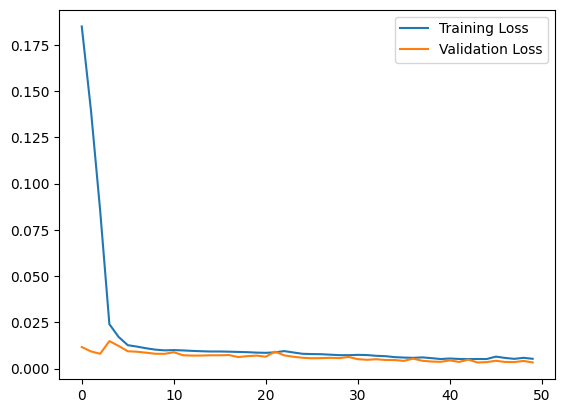

1/1 [==============================] - 1s 1s/step


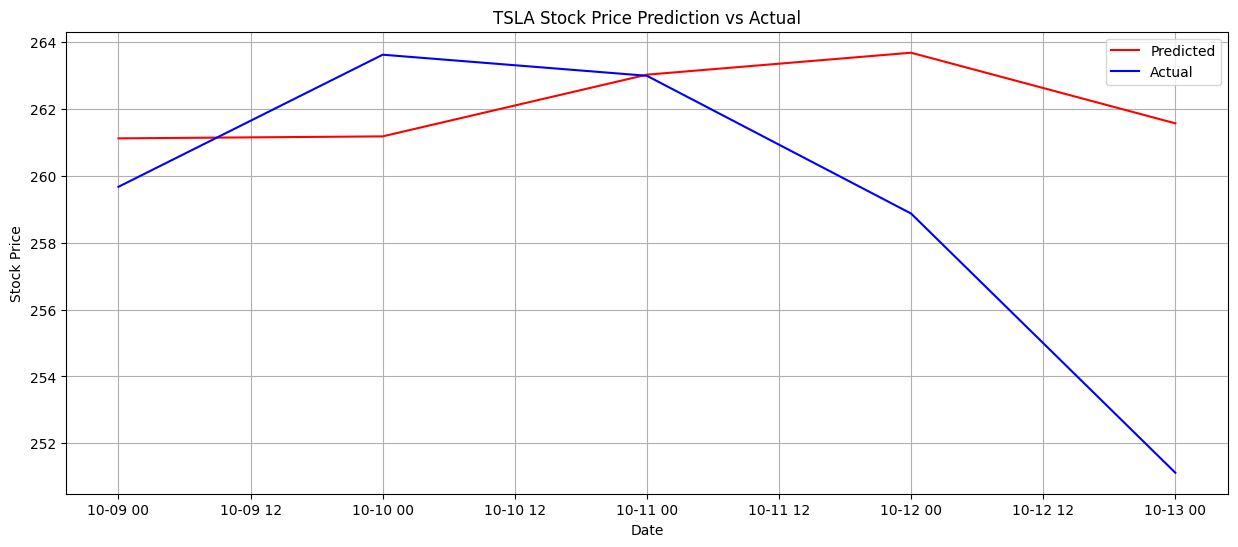

[[261.11847]
 [261.17783]
 [263.02286]
 [263.67926]
 [261.56808]]


In [24]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import MeanSquaredError

train_window = 5
inout_seq = create_inout_sequences(data_normalized, train_window)
total_length = len(inout_seq)

train_length = int(0.8 * (total_length-5))
valid_length = total_length - 5 - train_length

train_dataset = inout_seq[:train_length]
valid_dataset = inout_seq[train_length:train_length+valid_length]
test_dataset = inout_seq[-5:]

train_x = np.array([item[0] for item in train_dataset])
train_y = np.array([item[1] for item in train_dataset])
valid_x = np.array([item[0] for item in valid_dataset])
valid_y = np.array([item[1] for item in valid_dataset])

class PrintLossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            if epoch % 10 == 0:
                print(f'Epoch {epoch}/{self.params["epochs"]} - Training loss: {logs["loss"]:.4f}, Validation loss: {logs["val_loss"]:.4f}')
                
                
def main_tf(train_x, train_y, valid_x, valid_y, test_dataset, bo):
    
    neuron_1 = int(bo[0])
    neuron_2 = int(bo[1])
    epoch = int(bo[2])
    
    model = Sequential()
    model.add(LSTM(neuron_1, activation='relu', input_shape=(train_window, 1), return_sequences=True))
    model.add(LSTM(neuron_2, activation='relu', return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss=MeanSquaredError())

    history = model.fit(train_x, train_y, epochs=epoch, 
                        validation_data=(valid_x, valid_y), verbose=1, callbacks=[PrintLossCallback()])

    # Plotting training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

    test_x = np.array([item[0] for item in test_dataset])
    test_y = np.array([item[1] for item in test_dataset])

    predictions = model.predict(test_x)
    actual_predictions = scaler.inverse_transform(predictions)
    dates = data.index[-5:]

    plt.figure(figsize=(15, 6))
    plt.plot(dates, actual_predictions, label='Predicted', color='red')
    plt.plot(dates, scaler.inverse_transform(test_y.reshape(-1, 1)), label='Actual', color='blue')
    plt.title("TSLA Stock Price Prediction vs Actual")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return(actual_predictions)
    
if __name__ == '__main__':
    bo = [64, 32, 50]     # hidden_dim, num_layers, dropout, learning_rate, epoch
    actual_predictions = main_tf(train_x, train_y, valid_x, valid_y, test_dataset, bo) 
    print(actual_predictions)

In [25]:
X = np.array(bo)
Y = np.array(abs_different) # val_loss # Validation loss
X = X.reshape(1, -1)  
Y = Y.reshape(-1, 1)  
print(X.shape,Y.shape)
X,Y

(1, 3) (1, 1)


(array([[64, 32, 50]]), array([[42.26970261]]))

In [26]:
#PI
def probability_improvement(eta): 
    #For bo hidden_dim, num_layers, dropout, learning_rate
    query_range_hiddenunit_1 = np.linspace(64, 512, 3)  
    query_range_epoch = np.linspace(30, 100, 8)
    
    # Construct meshgrid using individual feature ranges
    grid = np.meshgrid(query_range_hiddenunit_1, query_range_hiddenunit_1, 
                       query_range_epoch)
    query_points = np.vstack(list(map(np.ravel, grid))).T

    mean, std = bogp.predict(query_points, return_std=True)
    best_observed = np.min(df_y) #.max(df_y) 
    
    pi = []
    for k in range(len(query_points)):
        pi.append(1 - NormalDist(mu = mean[k], sigma = std[k]).cdf(best_observed - eta))
        
    pi = np.array(pi)
    next_query_point = query_points[np.argmin(pi)] #[np.argmax(pi)]
    
    return query_points, pi 

#UCB
def upper_confidence_bound(beta): 
    #For bo hidden_dim, num_layers, dropout, learning_rate
    query_range_hiddenunit_1 = np.linspace(64, 512, 3)  
    query_range_epoch = np.linspace(30, 100, 8)
    
    # Construct meshgrid using individual feature ranges
    grid = np.meshgrid(query_range_hiddenunit_1, query_range_hiddenunit_1, 
                       query_range_epoch)
    query_points = np.vstack(list(map(np.ravel, grid))).T

    mean, std = bogp.predict(query_points, return_std=True)
    ucb = mean - (beta * std)
    
    next_query_point = query_points[np.argmin(ucb)] # [np.argmax(ucb)]
    
    return query_points, ucb 

#EI
def expected_improvement(xi): 
    #For bo hidden_dim, num_layers, dropout, learning_rate
    query_range_hiddenunit_1 = np.linspace(64, 512, 3)  
    query_range_epoch = np.linspace(30, 100, 8)
    
    # Construct meshgrid using individual feature ranges
    grid = np.meshgrid(query_range_hiddenunit_1, query_range_hiddenunit_1, 
                       query_range_epoch)
    query_points = np.vstack(list(map(np.ravel, grid))).T
    
    f_best = np.min(df_y)
    mean, std = bogp.predict(query_points, return_std=True)
    
    z = (f_best - mean - xi) / std #    z = (mean - f_best - xi) / std
    ei = (f_best - mean - xi) * norm.cdf(z) - std * norm.pdf(z)# ei = (mean - f_best - xi) * norm.cdf(z) + std * norm.pdf(z)
    ei[std == 0.0] = 0.0  # Set EI to 0 where std is 0 to avoid division by zero.

    next_query_point = query_points[np.argmax(ei)] # This is correct

    return query_points, ei 

Next suggested query point by UCB: 64, 64, 30
[[64. 32. 50.]] [[42.26970261]]
Epoch 1/30
11/11 [==============================] - 2s 35ms/step - loss: 0.1826 - val_loss: 0.0141
Epoch 2/30
11/11 [==============================] - 0s 9ms/step - loss: 0.1356 - val_loss: 0.0186
Epoch 3/30
11/11 [==============================] - 0s 10ms/step - loss: 0.0765 - val_loss: 0.0233
Epoch 4/30
11/11 [==============================] - 0s 10ms/step - loss: 0.0392 - val_loss: 0.0094
Epoch 5/30
11/11 [==============================] - 0s 12ms/step - loss: 0.0197 - val_loss: 0.0187
Epoch 6/30
11/11 [==============================] - 0s 11ms/step - loss: 0.0144 - val_loss: 0.0111
Epoch 7/30
11/11 [==============================] - 0s 11ms/step - loss: 0.0119 - val_loss: 0.0118
Epoch 8/30
11/11 [==============================] - 0s 11ms/step - loss: 0.0117 - val_loss: 0.0106
Epoch 9/30
11/11 [==============================] - 0s 11ms/step - loss: 0.0109 - val_loss: 0.0099
Epoch 10/30
11/11 [=============

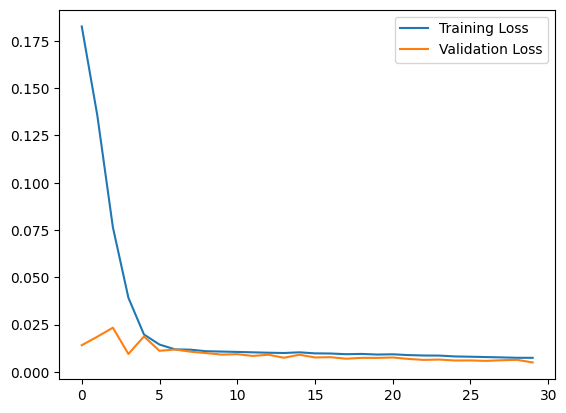

1/1 [==============================] - 0s 340ms/step


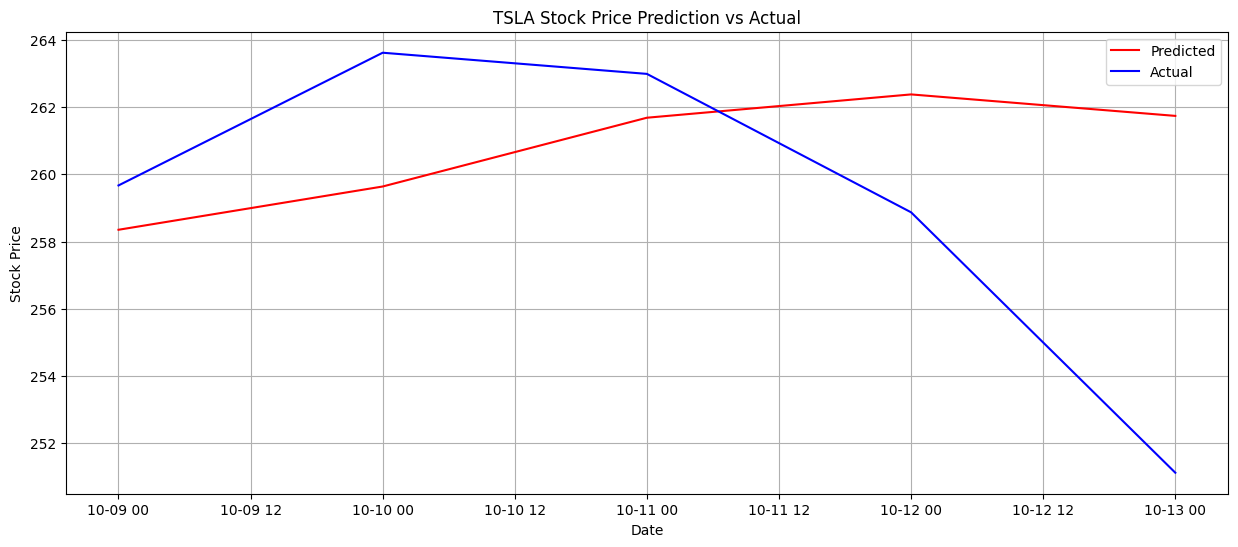

BO is [[64. 64. 30.]], with loss of [20.73434448]
Next suggested query point by UCB: 64, 64, 40
[[64. 32. 50.]
 [64. 64. 30.]] [[42.26970261]
 [20.73434448]]
Epoch 1/40
11/11 [==============================] - 3s 37ms/step - loss: 0.1768 - val_loss: 0.0101
Epoch 2/40
11/11 [==============================] - 0s 8ms/step - loss: 0.1212 - val_loss: 0.0066
Epoch 3/40
11/11 [==============================] - 0s 8ms/step - loss: 0.0513 - val_loss: 0.0134
Epoch 4/40
11/11 [==============================] - 0s 8ms/step - loss: 0.0195 - val_loss: 0.0264
Epoch 5/40
11/11 [==============================] - 0s 8ms/step - loss: 0.0137 - val_loss: 0.0101
Epoch 6/40
11/11 [==============================] - 0s 8ms/step - loss: 0.0134 - val_loss: 0.0101
Epoch 7/40
11/11 [==============================] - 0s 9ms/step - loss: 0.0110 - val_loss: 0.0089
Epoch 8/40
11/11 [==============================] - 0s 8ms/step - loss: 0.0102 - val_loss: 0.0084
Epoch 9/40
11/11 [==============================] - 0s 8m

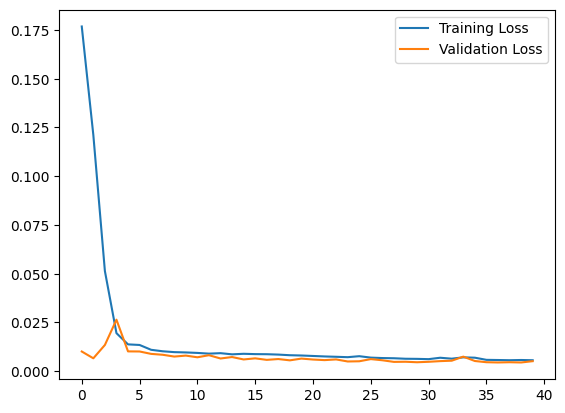

1/1 [==============================] - 0s 263ms/step


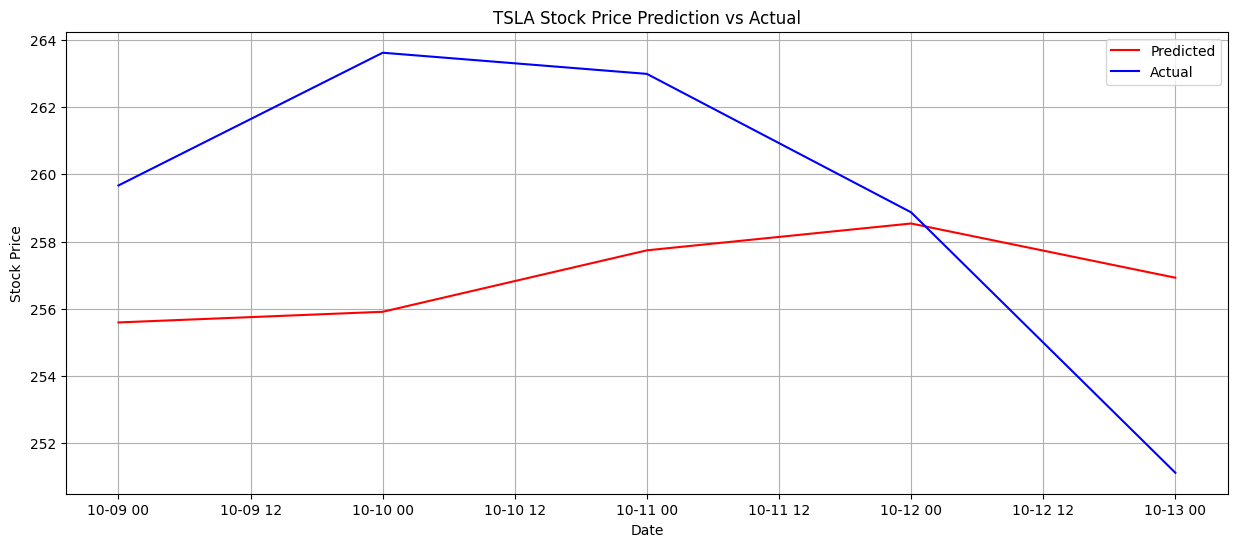

BO is [[64. 64. 40.]], with loss of [23.17550659]
Next suggested query point by UCB: 64, 64, 50
[[64. 32. 50.]
 [64. 64. 30.]
 [64. 64. 40.]] [[42.26970261]
 [20.73434448]
 [23.17550659]]
Epoch 1/50
11/11 [==============================] - 3s 37ms/step - loss: 0.1843 - val_loss: 0.0117
Epoch 2/50
11/11 [==============================] - 0s 7ms/step - loss: 0.1382 - val_loss: 0.0099
Epoch 3/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0692 - val_loss: 0.0127
Epoch 4/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0177 - val_loss: 0.0229
Epoch 5/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0152 - val_loss: 0.0108
Epoch 6/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0133 - val_loss: 0.0095
Epoch 7/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0113 - val_loss: 0.0104
Epoch 8/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0111 - val_loss: 0.0087
Epoch 9/50
11/11 [======

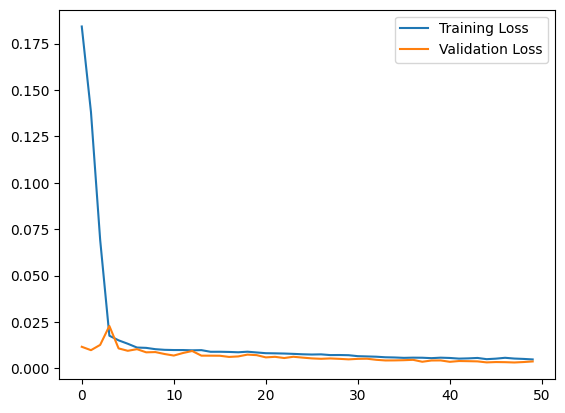

1/1 [==============================] - 0s 376ms/step


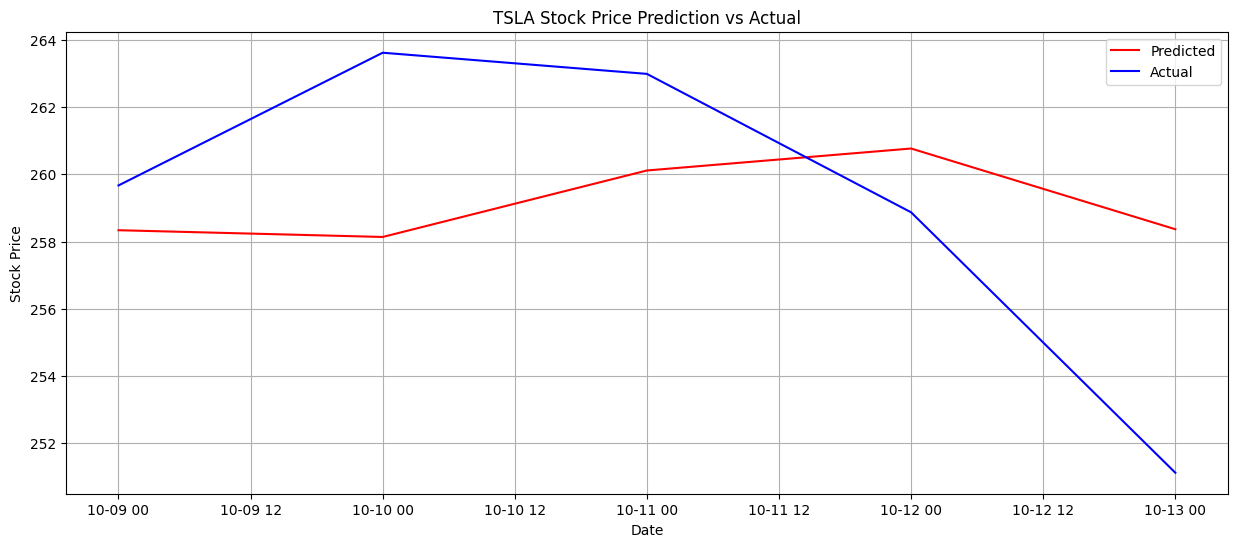

BO is [[64. 64. 50.]], with loss of [18.83731079]
Next suggested query point by UCB: 64, 64, 90
[[64. 32. 50.]
 [64. 64. 30.]
 [64. 64. 40.]
 [64. 64. 50.]] [[42.26970261]
 [20.73434448]
 [23.17550659]
 [18.83731079]]
Epoch 1/90
11/11 [==============================] - 3s 39ms/step - loss: 0.1804 - val_loss: 0.0109
Epoch 2/90
11/11 [==============================] - 0s 7ms/step - loss: 0.1303 - val_loss: 0.0072
Epoch 3/90
11/11 [==============================] - 0s 8ms/step - loss: 0.0625 - val_loss: 0.0110
Epoch 4/90
11/11 [==============================] - 0s 8ms/step - loss: 0.0238 - val_loss: 0.0316
Epoch 5/90
11/11 [==============================] - 0s 9ms/step - loss: 0.0148 - val_loss: 0.0098
Epoch 6/90
11/11 [==============================] - 0s 10ms/step - loss: 0.0130 - val_loss: 0.0106
Epoch 7/90
11/11 [==============================] - 0s 9ms/step - loss: 0.0114 - val_loss: 0.0089
Epoch 8/90
11/11 [==============================] - 0s 9ms/step - loss: 0.0108 - val_loss: 0.0

Epoch 72/90
11/11 [==============================] - 0s 9ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 73/90
11/11 [==============================] - 0s 10ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 74/90
11/11 [==============================] - 0s 10ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 75/90
11/11 [==============================] - 0s 12ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 76/90
11/11 [==============================] - 0s 12ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 77/90
11/11 [==============================] - 0s 11ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 78/90
11/11 [==============================] - 0s 11ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 79/90
11/11 [==============================] - 0s 11ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 80/90
11/11 [==============================] - 0s 10ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 81/90
11/11 [==============================] - 0s 12ms/step - loss: 0.0055 - val_loss: 0.0037
E

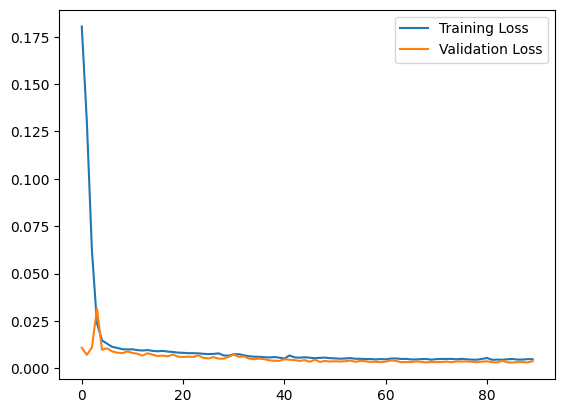

1/1 [==============================] - 0s 306ms/step


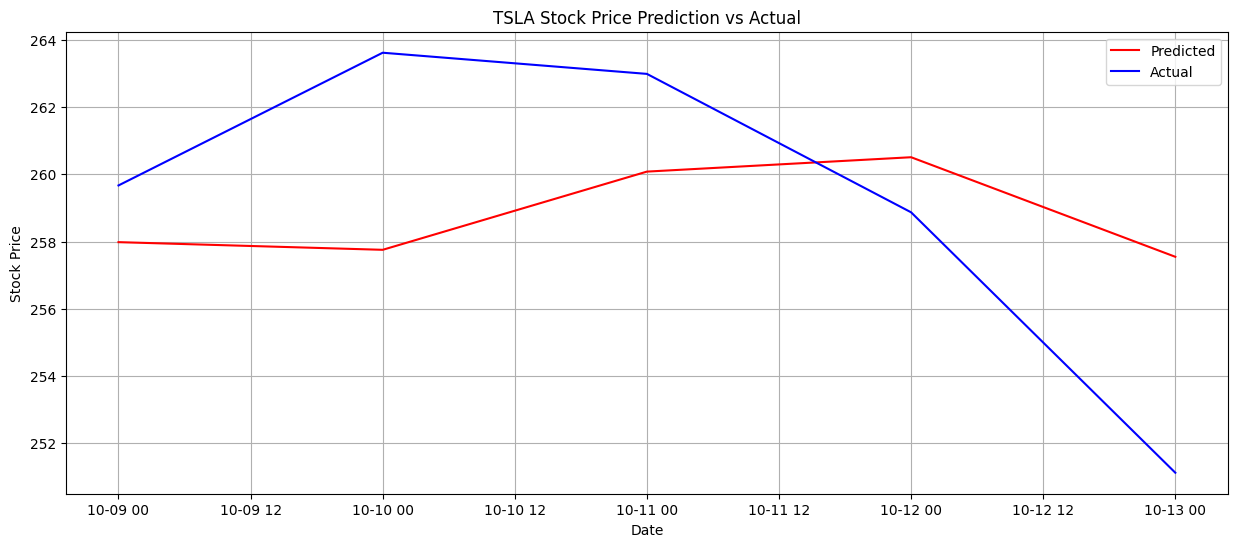

BO is [[64. 64. 90.]], with loss of [18.52789307]
Next suggested query point by UCB: 288, 64, 30
[[64. 32. 50.]
 [64. 64. 30.]
 [64. 64. 40.]
 [64. 64. 50.]
 [64. 64. 90.]] [[42.26970261]
 [20.73434448]
 [23.17550659]
 [18.83731079]
 [18.52789307]]
Epoch 1/30
11/11 [==============================] - 3s 55ms/step - loss: 0.1590 - val_loss: 0.0078
Epoch 2/30
11/11 [==============================] - 0s 23ms/step - loss: 0.0522 - val_loss: 0.0236
Epoch 3/30
11/11 [==============================] - 0s 24ms/step - loss: 0.0187 - val_loss: 0.0077
Epoch 4/30
11/11 [==============================] - 0s 25ms/step - loss: 0.0154 - val_loss: 0.0109
Epoch 5/30
11/11 [==============================] - 0s 24ms/step - loss: 0.0110 - val_loss: 0.0074
Epoch 6/30
11/11 [==============================] - 0s 24ms/step - loss: 0.0106 - val_loss: 0.0084
Epoch 7/30
11/11 [==============================] - 0s 24ms/step - loss: 0.0098 - val_loss: 0.0098
Epoch 8/30
11/11 [==============================] - 0s 24m

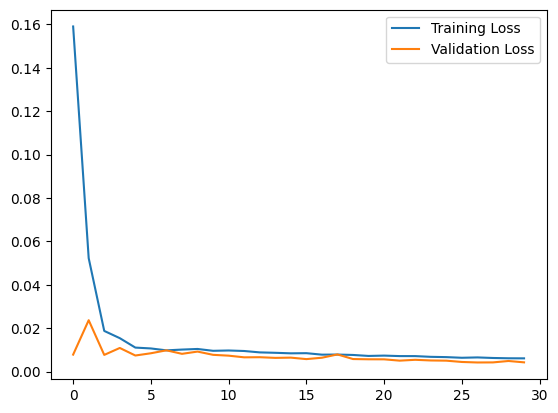

1/1 [==============================] - 0s 341ms/step


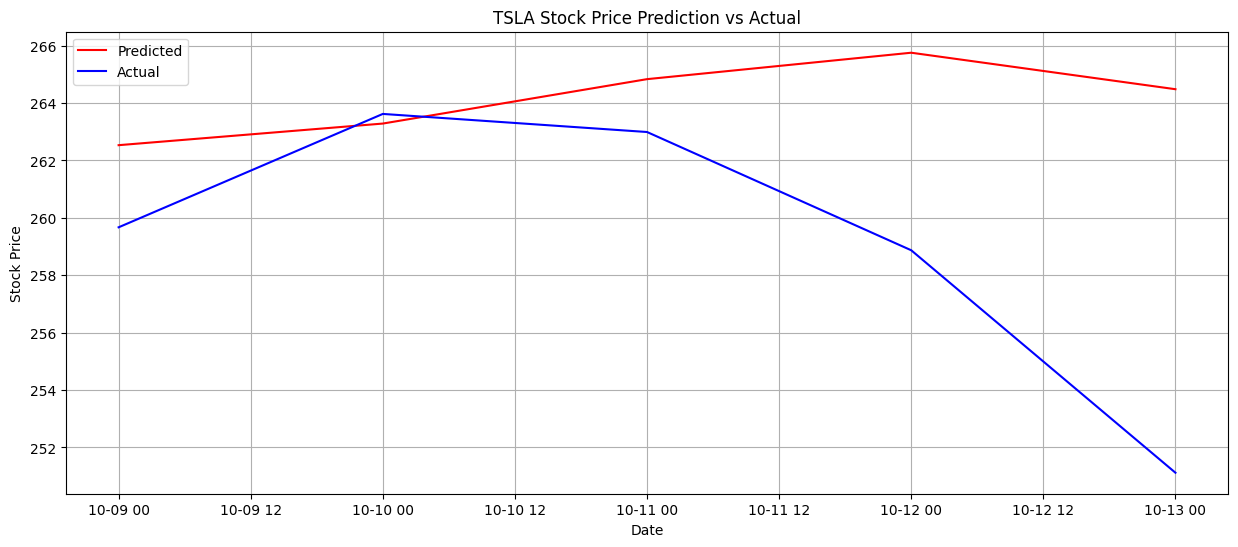

BO is [[288.  64.  30.]], with loss of [25.28158569]
Next suggested query point by UCB: 64, 64, 60
[[ 64.  32.  50.]
 [ 64.  64.  30.]
 [ 64.  64.  40.]
 [ 64.  64.  50.]
 [ 64.  64.  90.]
 [288.  64.  30.]] [[42.26970261]
 [20.73434448]
 [23.17550659]
 [18.83731079]
 [18.52789307]
 [25.28158569]]
Epoch 1/60
11/11 [==============================] - 3s 48ms/step - loss: 0.1750 - val_loss: 0.0110
Epoch 2/60
11/11 [==============================] - 0s 9ms/step - loss: 0.1240 - val_loss: 0.0091
Epoch 3/60
11/11 [==============================] - 0s 9ms/step - loss: 0.0464 - val_loss: 0.0131
Epoch 4/60
11/11 [==============================] - 0s 9ms/step - loss: 0.0185 - val_loss: 0.0200
Epoch 5/60
11/11 [==============================] - 0s 9ms/step - loss: 0.0132 - val_loss: 0.0117
Epoch 6/60
11/11 [==============================] - 0s 10ms/step - loss: 0.0129 - val_loss: 0.0101
Epoch 7/60
11/11 [==============================] - 0s 11ms/step - loss: 0.0113 - val_loss: 0.0098
Epoch 8/60
1

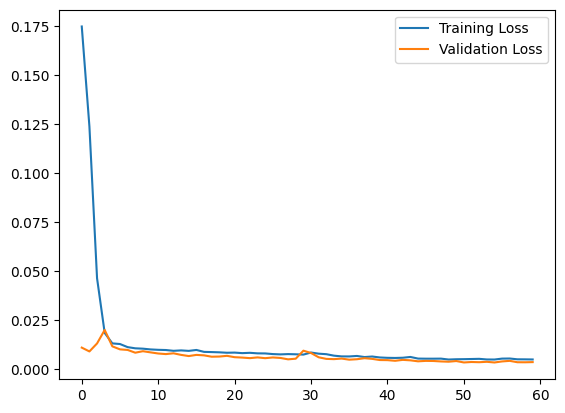

1/1 [==============================] - 0s 321ms/step


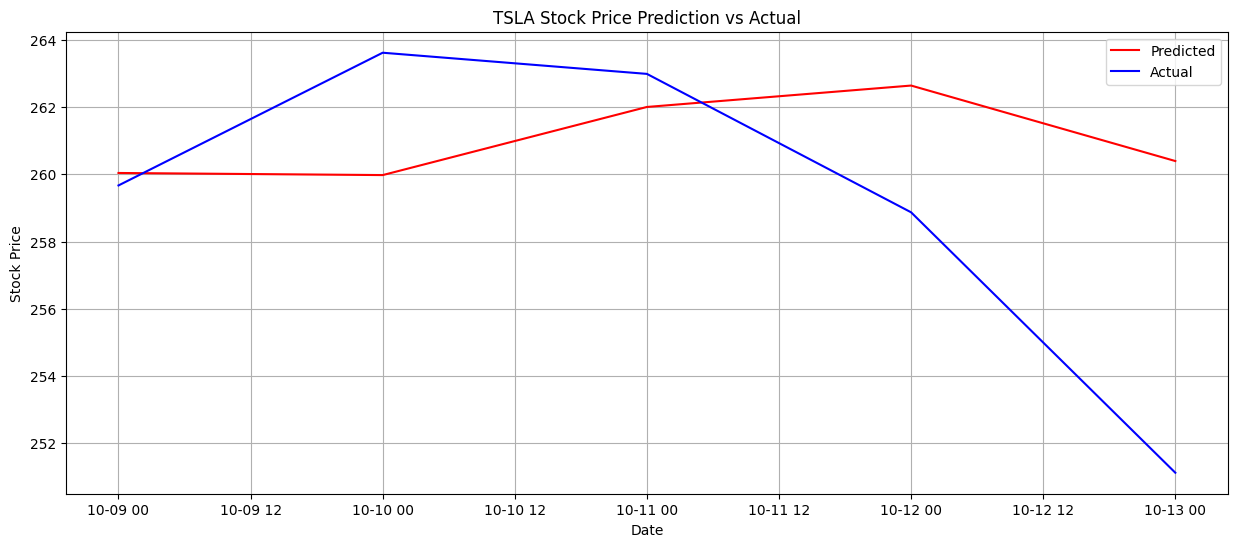

BO is [[64. 64. 60.]], with loss of [18.04678345]
Next suggested query point by UCB: 64, 64, 70
[[ 64.  32.  50.]
 [ 64.  64.  30.]
 [ 64.  64.  40.]
 [ 64.  64.  50.]
 [ 64.  64.  90.]
 [288.  64.  30.]
 [ 64.  64.  60.]] [[42.26970261]
 [20.73434448]
 [23.17550659]
 [18.83731079]
 [18.52789307]
 [25.28158569]
 [18.04678345]]
Epoch 1/70
11/11 [==============================] - 3s 38ms/step - loss: 0.1737 - val_loss: 0.0105
Epoch 2/70
11/11 [==============================] - 0s 8ms/step - loss: 0.1187 - val_loss: 0.0071
Epoch 3/70
11/11 [==============================] - 0s 8ms/step - loss: 0.0489 - val_loss: 0.0137
Epoch 4/70
11/11 [==============================] - 0s 8ms/step - loss: 0.0184 - val_loss: 0.0213
Epoch 5/70
11/11 [==============================] - 0s 9ms/step - loss: 0.0136 - val_loss: 0.0108
Epoch 6/70
11/11 [==============================] - 0s 11ms/step - loss: 0.0119 - val_loss: 0.0104
Epoch 7/70
11/11 [==============================] - 0s 9ms/step - loss: 0.0108 - 

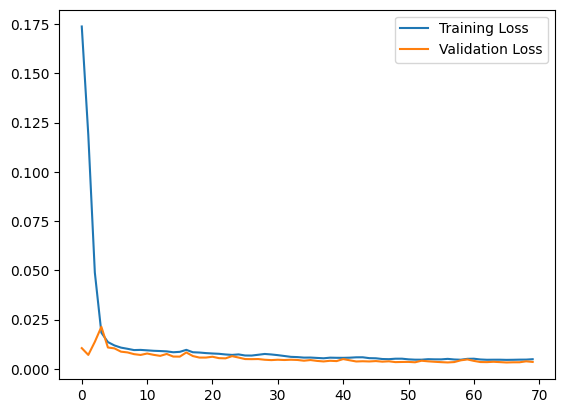

1/1 [==============================] - 0s 260ms/step


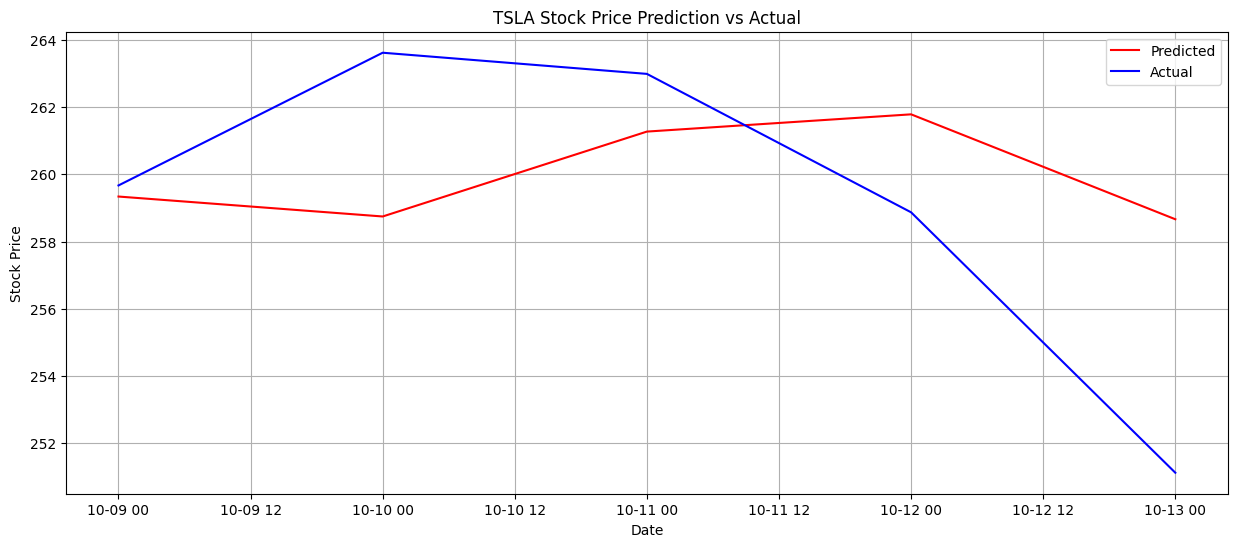

BO is [[64. 64. 70.]], with loss of [17.38131714]
Next suggested query point by UCB: 512, 64, 30
[[ 64.  32.  50.]
 [ 64.  64.  30.]
 [ 64.  64.  40.]
 [ 64.  64.  50.]
 [ 64.  64.  90.]
 [288.  64.  30.]
 [ 64.  64.  60.]
 [ 64.  64.  70.]] [[42.26970261]
 [20.73434448]
 [23.17550659]
 [18.83731079]
 [18.52789307]
 [25.28158569]
 [18.04678345]
 [17.38131714]]
Epoch 1/30
11/11 [==============================] - 3s 85ms/step - loss: 0.1446 - val_loss: 0.0068
Epoch 2/30
11/11 [==============================] - 1s 50ms/step - loss: 0.0308 - val_loss: 0.0142
Epoch 3/30
11/11 [==============================] - 1s 52ms/step - loss: 0.0170 - val_loss: 0.0112
Epoch 4/30
11/11 [==============================] - 1s 52ms/step - loss: 0.0129 - val_loss: 0.0083
Epoch 5/30
11/11 [==============================] - 1s 50ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 6/30
11/11 [==============================] - 1s 53ms/step - loss: 0.0125 - val_loss: 0.0076
Epoch 7/30
11/11 [=========================

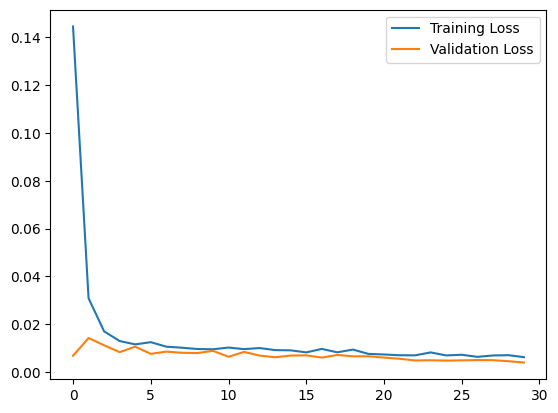

1/1 [==============================] - 0s 338ms/step


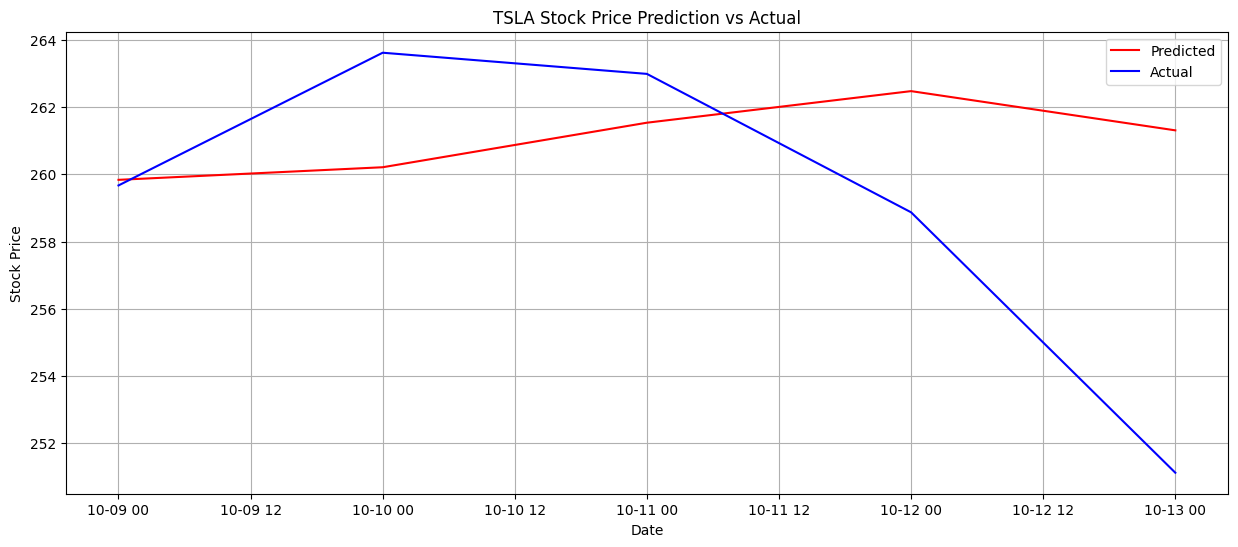

BO is [[512.  64.  30.]], with loss of [18.82495117]
Next suggested query point by UCB: 64, 64, 80
[[ 64.  32.  50.]
 [ 64.  64.  30.]
 [ 64.  64.  40.]
 [ 64.  64.  50.]
 [ 64.  64.  90.]
 [288.  64.  30.]
 [ 64.  64.  60.]
 [ 64.  64.  70.]
 [512.  64.  30.]] [[42.26970261]
 [20.73434448]
 [23.17550659]
 [18.83731079]
 [18.52789307]
 [25.28158569]
 [18.04678345]
 [17.38131714]
 [18.82495117]]
Epoch 1/80
11/11 [==============================] - 4s 48ms/step - loss: 0.1843 - val_loss: 0.0126
Epoch 2/80
11/11 [==============================] - 0s 11ms/step - loss: 0.1346 - val_loss: 0.0135
Epoch 3/80
11/11 [==============================] - 0s 11ms/step - loss: 0.0650 - val_loss: 0.0150
Epoch 4/80
11/11 [==============================] - 0s 13ms/step - loss: 0.0191 - val_loss: 0.0248
Epoch 5/80
11/11 [==============================] - 0s 12ms/step - loss: 0.0148 - val_loss: 0.0115
Epoch 6/80
11/11 [==============================] - 0s 13ms/step - loss: 0.0126 - val_loss: 0.0103
Epoch 7/

11/11 [==============================] - 0s 9ms/step - loss: 0.0047 - val_loss: 0.0032
Epoch 71/80
11/11 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 72/80
11/11 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 73/80
11/11 [==============================] - 0s 9ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 74/80
11/11 [==============================] - 0s 9ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 75/80
11/11 [==============================] - 0s 10ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 76/80
11/11 [==============================] - 0s 13ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 77/80
11/11 [==============================] - 0s 12ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 78/80
11/11 [==============================] - 0s 11ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 79/80
11/11 [==============================] - 0s 10ms/step - loss: 0.0051 - val_loss: 0.0034
Epoch 80/80
11/11

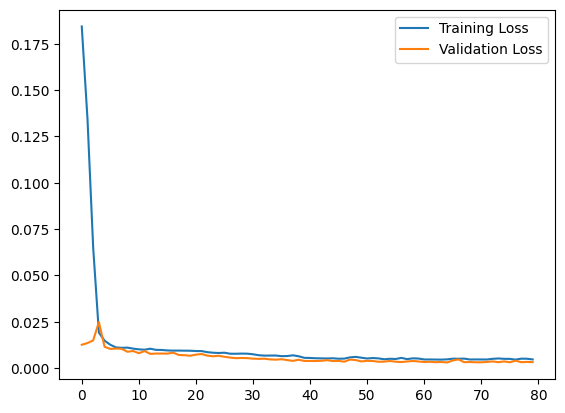

1/1 [==============================] - 0s 275ms/step


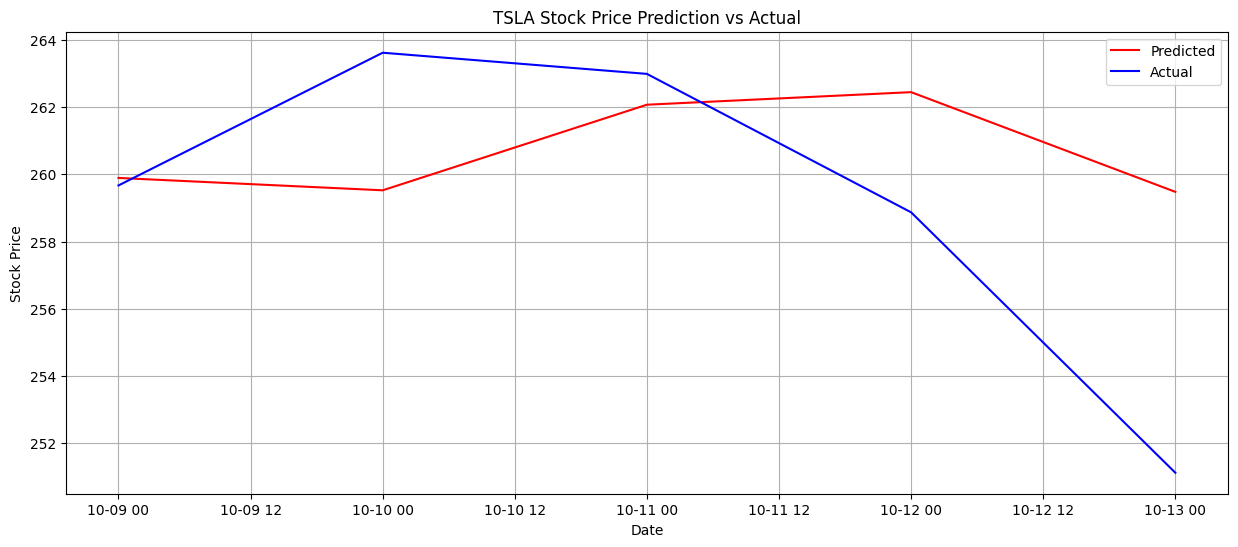

BO is [[64. 64. 80.]], with loss of [17.17105103]
Next suggested query point by UCB: 64, 64, 100
[[ 64.  32.  50.]
 [ 64.  64.  30.]
 [ 64.  64.  40.]
 [ 64.  64.  50.]
 [ 64.  64.  90.]
 [288.  64.  30.]
 [ 64.  64.  60.]
 [ 64.  64.  70.]
 [512.  64.  30.]
 [ 64.  64.  80.]] [[42.26970261]
 [20.73434448]
 [23.17550659]
 [18.83731079]
 [18.52789307]
 [25.28158569]
 [18.04678345]
 [17.38131714]
 [18.82495117]
 [17.17105103]]
Epoch 1/100
11/11 [==============================] - 3s 39ms/step - loss: 0.1759 - val_loss: 0.0111
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1161 - val_loss: 0.0082
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0392 - val_loss: 0.0146
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0182 - val_loss: 0.0162
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0131 - val_loss: 0.0115
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.

11/11 [==============================] - 0s 10ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 70/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0047 - val_loss: 0.0034
Epoch 71/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 72/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0059 - val_loss: 0.0039
Epoch 73/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0052 - val_loss: 0.0034
Epoch 74/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 75/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 76/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 77/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 78/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0046 - val_loss: 0.0032
Epoch 79/1

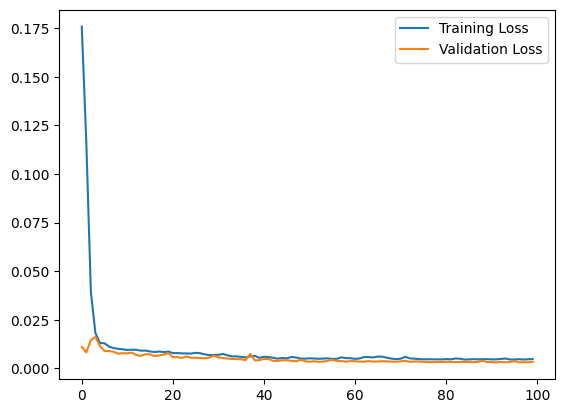

1/1 [==============================] - 0s 254ms/step


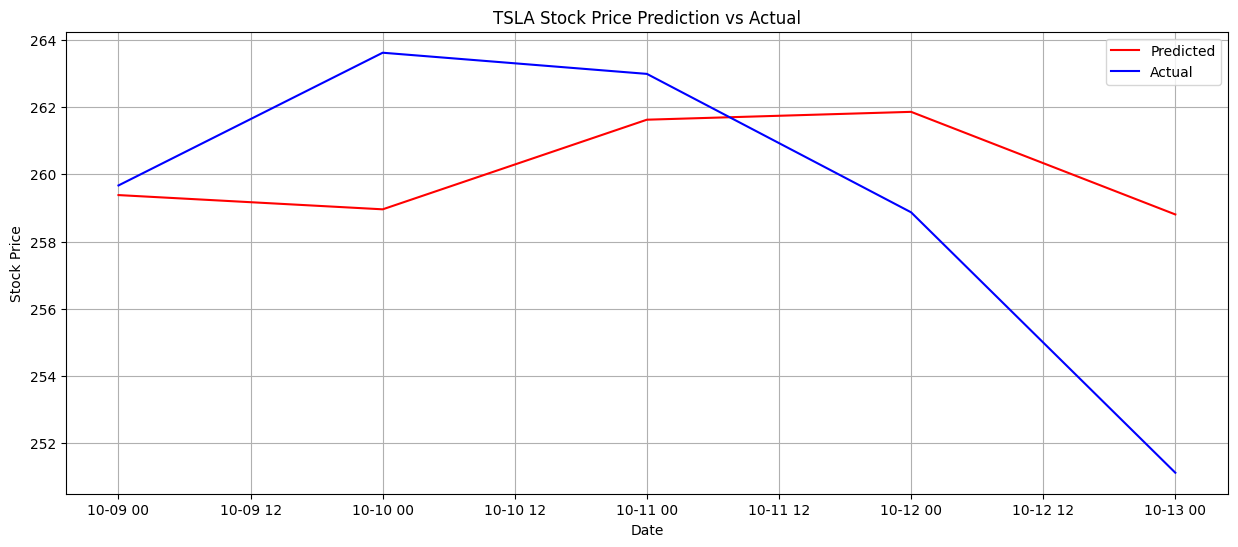

BO is [[ 64.  64. 100.]], with loss of [16.98822021]
Next suggested query point by UCB: 288, 64, 40
[[ 64.  32.  50.]
 [ 64.  64.  30.]
 [ 64.  64.  40.]
 [ 64.  64.  50.]
 [ 64.  64.  90.]
 [288.  64.  30.]
 [ 64.  64.  60.]
 [ 64.  64.  70.]
 [512.  64.  30.]
 [ 64.  64.  80.]
 [ 64.  64. 100.]] [[42.26970261]
 [20.73434448]
 [23.17550659]
 [18.83731079]
 [18.52789307]
 [25.28158569]
 [18.04678345]
 [17.38131714]
 [18.82495117]
 [17.17105103]
 [16.98822021]]
Epoch 1/40
11/11 [==============================] - 3s 61ms/step - loss: 0.1408 - val_loss: 0.0114
Epoch 2/40
11/11 [==============================] - 0s 23ms/step - loss: 0.0364 - val_loss: 0.0313
Epoch 3/40
11/11 [==============================] - 0s 26ms/step - loss: 0.0175 - val_loss: 0.0136
Epoch 4/40
11/11 [==============================] - 0s 26ms/step - loss: 0.0140 - val_loss: 0.0103
Epoch 5/40
11/11 [==============================] - 0s 26ms/step - loss: 0.0117 - val_loss: 0.0114
Epoch 6/40
11/11 [======================

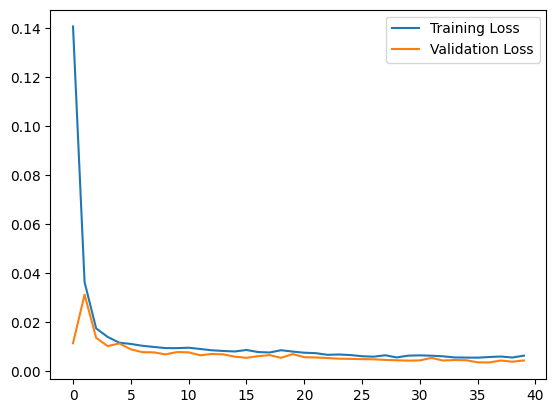

1/1 [==============================] - 0s 318ms/step


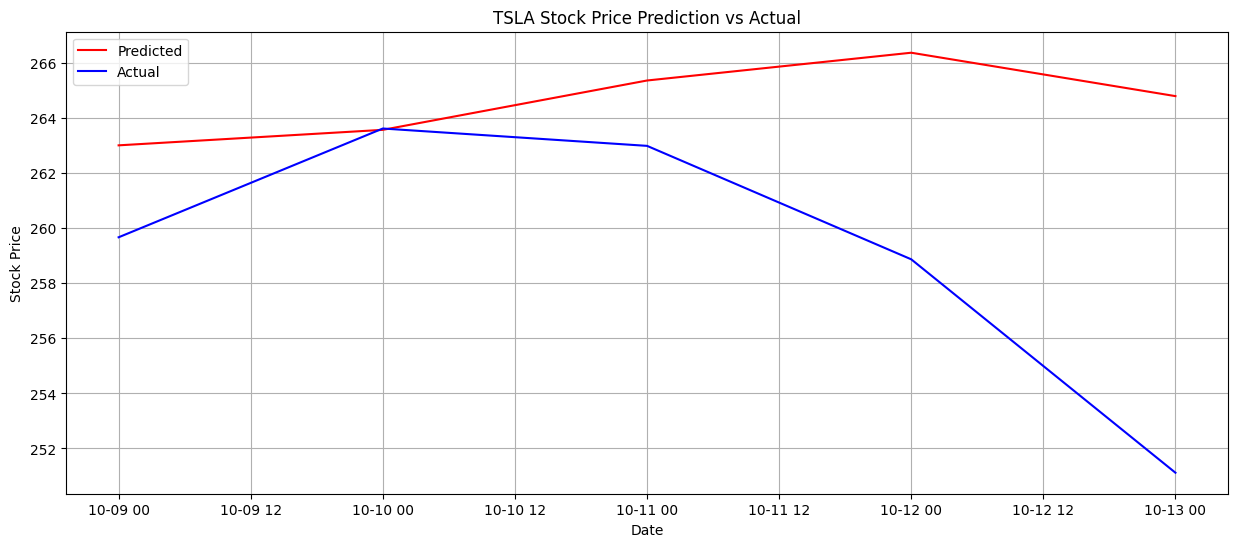

BO is [[288.  64.  40.]], with loss of [26.93887329]
Next suggested query point by UCB: 288, 64, 60
[[ 64.  32.  50.]
 [ 64.  64.  30.]
 [ 64.  64.  40.]
 [ 64.  64.  50.]
 [ 64.  64.  90.]
 [288.  64.  30.]
 [ 64.  64.  60.]
 [ 64.  64.  70.]
 [512.  64.  30.]
 [ 64.  64.  80.]
 [ 64.  64. 100.]
 [288.  64.  40.]] [[42.26970261]
 [20.73434448]
 [23.17550659]
 [18.83731079]
 [18.52789307]
 [25.28158569]
 [18.04678345]
 [17.38131714]
 [18.82495117]
 [17.17105103]
 [16.98822021]
 [26.93887329]]
Epoch 1/60
11/11 [==============================] - 3s 53ms/step - loss: 0.1282 - val_loss: 0.0115
Epoch 2/60
11/11 [==============================] - 0s 20ms/step - loss: 0.0292 - val_loss: 0.0395
Epoch 3/60
11/11 [==============================] - 0s 22ms/step - loss: 0.0161 - val_loss: 0.0129
Epoch 4/60
11/11 [==============================] - 0s 23ms/step - loss: 0.0143 - val_loss: 0.0107
Epoch 5/60
11/11 [==============================] - 0s 23ms/step - loss: 0.0117 - val_loss: 0.0103
Epoch 6

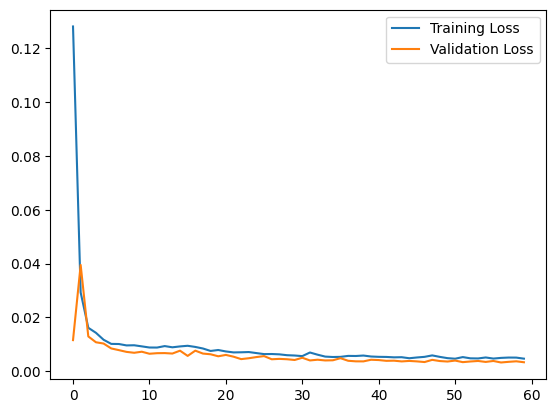

1/1 [==============================] - 0s 266ms/step


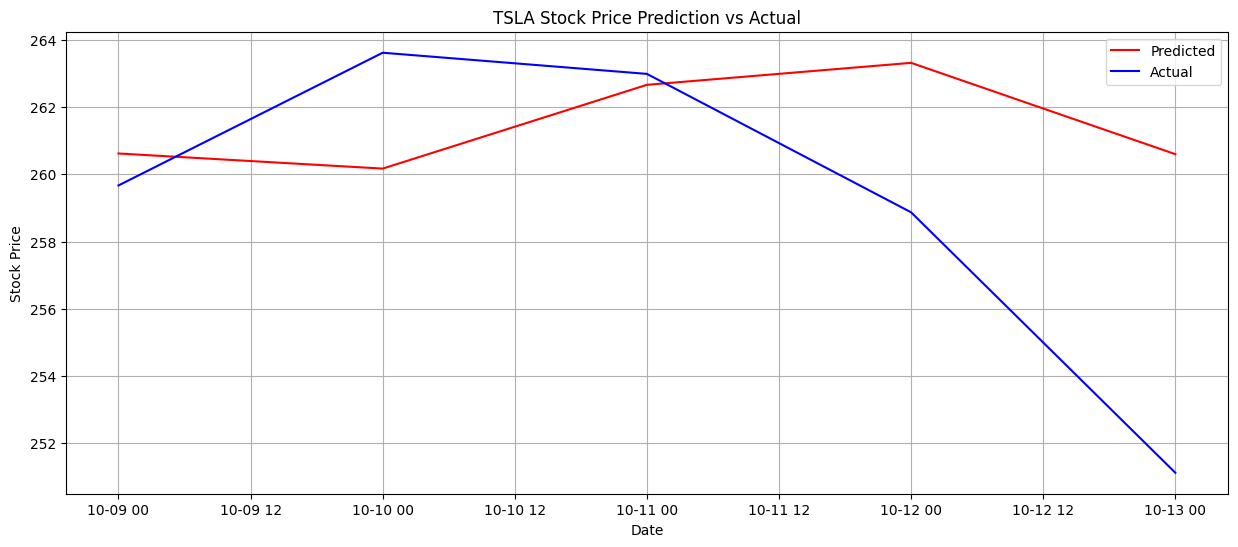

BO is [[288.  64.  60.]], with loss of [18.6546936]
Next suggested query point by UCB: 64, 288, 30
[[ 64.  32.  50.]
 [ 64.  64.  30.]
 [ 64.  64.  40.]
 [ 64.  64.  50.]
 [ 64.  64.  90.]
 [288.  64.  30.]
 [ 64.  64.  60.]
 [ 64.  64.  70.]
 [512.  64.  30.]
 [ 64.  64.  80.]
 [ 64.  64. 100.]
 [288.  64.  40.]
 [288.  64.  60.]] [[42.26970261]
 [20.73434448]
 [23.17550659]
 [18.83731079]
 [18.52789307]
 [25.28158569]
 [18.04678345]
 [17.38131714]
 [18.82495117]
 [17.17105103]
 [16.98822021]
 [26.93887329]
 [18.6546936 ]]
Epoch 1/30
11/11 [==============================] - 4s 87ms/step - loss: 0.1666 - val_loss: 0.0103
Epoch 2/30
11/11 [==============================] - 0s 29ms/step - loss: 0.0494 - val_loss: 0.0253
Epoch 3/30
11/11 [==============================] - 0s 31ms/step - loss: 0.0210 - val_loss: 0.0145
Epoch 4/30
11/11 [==============================] - 0s 29ms/step - loss: 0.0163 - val_loss: 0.0123
Epoch 5/30
11/11 [==============================] - 0s 30ms/step - loss: 0

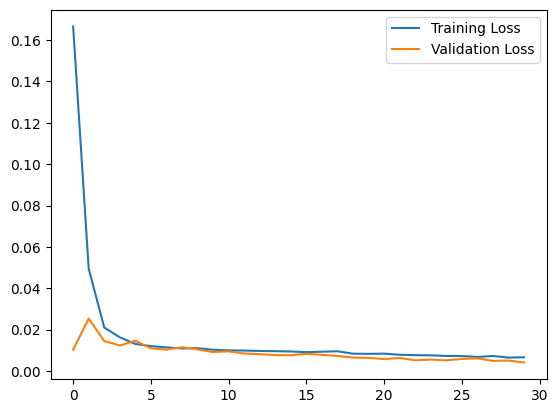

1/1 [==============================] - 0s 401ms/step


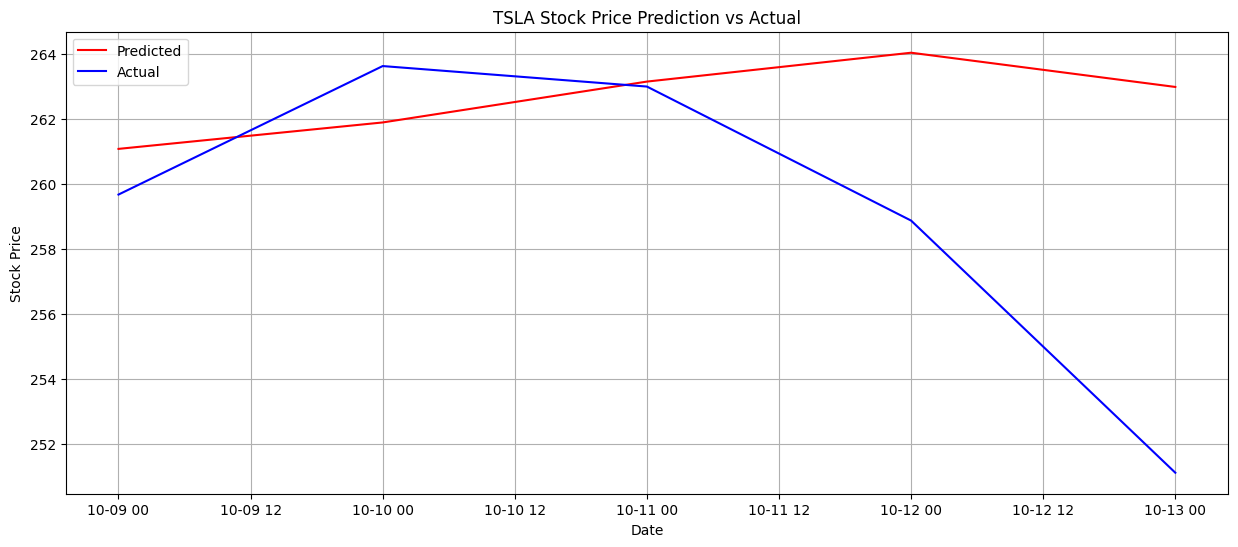

BO is [[ 64. 288.  30.]], with loss of [20.30807495]
Next suggested query point by UCB: 288, 64, 50
[[ 64.  32.  50.]
 [ 64.  64.  30.]
 [ 64.  64.  40.]
 [ 64.  64.  50.]
 [ 64.  64.  90.]
 [288.  64.  30.]
 [ 64.  64.  60.]
 [ 64.  64.  70.]
 [512.  64.  30.]
 [ 64.  64.  80.]
 [ 64.  64. 100.]
 [288.  64.  40.]
 [288.  64.  60.]
 [ 64. 288.  30.]] [[42.26970261]
 [20.73434448]
 [23.17550659]
 [18.83731079]
 [18.52789307]
 [25.28158569]
 [18.04678345]
 [17.38131714]
 [18.82495117]
 [17.17105103]
 [16.98822021]
 [26.93887329]
 [18.6546936 ]
 [20.30807495]]
Epoch 1/50
11/11 [==============================] - 8s 132ms/step - loss: 0.1532 - val_loss: 0.0069
Epoch 2/50
11/11 [==============================] - 0s 42ms/step - loss: 0.0424 - val_loss: 0.0283
Epoch 3/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0180 - val_loss: 0.0079
Epoch 4/50
11/11 [==============================] - 0s 43ms/step - loss: 0.0145 - val_loss: 0.0133
Epoch 5/50
11/11 [=====================

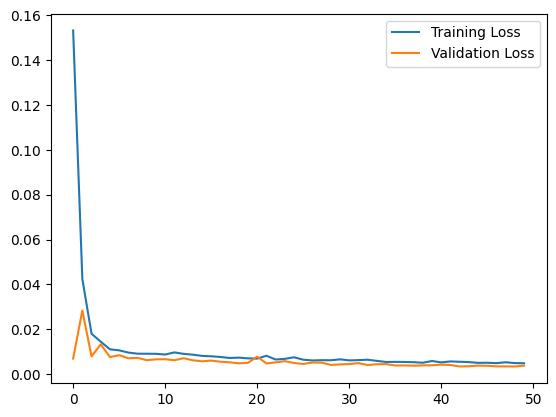

1/1 [==============================] - 0s 397ms/step


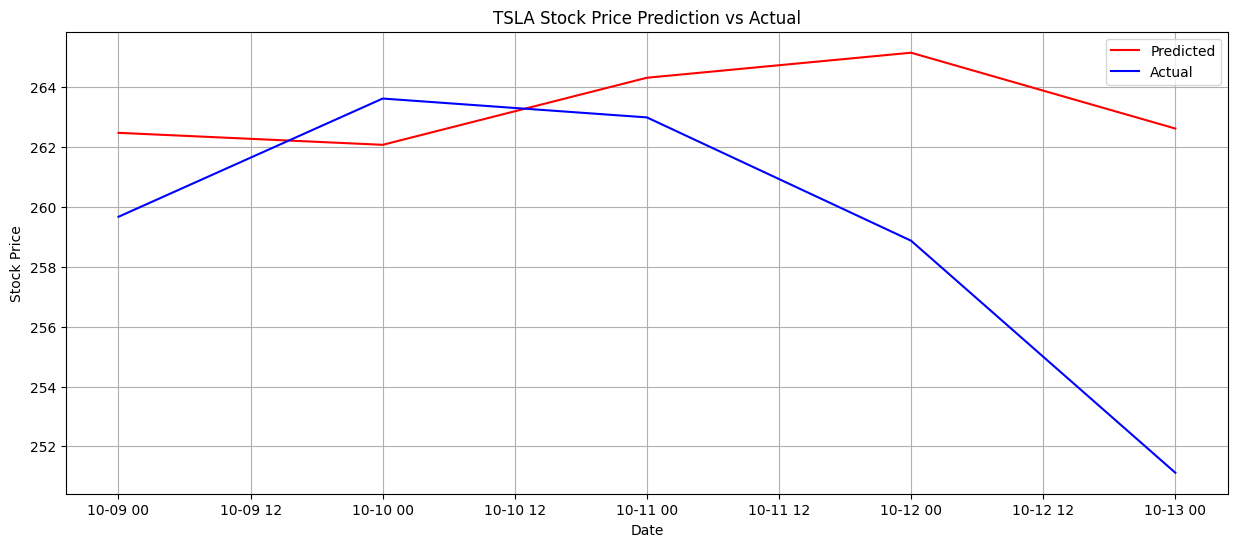

BO is [[288.  64.  50.]], with loss of [23.45346069]
Next suggested query point by UCB: 288, 64, 70
[[ 64.  32.  50.]
 [ 64.  64.  30.]
 [ 64.  64.  40.]
 [ 64.  64.  50.]
 [ 64.  64.  90.]
 [288.  64.  30.]
 [ 64.  64.  60.]
 [ 64.  64.  70.]
 [512.  64.  30.]
 [ 64.  64.  80.]
 [ 64.  64. 100.]
 [288.  64.  40.]
 [288.  64.  60.]
 [ 64. 288.  30.]
 [288.  64.  50.]] [[42.26970261]
 [20.73434448]
 [23.17550659]
 [18.83731079]
 [18.52789307]
 [25.28158569]
 [18.04678345]
 [17.38131714]
 [18.82495117]
 [17.17105103]
 [16.98822021]
 [26.93887329]
 [18.6546936 ]
 [20.30807495]
 [23.45346069]]
Epoch 1/70
11/11 [==============================] - 4s 64ms/step - loss: 0.1531 - val_loss: 0.0085
Epoch 2/70
11/11 [==============================] - 0s 26ms/step - loss: 0.0406 - val_loss: 0.0243
Epoch 3/70
11/11 [==============================] - 0s 27ms/step - loss: 0.0172 - val_loss: 0.0112
Epoch 4/70
11/11 [==============================] - 0s 28ms/step - loss: 0.0153 - val_loss: 0.0101
Epoch 5

11/11 [==============================] - 0s 29ms/step - loss: 0.0051 - val_loss: 0.0034
Epoch 69/70
11/11 [==============================] - 0s 32ms/step - loss: 0.0057 - val_loss: 0.0036
Epoch 70/70
11/11 [==============================] - 0s 28ms/step - loss: 0.0049 - val_loss: 0.0040


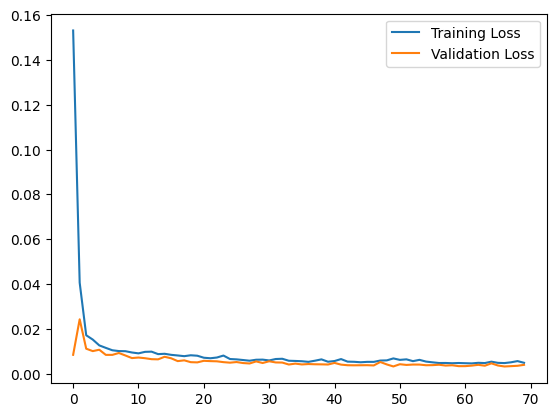

1/1 [==============================] - 0s 356ms/step


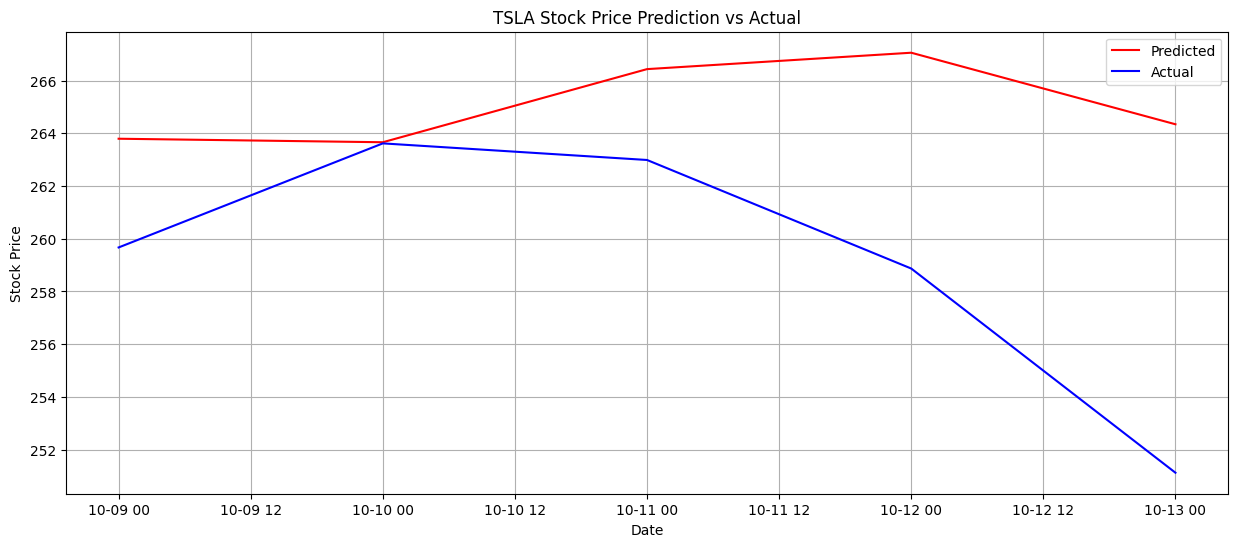

BO is [[288.  64.  70.]], with loss of [29.03512573]
Next suggested query point by UCB: 288, 64, 80
[[ 64.  32.  50.]
 [ 64.  64.  30.]
 [ 64.  64.  40.]
 [ 64.  64.  50.]
 [ 64.  64.  90.]
 [288.  64.  30.]
 [ 64.  64.  60.]
 [ 64.  64.  70.]
 [512.  64.  30.]
 [ 64.  64.  80.]
 [ 64.  64. 100.]
 [288.  64.  40.]
 [288.  64.  60.]
 [ 64. 288.  30.]
 [288.  64.  50.]
 [288.  64.  70.]] [[42.26970261]
 [20.73434448]
 [23.17550659]
 [18.83731079]
 [18.52789307]
 [25.28158569]
 [18.04678345]
 [17.38131714]
 [18.82495117]
 [17.17105103]
 [16.98822021]
 [26.93887329]
 [18.6546936 ]
 [20.30807495]
 [23.45346069]
 [29.03512573]]
Epoch 1/80
11/11 [==============================] - 4s 68ms/step - loss: 0.1623 - val_loss: 0.0084
Epoch 2/80
11/11 [==============================] - 0s 22ms/step - loss: 0.0518 - val_loss: 0.0232
Epoch 3/80
11/11 [==============================] - 0s 24ms/step - loss: 0.0206 - val_loss: 0.0086
Epoch 4/80
11/11 [==============================] - 0s 25ms/step - loss: 

11/11 [==============================] - 0s 28ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 69/80
11/11 [==============================] - 0s 26ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 70/80
11/11 [==============================] - 0s 30ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 71/80
11/11 [==============================] - 0s 28ms/step - loss: 0.0046 - val_loss: 0.0032
Epoch 72/80
11/11 [==============================] - 0s 26ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 73/80
11/11 [==============================] - 0s 26ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 74/80
11/11 [==============================] - 0s 26ms/step - loss: 0.0049 - val_loss: 0.0033
Epoch 75/80
11/11 [==============================] - 0s 27ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 76/80
11/11 [==============================] - 0s 26ms/step - loss: 0.0047 - val_loss: 0.0034
Epoch 77/80
11/11 [==============================] - 0s 23ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 78/80


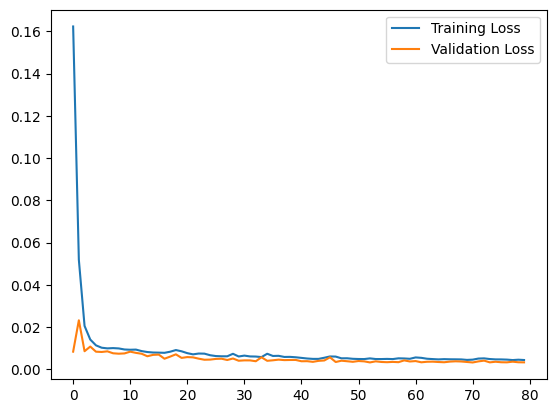

1/1 [==============================] - 0s 269ms/step


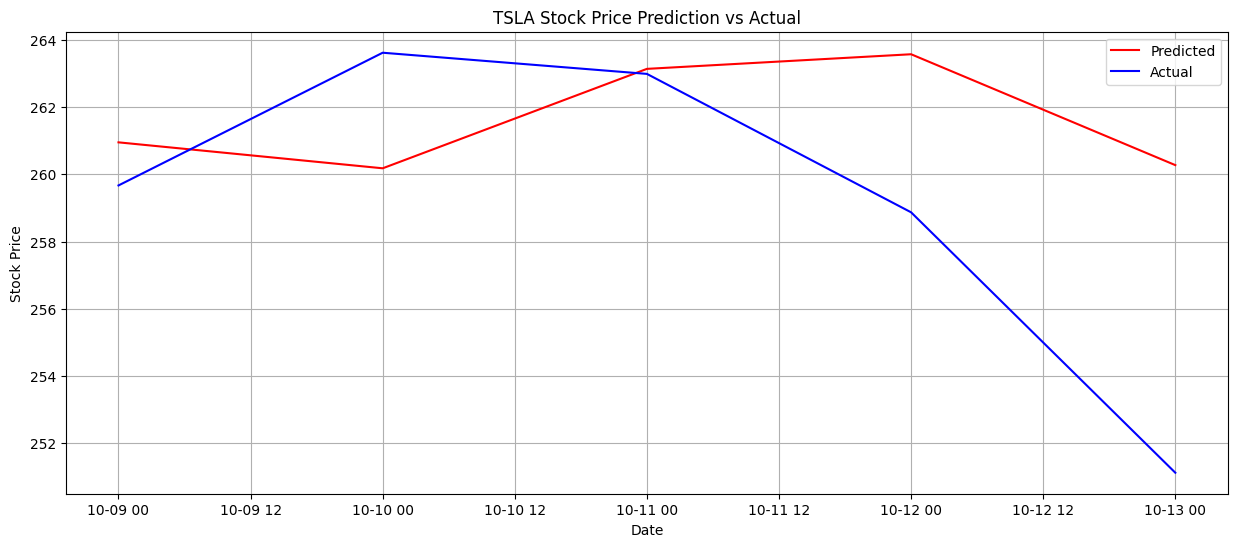

BO is [[288.  64.  80.]], with loss of [18.73098755]
Next suggested query point by UCB: 288, 64, 100
[[ 64.  32.  50.]
 [ 64.  64.  30.]
 [ 64.  64.  40.]
 [ 64.  64.  50.]
 [ 64.  64.  90.]
 [288.  64.  30.]
 [ 64.  64.  60.]
 [ 64.  64.  70.]
 [512.  64.  30.]
 [ 64.  64.  80.]
 [ 64.  64. 100.]
 [288.  64.  40.]
 [288.  64.  60.]
 [ 64. 288.  30.]
 [288.  64.  50.]
 [288.  64.  70.]
 [288.  64.  80.]] [[42.26970261]
 [20.73434448]
 [23.17550659]
 [18.83731079]
 [18.52789307]
 [25.28158569]
 [18.04678345]
 [17.38131714]
 [18.82495117]
 [17.17105103]
 [16.98822021]
 [26.93887329]
 [18.6546936 ]
 [20.30807495]
 [23.45346069]
 [29.03512573]
 [18.73098755]]
Epoch 1/100
11/11 [==============================] - 4s 72ms/step - loss: 0.1686 - val_loss: 0.0087
Epoch 2/100
11/11 [==============================] - 0s 29ms/step - loss: 0.0591 - val_loss: 0.0199
Epoch 3/100
11/11 [==============================] - 0s 31ms/step - loss: 0.0210 - val_loss: 0.0089
Epoch 4/100
11/11 [=================

Epoch 67/100
11/11 [==============================] - 0s 34ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 68/100
11/11 [==============================] - 0s 35ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 69/100
11/11 [==============================] - 0s 31ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 70/100
11/11 [==============================] - 0s 29ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 71/100
11/11 [==============================] - 0s 29ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 72/100
11/11 [==============================] - 0s 28ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 73/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 74/100
11/11 [==============================] - 0s 27ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 75/100
11/11 [==============================] - 0s 28ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 76/100
11/11 [==============================] - 0s 35ms/step - loss: 0.0047 - val_los

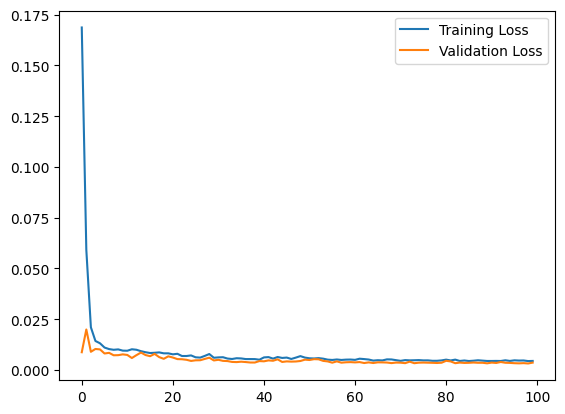

1/1 [==============================] - 0s 374ms/step


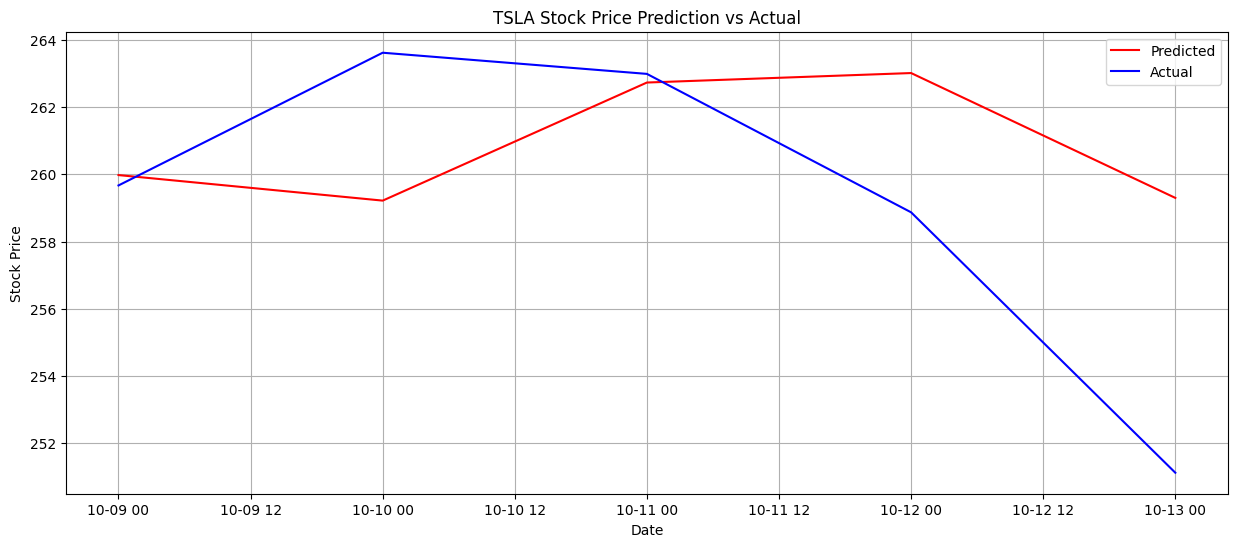

BO is [[288.  64. 100.]], with loss of [17.29171753]
Next suggested query point by UCB: 288, 64, 90
[[ 64.  32.  50.]
 [ 64.  64.  30.]
 [ 64.  64.  40.]
 [ 64.  64.  50.]
 [ 64.  64.  90.]
 [288.  64.  30.]
 [ 64.  64.  60.]
 [ 64.  64.  70.]
 [512.  64.  30.]
 [ 64.  64.  80.]
 [ 64.  64. 100.]
 [288.  64.  40.]
 [288.  64.  60.]
 [ 64. 288.  30.]
 [288.  64.  50.]
 [288.  64.  70.]
 [288.  64.  80.]
 [288.  64. 100.]] [[42.26970261]
 [20.73434448]
 [23.17550659]
 [18.83731079]
 [18.52789307]
 [25.28158569]
 [18.04678345]
 [17.38131714]
 [18.82495117]
 [17.17105103]
 [16.98822021]
 [26.93887329]
 [18.6546936 ]
 [20.30807495]
 [23.45346069]
 [29.03512573]
 [18.73098755]
 [17.29171753]]
Epoch 1/90
11/11 [==============================] - 3s 60ms/step - loss: 0.1543 - val_loss: 0.0078
Epoch 2/90
11/11 [==============================] - 0s 25ms/step - loss: 0.0471 - val_loss: 0.0243
Epoch 3/90
11/11 [==============================] - 0s 31ms/step - loss: 0.0187 - val_loss: 0.0075
Epoch 4

11/11 [==============================] - 0s 29ms/step - loss: 0.0052 - val_loss: 0.0034
Epoch 68/90
11/11 [==============================] - 0s 29ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 69/90
11/11 [==============================] - 0s 28ms/step - loss: 0.0053 - val_loss: 0.0033
Epoch 70/90
11/11 [==============================] - 0s 29ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 71/90
11/11 [==============================] - 0s 33ms/step - loss: 0.0053 - val_loss: 0.0037
Epoch 72/90
11/11 [==============================] - 0s 31ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 73/90
11/11 [==============================] - 0s 31ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 74/90
11/11 [==============================] - 0s 37ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 75/90
11/11 [==============================] - 0s 33ms/step - loss: 0.0047 - val_loss: 0.0034
Epoch 76/90
11/11 [==============================] - 0s 31ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 77/90


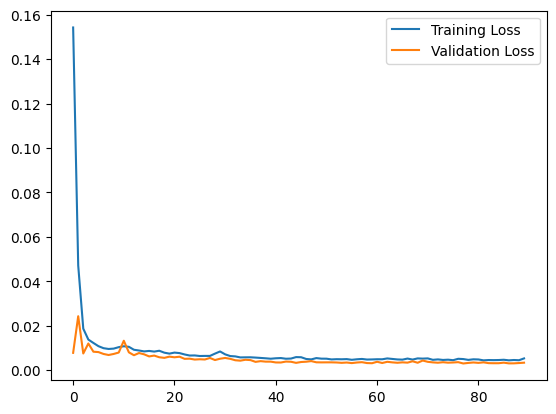

1/1 [==============================] - 0s 307ms/step


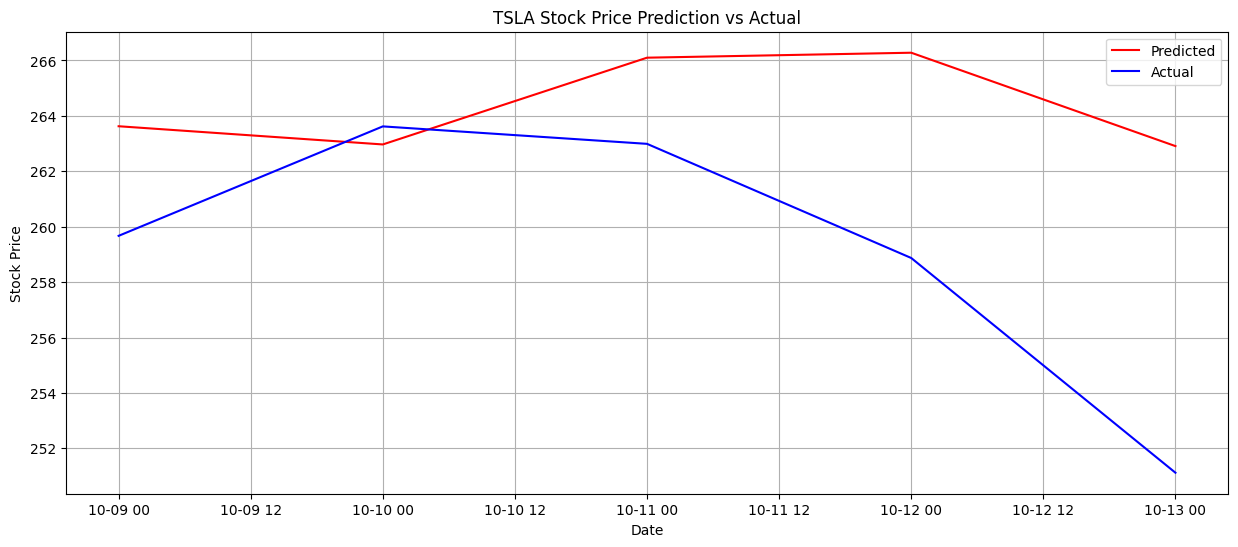

BO is [[288.  64.  90.]], with loss of [26.91421509]
Next suggested query point by UCB: 288, 288, 30
[[ 64.  32.  50.]
 [ 64.  64.  30.]
 [ 64.  64.  40.]
 [ 64.  64.  50.]
 [ 64.  64.  90.]
 [288.  64.  30.]
 [ 64.  64.  60.]
 [ 64.  64.  70.]
 [512.  64.  30.]
 [ 64.  64.  80.]
 [ 64.  64. 100.]
 [288.  64.  40.]
 [288.  64.  60.]
 [ 64. 288.  30.]
 [288.  64.  50.]
 [288.  64.  70.]
 [288.  64.  80.]
 [288.  64. 100.]
 [288.  64.  90.]] [[42.26970261]
 [20.73434448]
 [23.17550659]
 [18.83731079]
 [18.52789307]
 [25.28158569]
 [18.04678345]
 [17.38131714]
 [18.82495117]
 [17.17105103]
 [16.98822021]
 [26.93887329]
 [18.6546936 ]
 [20.30807495]
 [23.45346069]
 [29.03512573]
 [18.73098755]
 [17.29171753]
 [26.91421509]]
Epoch 1/30
11/11 [==============================] - 3s 92ms/step - loss: 0.1259 - val_loss: 0.0105
Epoch 2/30
11/11 [==============================] - 1s 47ms/step - loss: 0.0246 - val_loss: 0.0108
Epoch 3/30
11/11 [==============================] - 1s 51ms/step - loss:

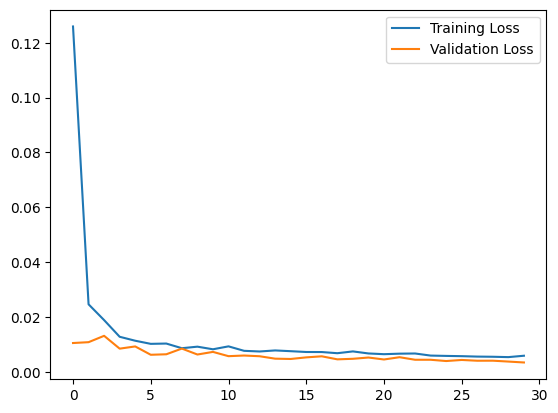

1/1 [==============================] - 0s 272ms/step


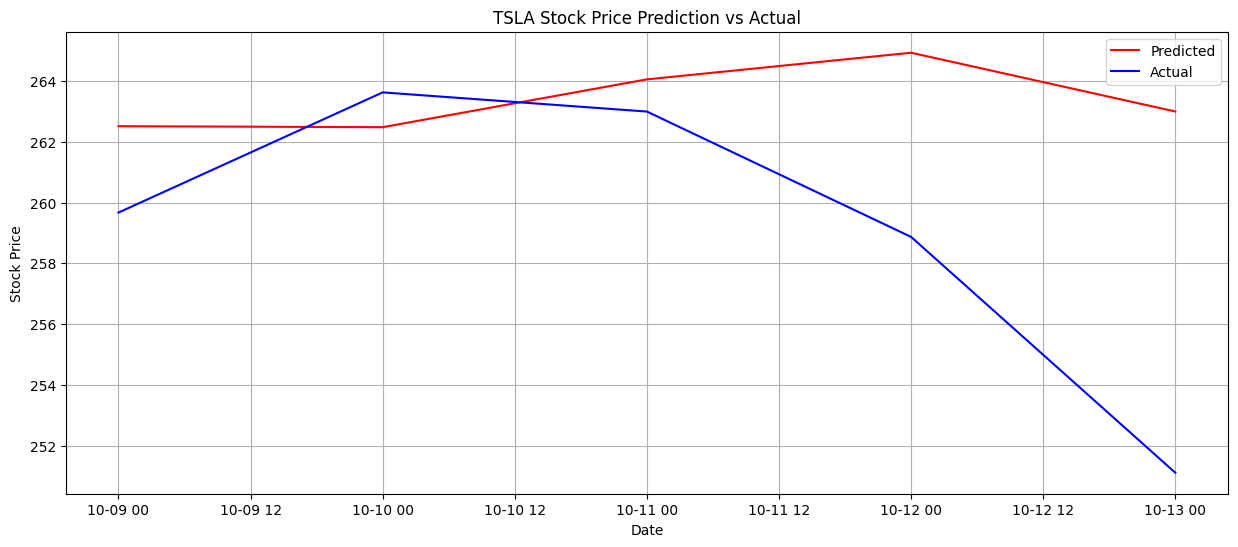

BO is [[288. 288.  30.]], with loss of [22.96624756]
Next suggested query point by UCB: 512, 288, 30
[[ 64.  32.  50.]
 [ 64.  64.  30.]
 [ 64.  64.  40.]
 [ 64.  64.  50.]
 [ 64.  64.  90.]
 [288.  64.  30.]
 [ 64.  64.  60.]
 [ 64.  64.  70.]
 [512.  64.  30.]
 [ 64.  64.  80.]
 [ 64.  64. 100.]
 [288.  64.  40.]
 [288.  64.  60.]
 [ 64. 288.  30.]
 [288.  64.  50.]
 [288.  64.  70.]
 [288.  64.  80.]
 [288.  64. 100.]
 [288.  64.  90.]
 [288. 288.  30.]] [[42.26970261]
 [20.73434448]
 [23.17550659]
 [18.83731079]
 [18.52789307]
 [25.28158569]
 [18.04678345]
 [17.38131714]
 [18.82495117]
 [17.17105103]
 [16.98822021]
 [26.93887329]
 [18.6546936 ]
 [20.30807495]
 [23.45346069]
 [29.03512573]
 [18.73098755]
 [17.29171753]
 [26.91421509]
 [22.96624756]]
Epoch 1/30
11/11 [==============================] - 4s 137ms/step - loss: 0.1151 - val_loss: 0.0216
Epoch 2/30
11/11 [==============================] - 1s 83ms/step - loss: 0.0231 - val_loss: 0.0097
Epoch 3/30
11/11 [====================

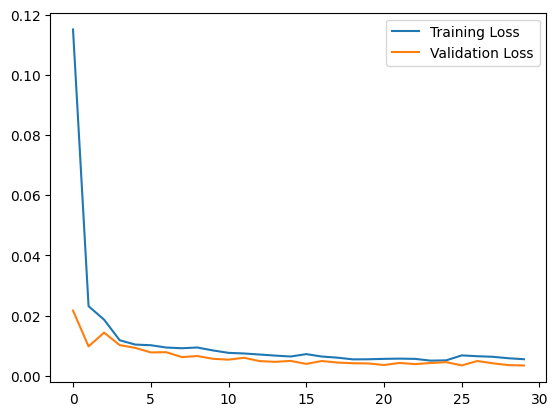

1/1 [==============================] - 0s 394ms/step


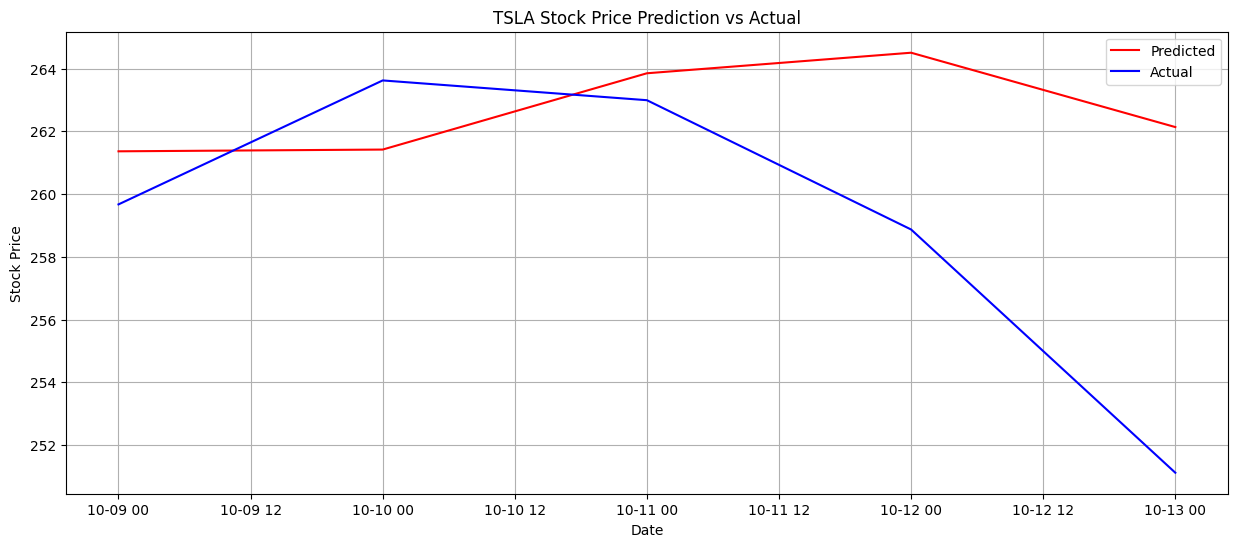

BO is [[512. 288.  30.]], with loss of [21.39920044]


In [27]:
query = np.empty((0, len(X[0])))  # Assuming X is a 2D array
obs = np.empty((0, 1))  # 1D column vector

noise_assumption = 1e-10
rbf_lengthscale = 0.1
beta = 1.96        # UCB exploration parameter. beta increases, exploration increases.
eta = 0.05         # PI exploration parameter. 0.1 for explore, 0.01 for exploitiation
xi = 0.1          # EI exploration parameter. 0.1  for balance, 0.01 for exploitiation

# Fit the Gaussian Process Regression model
kernel = RBF(length_scale=rbf_lengthscale*len(X.T))
bogp = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption, n_restarts_optimizer=5)

breakcount = 0

while breakcount < 20 :
    # Update the surrogate model with the new observation
    df_X, df_y = update_surrogate_model(query, obs)
    X = df_X
    Y = df_y
    
    # Fit the surrogate model with the given dataset
    bogp.fit(df_X, df_y)

    # # Get the next suggested query point
    next_query_point_ucb, af_ucb = upper_confidence_bound(beta)
    next_query_point_pi, af_pi = probability_improvement(eta)
    next_query_point_ei, af_ei = expected_improvement(xi)

    # # Comparing 3 aq. function and choose the highest.
    next_query_point, chosen_af = choose_next_query_point(next_query_point_ucb, af_ucb, next_query_point_ei, af_ei, next_query_point_pi, af_pi)

    print(f'Next suggested query point by {chosen_af}: '
          f'{np.round(next_query_point[0], 0):.0f}, '
          f'{np.round(next_query_point[1], 0):.0f}, '
          f'{np.round(next_query_point[2], 0):.0f}')

    print(df_X, df_y)
    bo = next_query_point #For bo hidden_dim, num_layers, dropout, learning_rate, epoch

    actual_predictions = main(train_x, train_y, valid_x, valid_y, test_dataset, bo)
    abs_different = np.sum(abs(actual_predictions-data.tail(len(actual_predictions))))
    query = np.array(bo).reshape(1, -1)
    obs = np.array(abs_different) # val_loss # Validation loss
    
    print(f'BO is {query}, with loss of {obs}')
    
    breakcount +=1
    if abs_different.iloc[-1] < 5:
        break


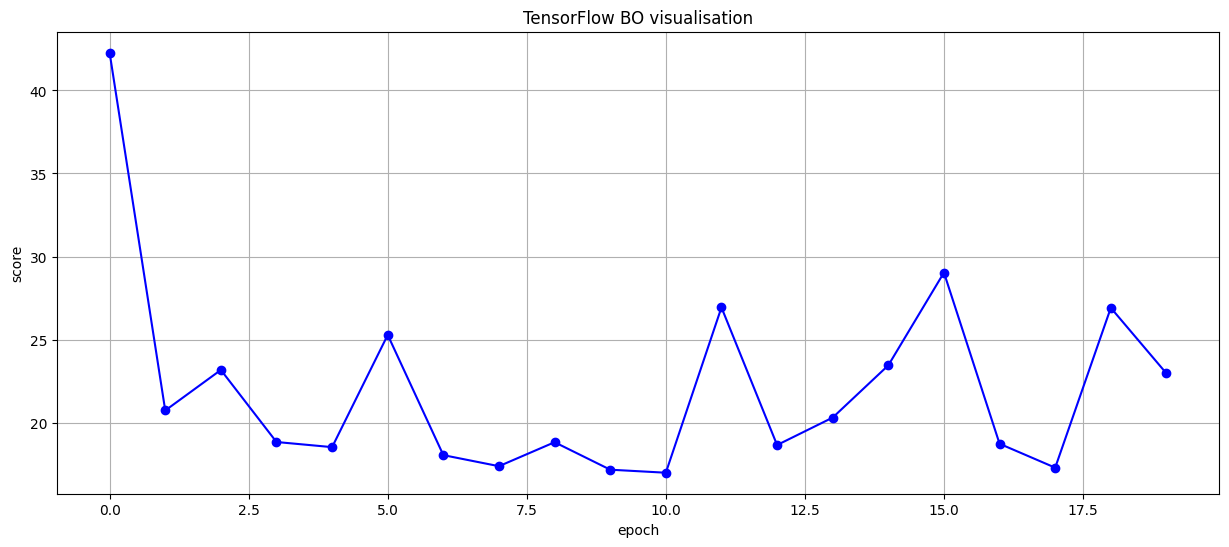

In [33]:
plt.figure(figsize=(15, 6))
plt.plot(df_y, marker='o', linestyle='-', color='b')
plt.title('TensorFlow BO visualisation')
plt.xlabel('epoch')
plt.ylabel('score')
plt.grid(True)
plt.show()

# Conclusion

One question comes to mind when predicting stock market. Is stock price a causation or consequence? 

This project doesn't consider...
1. Transaction cost
2. Slippage
3. 

In [22]:
# #Working
# import numpy as np
# import pandas as pd
# import yfinance as yf
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# from sklearn.preprocessing import MinMaxScaler

# # 1. Fetch Historical Stock Prices
# data = yf.download('TSLA', start='2021-01-01')
# data = data[['Close']]

# # 2. Preprocess the Data
# scaler = MinMaxScaler(feature_range=(-1, 1))
# data_normalized = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# def create_inout_sequences(input_data, tw):
#     inout_seq = []
#     L = len(input_data)
#     for i in range(L-tw):
#         train_seq = input_data[i:i+tw]
#         train_label = input_data[i+tw:i+tw+1]
#         inout_seq.append((train_seq, train_label))
#     return inout_seq

# train_window = 5
# inout_seq = create_inout_sequences(data_normalized, train_window)
# train_inout_seq = [(torch.Tensor(seq), torch.Tensor(label)) for seq, label in inout_seq]

# # 3. Build LSTM Model
# class LSTM(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, dropout, output_dim):
#         super(LSTM, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
#         self.linear = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         out, _ = self.lstm(x)
#         out = self.linear(out[:, -1, :])
#         return out

# def main(train_window, train_inout_seq, bo):
#     input_dim = 1
#     hidden_dim = int(bo[0])
#     num_layers = int(bo[1])
#     output_dim = 1

#     dropout = float(bo[2]) #0.01
#     learning_rate = float(bo[3]) #0.01
    
#     model = LSTM(input_dim, hidden_dim, num_layers, dropout, output_dim)
#     criterion = torch.nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#     # 4. Train the Model
#     epochs = 50
#     for epoch in range(epochs):
#         for seq, labels in train_inout_seq:
#             optimizer.zero_grad()
#             y_pred = model(seq.view(1, train_window, -1))
#             loss = criterion(y_pred, labels)
#             loss.backward()
#             optimizer.step()
#         if epoch % 10 == 0:
#             print(f'Epoch {epoch} loss: {loss.item()}')

#     # 5. Predict Future Prices
#     test_inputs = data_normalized[-train_window:].tolist()

#     model.eval()
#     for i in range(train_window):
#         seq = torch.FloatTensor(test_inputs[-train_window:]).view(1, train_window, -1)
#         with torch.no_grad():
#             test_inputs.append([model(seq).item()])

#     actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))
#     dates = data.index[-train_window:]
#     plt.figure(figsize=(15, 6))
#     plt.plot(dates, actual_predictions, label='Predicted', color='red')
#     plt.plot(dates, scaler.inverse_transform(data_normalized[-train_window:]), label='Actual', color='blue')
#     plt.title("TSLA Stock Price Prediction vs Actual")
#     plt.xlabel("Date")
#     plt.ylabel("Stock Price")
#     plt.legend()
#     plt.grid(True)
#     plt.show()
#     return(actual_predictions)
    
# if __name__ == '__main__':
#     bo = [64, 2, 0.3, 0.01]     # hidden_dim, num_layers, dropout, learning_rate
#     actual_predictions = main(train_window, train_inout_seq, bo) 
#     print(actual_predictions)